# MarathoNet

_MarathoNet_ es un sistema inteligente capaz de detectar el número de dorsal de corredores de maratón a partir del video extraído de una cámara que graba la carrera en un punto de control.

## Descripción del problema

Para poder identificar el dorsal de un corredor necesitamos detectar en tiempo real dónde se encuentra el cuerpo de éste en cada frame que extraemos de un vídeo que graba la carrera. 

En este notebook se plantea utilizar la arquitectura _MTCNN_ preentrenado con _FaceNet_ para la identificación de puntos clave de la cara. Los cuales podrán ser de utilidad para diseñar un subsistema de identificación y tracking de corredores de maratón.

## Pruebas iniciales con _MTCNN_

Con el fin de familiarizarnos con la librería [_MTCNN_](https://github.com/ipazc/mtcnn), disponemos de una serie de vídeos de personas moviéndose en una escena que utilizaremos como toma de contacto inicial con la librería y así observar todas la potencia y funcionalidades que esta ofrece.

### Carga de vídeos

Se procede con la carga de los diferentes archivos de vídeo que disponemos para realizar las pruebas con [_MTCNN_](https://github.com/ipazc/mtcnn). Para ello, importaremos el módulo [_os_](https://docs.python.org/3/library/os.html) que permite el manejo de diferentes funcionalidades de sistema operativo, entre ellas, el manejo de ficheros y directorios.

In [15]:
import os

In [16]:
PATH = 'videos'
video_files = list()
for root, dirs, files in os.walk(os.path.relpath(PATH)):
    for file in files:
        video_files.append(os.path.join(root, file))

no_videos = len(video_files)
print(video_files)

['videos/01_03_03_27_08.mp4', 'videos/02_01_01_17_01.mp4', 'videos/03_02_02_30_04.MP4', 'videos/04_01_01_10_02.mp4', 'videos/05_01_02_08_01.mp4', 'videos/images_comp.mp4', 'videos/LPATrail-2.mp4', 'videos/place3-1.mp4', 'videos/place3-2.mp4', 'videos/place3-3.mp4']


El manejo y procesado de videos será gestionado por la librería de visión por computador, [_OpenCV_](https://opencv.org/), que depende a su vez de la archiconocida librería de computación científica, [_Numpy_](https://www.numpy.org/). Mostraremos las imágenes que procesamos [_OpenCV_](https://opencv.org/) en el propio _Jupyter Notebook_, es por este motivo por el cuál también tendremos que importar la librería [Matplotlib](https://matplotlib.org/). A continuación, procederemos con la carga de sendos paquetes:

In [17]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

El objeto _VideoCapture_ es el que recibe la entrada de vídeo. Este dispone de una serie de métodos que iremos utilizando a lo largo de las pruebas con [_MTCNN_](https://github.com/ipazc/mtcnn). Se crea un diccionario que contenga un objeto _VideoCapture_ para cada imagen que encontremos en el directorio donde almacenamos los archivos de vídeo.

In [18]:
keys = [ 'video_' + str(i+1) for i in range(len(video_files)) ]

videos = { k: cv.VideoCapture(cv.samples.findFileOrKeep(v)) for (k, v) in zip(keys, video_files) }

for k,v in videos.items():
    if not v.isOpened():
        print('Unable to open: \'' + k + '\'')
        exit(0)

print(videos)

{'video_1': <VideoCapture 0x7fe6882710f0>, 'video_2': <VideoCapture 0x7fe7e416b9b0>, 'video_3': <VideoCapture 0x7fe6882713b0>, 'video_4': <VideoCapture 0x7fe688271530>, 'video_5': <VideoCapture 0x7fe688271490>, 'video_6': <VideoCapture 0x7fe6882717d0>, 'video_7': <VideoCapture 0x7fe6882716d0>, 'video_8': <VideoCapture 0x7fe688271710>, 'video_9': <VideoCapture 0x7fe6882712d0>, 'video_10': <VideoCapture 0x7fe6882715d0>}


Seleccionaremos un frame arbitrario con el método _set()_ de cada objeto de la clase _VideoCapture_ generado en el paso anterior. El número máximo de frames de un video lo extraemos con el método _get()_ y el selector _cv.CAP_PROP_FRAME_COUNT_ de la clase _VideoCapture_. 

Tomamos un número entero aleatorio dentro del rango de frames que dispone cada vídeo para poder mostrar un frame aleatorio de la misma. Por este motivo tendremos que utilizar el método _randint()_ e importar la librería [random](https://docs.python.org/2/library/random.html).

Posteriormente, recuperamos el frame con el método _read()_ de la misma clase y lo mostraremos por pantalla utilizando el método _plt.imshow()_ de la librería [Matplotlib](https://matplotlib.org/).

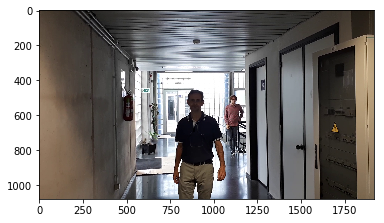

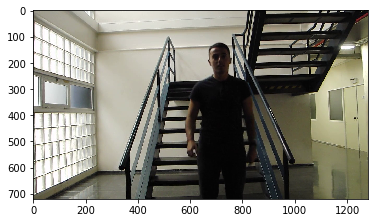

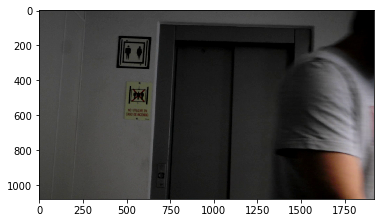

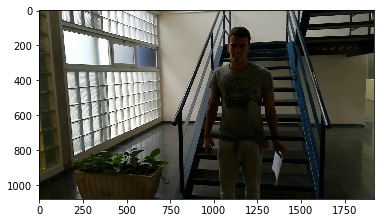

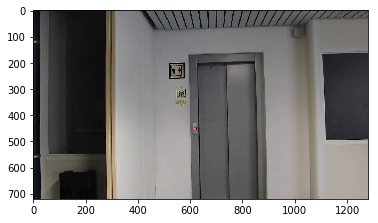

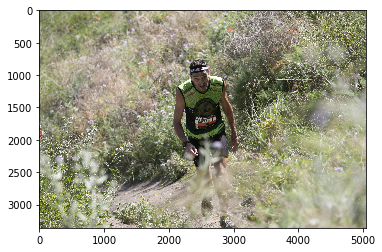

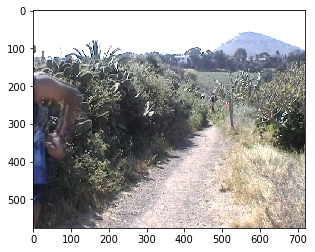

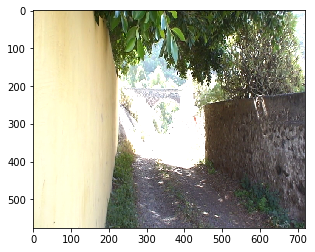

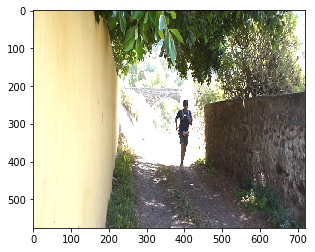

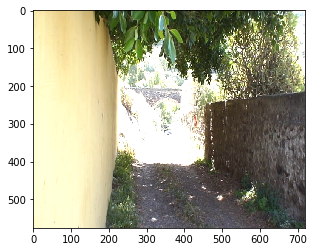

In [19]:
from random import randint

for i in range(no_videos):
    total_frames = videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT)
    actual_frame = randint(0, total_frames)
    
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, actual_frame)
    
    ret, frame = videos['video_'+str(i+1)].read()
    img = cv.cvtColor(frame, cv.COLOR_BGR2RGBA)
    h,w = img.shape[:2]
    
    plt.imshow(img,cmap='gray')
    plt.show()

### Inferencia de puntos clave de la cara con MTCNN

La librería [_MTCNN_](https://github.com/ipazc/mtcnn) ofrece un modelo preentrenado con la red _FaceNet_. Para poder utilizar todas las funcionalidades que esta librería aporta deberemos importar la librería.

In [20]:
from mtcnn.mtcnn import MTCNN

Inicializamos un objeto de la clase _MTCNN_.

In [21]:
detector = MTCNN()

#### Redimensión de frames de vídeo

Se procederá a implementar una pequeña función que que toma como entrada un frame de vídeo y lo redimensionará, conservando la proporción del mismo, a un tamaño máximo de 800x600 píxeles, siempre y cuando el frame de entrada supere dichas dimensiones. La redimensión de la imagen conlleva una interpolación de área de la imagen resultante (_cv.INTER_\__AREA_).

In [22]:
def define_size(inSize, outSize=(800,600)):
    w, h = inSize
    
    if w > outSize[0]:
        scaling = outSize[0] / w
        w = int(w * scaling)
        h = int(h * scaling)
        
    if h > outSize[1]:
        scaling = outSize[1] / h
        w = int(w * scaling)
        h = int(h * scaling)
        
    return (w, h)

In [23]:
def resize_frame(frame, inSize, outSize=(800,600)):
    dim = define_size(inSize, outSize)
    
    return cv.resize(frame, dim, interpolation=cv.INTER_AREA)

#### Inferencias de puntos claves de la cara con _MTCNN_

Se procede a implementar una pequeña función responsable de generar los puntos clave de la cara de cada fotograma de vídeo que se le pasa como argumento a la misma. Además, esta función reescalará cada frame a la dimensión indicada por el parámetro _size_.

In [24]:
def infere(frame, detector, inSize, outSize=(800,600)):
    return detector.detect_faces(resize_frame(frame, inSize, outSize))

#### Generando resultados

El objetivo de este apartado consiste en generar un un fichero _JSON_ por fotograma de vídeo con toda la información relativa a los puntos de interés de la cara detectada por la red [_MTCNN_](https://github.com/ipazc/mtcnn). Deberemos importar además él módulo [_json_](https://docs.python.org/2/library/json.html) de Python.

In [25]:
import json
from datetime import date

today = date.today()
d1 = today.strftime("%d.%m.%Y")

OUT_PATH = "out/mtcnn_" + d1 + "/"

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

for i, file_i in enumerate(video_files):
    file_i = os.path.splitext(os.path.split(file_i)[1])[0]
    
    if not os.path.exists(OUT_PATH + "video/"):
        os.mkdir(OUT_PATH + "video/")
        
    if not os.path.exists(OUT_PATH + "json/"):
        os.mkdir(OUT_PATH + "json/")
    
    if not os.path.exists(OUT_PATH + "video/" + file_i):
        os.mkdir(OUT_PATH + "video/" + file_i)
    
    if not os.path.exists(OUT_PATH +"json/" + file_i):
        os.mkdir(OUT_PATH + "json/" + file_i)
    
    total_frames = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT))
    w = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_HEIGHT))
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, 0)
    
    for j in range(total_frames):
        ret, frame = videos['video_'+str(i+1)].read()
        data = infere(frame, detector, (w,h))
        
        json_name = f'mtcnn_{file_i}_{j:09}.json'
        
        with open(OUT_PATH + "json/" + file_i + "/" + json_name, "w") as write_file:
            json.dump(data, write_file)

[]
[]
[]
[]
[]
[{'box': [456, 200, 11, 16], 'confidence': 0.8172281980514526, 'keypoints': {'left_eye': (459, 207), 'right_eye': (464, 206), 'nose': (461, 210), 'mouth_left': (461, 214), 'mouth_right': (465, 213)}}]
[]
[{'box': [456, 199, 12, 17], 'confidence': 0.8562870025634766, 'keypoints': {'left_eye': (458, 206), 'right_eye': (464, 205), 'nose': (461, 209), 'mouth_left': (460, 213), 'mouth_right': (465, 212)}}]
[{'box': [456, 197, 12, 17], 'confidence': 0.7667577862739563, 'keypoints': {'left_eye': (458, 205), 'right_eye': (464, 204), 'nose': (461, 208), 'mouth_left': (460, 212), 'mouth_right': (465, 211)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [455, 196, 13, 17], 'confidence': 0.8627781271934509, 'keypoints': {'left_eye': (458, 204), 'right_eye': (463, 203), 'nose': (460, 207), 'mouth_left': (459, 211), 'mouth_right': (463, 210)}}]
[]
[{'box': [453, 197, 12, 17], 'confidence': 0.7129599452018738, 'keypoints': {'left_eye': (456, 205), 'right_eye': (461, 204), 'nose': (458, 208),

[{'box': [353, 203, 18, 23], 'confidence': 0.9760939478874207, 'keypoints': {'left_eye': (358, 212), 'right_eye': (367, 212), 'nose': (362, 218), 'mouth_left': (360, 222), 'mouth_right': (367, 222)}}]
[{'box': [352, 202, 19, 25], 'confidence': 0.951646089553833, 'keypoints': {'left_eye': (357, 212), 'right_eye': (366, 211), 'nose': (362, 218), 'mouth_left': (359, 222), 'mouth_right': (367, 221)}}]
[{'box': [352, 202, 19, 25], 'confidence': 0.9306848645210266, 'keypoints': {'left_eye': (357, 212), 'right_eye': (366, 211), 'nose': (362, 218), 'mouth_left': (359, 222), 'mouth_right': (367, 221)}}]
[{'box': [352, 202, 19, 25], 'confidence': 0.9694973826408386, 'keypoints': {'left_eye': (357, 212), 'right_eye': (366, 211), 'nose': (361, 218), 'mouth_left': (359, 223), 'mouth_right': (366, 222)}}]
[{'box': [352, 202, 19, 25], 'confidence': 0.9707828164100647, 'keypoints': {'left_eye': (356, 212), 'right_eye': (365, 211), 'nose': (360, 218), 'mouth_left': (358, 222), 'mouth_right': (365, 221)

[{'box': [354, 204, 26, 33], 'confidence': 0.9914131164550781, 'keypoints': {'left_eye': (361, 217), 'right_eye': (375, 216), 'nose': (368, 225), 'mouth_left': (363, 231), 'mouth_right': (374, 231)}}]
[{'box': [356, 204, 27, 35], 'confidence': 0.9965368509292603, 'keypoints': {'left_eye': (363, 217), 'right_eye': (377, 216), 'nose': (370, 225), 'mouth_left': (364, 232), 'mouth_right': (376, 232)}}]
[{'box': [357, 204, 27, 34], 'confidence': 0.9874920845031738, 'keypoints': {'left_eye': (366, 216), 'right_eye': (380, 216), 'nose': (372, 225), 'mouth_left': (366, 231), 'mouth_right': (378, 231)}}]
[{'box': [359, 203, 27, 35], 'confidence': 0.9953452944755554, 'keypoints': {'left_eye': (368, 217), 'right_eye': (381, 217), 'nose': (374, 226), 'mouth_left': (368, 232), 'mouth_right': (379, 233)}}]
[{'box': [360, 203, 28, 37], 'confidence': 0.9955756664276123, 'keypoints': {'left_eye': (368, 217), 'right_eye': (382, 218), 'nose': (375, 226), 'mouth_left': (368, 232), 'mouth_right': (380, 234

[{'box': [403, 26, 26, 35], 'confidence': 0.9769313931465149, 'keypoints': {'left_eye': (410, 39), 'right_eye': (422, 37), 'nose': (416, 45), 'mouth_left': (413, 54), 'mouth_right': (422, 53)}}]
[{'box': [403, 26, 26, 34], 'confidence': 0.990535318851471, 'keypoints': {'left_eye': (410, 39), 'right_eye': (423, 37), 'nose': (417, 45), 'mouth_left': (412, 54), 'mouth_right': (422, 53)}}]
[{'box': [403, 26, 26, 34], 'confidence': 0.9899768233299255, 'keypoints': {'left_eye': (410, 39), 'right_eye': (423, 37), 'nose': (417, 45), 'mouth_left': (412, 54), 'mouth_right': (422, 53)}}]
[{'box': [403, 26, 26, 36], 'confidence': 0.9764012694358826, 'keypoints': {'left_eye': (410, 39), 'right_eye': (422, 38), 'nose': (416, 45), 'mouth_left': (413, 55), 'mouth_right': (422, 54)}}]
[{'box': [402, 25, 26, 35], 'confidence': 0.9905247092247009, 'keypoints': {'left_eye': (410, 39), 'right_eye': (423, 38), 'nose': (417, 45), 'mouth_left': (413, 54), 'mouth_right': (423, 53)}}]
[{'box': [402, 25, 26, 35]

[{'box': [423, 88, 37, 50], 'confidence': 0.9919374585151672, 'keypoints': {'left_eye': (433, 106), 'right_eye': (450, 104), 'nose': (441, 116), 'mouth_left': (436, 127), 'mouth_right': (450, 126)}}]
[]
[{'box': [426, 98, 39, 52], 'confidence': 0.9669660329818726, 'keypoints': {'left_eye': (435, 119), 'right_eye': (453, 114), 'nose': (444, 127), 'mouth_left': (442, 141), 'mouth_right': (456, 137)}}]
[{'box': [430, 103, 40, 53], 'confidence': 0.9935490489006042, 'keypoints': {'left_eye': (440, 122), 'right_eye': (459, 119), 'nose': (449, 132), 'mouth_left': (444, 145), 'mouth_right': (460, 143)}}]
[{'box': [432, 106, 43, 56], 'confidence': 0.9668692350387573, 'keypoints': {'left_eye': (442, 127), 'right_eye': (462, 123), 'nose': (451, 137), 'mouth_left': (448, 151), 'mouth_right': (463, 147)}}]
[{'box': [434, 107, 43, 55], 'confidence': 0.9738091230392456, 'keypoints': {'left_eye': (444, 128), 'right_eye': (464, 125), 'nose': (453, 137), 'mouth_left': (449, 152), 'mouth_right': (465, 14

[{'box': [438, -4, 89, 115], 'confidence': 0.9292446970939636, 'keypoints': {'left_eye': (470, 33), 'right_eye': (512, 33), 'nose': (493, 59), 'mouth_left': (471, 83), 'mouth_right': (504, 85)}}]
[]
[{'box': [444, -3, 90, 115], 'confidence': 0.9458767175674438, 'keypoints': {'left_eye': (478, 33), 'right_eye': (520, 34), 'nose': (501, 59), 'mouth_left': (478, 83), 'mouth_right': (511, 85)}}]
[{'box': [447, -3, 90, 113], 'confidence': 0.9433277249336243, 'keypoints': {'left_eye': (482, 33), 'right_eye': (524, 35), 'nose': (505, 59), 'mouth_left': (480, 82), 'mouth_right': (514, 85)}}]
[{'box': [451, -4, 89, 114], 'confidence': 0.9705442190170288, 'keypoints': {'left_eye': (486, 33), 'right_eye': (527, 35), 'nose': (510, 60), 'mouth_left': (485, 82), 'mouth_right': (519, 85)}}]
[]
[]
[]
[{'box': [459, -3, 90, 113], 'confidence': 0.8593553304672241, 'keypoints': {'left_eye': (496, 32), 'right_eye': (537, 34), 'nose': (519, 60), 'mouth_left': (494, 82), 'mouth_right': (526, 85)}}]
[{'box':

[{'box': [388, 170, 60, 74], 'confidence': 0.9560924768447876, 'keypoints': {'left_eye': (410, 193), 'right_eye': (437, 197), 'nose': (424, 208), 'mouth_left': (408, 224), 'mouth_right': (430, 227)}}]
[{'box': [382, 168, 63, 75], 'confidence': 0.9820898771286011, 'keypoints': {'left_eye': (404, 193), 'right_eye': (432, 195), 'nose': (417, 208), 'mouth_left': (402, 225), 'mouth_right': (425, 227)}}]
[{'box': [378, 166, 63, 77], 'confidence': 0.935033917427063, 'keypoints': {'left_eye': (399, 192), 'right_eye': (427, 194), 'nose': (412, 207), 'mouth_left': (398, 225), 'mouth_right': (420, 227)}}]
[{'box': [378, 169, 55, 67], 'confidence': 0.997708797454834, 'keypoints': {'left_eye': (396, 191), 'right_eye': (421, 194), 'nose': (407, 206), 'mouth_left': (395, 220), 'mouth_right': (415, 223)}}]
[{'box': [378, 171, 53, 64], 'confidence': 0.9971621632575989, 'keypoints': {'left_eye': (394, 192), 'right_eye': (418, 194), 'nose': (405, 205), 'mouth_left': (393, 219), 'mouth_right': (412, 222)}

[{'box': [352, 161, 57, 68], 'confidence': 0.9988106489181519, 'keypoints': {'left_eye': (369, 184), 'right_eye': (396, 186), 'nose': (381, 198), 'mouth_left': (370, 214), 'mouth_right': (391, 215)}}]
[{'box': [353, 159, 58, 69], 'confidence': 0.9986989498138428, 'keypoints': {'left_eye': (370, 182), 'right_eye': (396, 184), 'nose': (382, 196), 'mouth_left': (371, 212), 'mouth_right': (392, 213)}}]
[{'box': [354, 159, 58, 68], 'confidence': 0.9992067217826843, 'keypoints': {'left_eye': (372, 182), 'right_eye': (399, 184), 'nose': (384, 195), 'mouth_left': (372, 211), 'mouth_right': (394, 213)}}]
[{'box': [354, 157, 59, 71], 'confidence': 0.9991151690483093, 'keypoints': {'left_eye': (373, 181), 'right_eye': (400, 183), 'nose': (386, 194), 'mouth_left': (374, 211), 'mouth_right': (396, 213)}}]
[{'box': [355, 157, 61, 71], 'confidence': 0.9990087747573853, 'keypoints': {'left_eye': (373, 181), 'right_eye': (403, 181), 'nose': (388, 194), 'mouth_left': (376, 211), 'mouth_right': (398, 212

[{'box': [394, 87, 78, 92], 'confidence': 0.995197594165802, 'keypoints': {'left_eye': (419, 118), 'right_eye': (453, 118), 'nose': (436, 133), 'mouth_left': (422, 155), 'mouth_right': (450, 157)}}]
[{'box': [390, 83, 80, 91], 'confidence': 0.9955950379371643, 'keypoints': {'left_eye': (415, 114), 'right_eye': (452, 115), 'nose': (435, 129), 'mouth_left': (419, 152), 'mouth_right': (448, 153)}}]
[{'box': [388, 78, 78, 93], 'confidence': 0.9977856874465942, 'keypoints': {'left_eye': (414, 110), 'right_eye': (451, 112), 'nose': (433, 127), 'mouth_left': (417, 149), 'mouth_right': (445, 152)}}]
[{'box': [386, 76, 79, 92], 'confidence': 0.9973860383033752, 'keypoints': {'left_eye': (411, 107), 'right_eye': (448, 109), 'nose': (430, 124), 'mouth_left': (414, 146), 'mouth_right': (442, 148)}}]
[{'box': [384, 72, 79, 94], 'confidence': 0.9980694651603699, 'keypoints': {'left_eye': (409, 105), 'right_eye': (446, 106), 'nose': (427, 121), 'mouth_left': (412, 144), 'mouth_right': (441, 146)}}]
[

[{'box': [436, 7, 101, 121], 'confidence': 0.9900563955307007, 'keypoints': {'left_eye': (469, 48), 'right_eye': (517, 54), 'nose': (491, 69), 'mouth_left': (467, 97), 'mouth_right': (506, 102)}}]
[{'box': [438, 6, 108, 124], 'confidence': 0.9984520673751831, 'keypoints': {'left_eye': (472, 48), 'right_eye': (521, 51), 'nose': (496, 71), 'mouth_left': (471, 97), 'mouth_right': (512, 101)}}]
[{'box': [442, 4, 110, 128], 'confidence': 0.9964637160301208, 'keypoints': {'left_eye': (478, 47), 'right_eye': (526, 52), 'nose': (500, 69), 'mouth_left': (476, 99), 'mouth_right': (515, 103)}}]
[{'box': [449, 7, 102, 121], 'confidence': 0.996526300907135, 'keypoints': {'left_eye': (483, 47), 'right_eye': (530, 52), 'nose': (505, 69), 'mouth_left': (481, 95), 'mouth_right': (520, 101)}}]
[{'box': [455, 7, 99, 122], 'confidence': 0.997474730014801, 'keypoints': {'left_eye': (488, 48), 'right_eye': (534, 54), 'nose': (509, 70), 'mouth_left': (486, 99), 'mouth_right': (525, 105)}}]
[{'box': [454, 8, 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [476, 100, 43, 55], 'confidence': 0.9990897178649902, 'keypoints': {'left_eye': (490, 122), 'right_eye': (509, 119), 'nose': (502, 131), 'mouth_left': (495, 144), 'mouth_right': (512, 141)}}]
[{'box': [471, 98, 46, 57], 'confidence': 0.997061550617218, 'keypoints': {'left_eye': (484, 122), 'right_eye': (504, 118), 'nose': (496, 131), 'mouth_left': (491, 144), 'mouth_right': (507, 140)}}]
[{'box': [466, 98, 43, 54], 'confidence': 0.999321460723877, 'keypoints': {'left_eye': (480, 121), 'right_eye': (499, 117), 'nose': (493, 130), 'mouth_left': (487, 143), 'mouth_right': (503, 140)}}]
[{'box': [463, 95, 43, 57], 'confidence': 0.9992170333862305, 'keypoints': {'left_eye': (476, 120), 'right_eye': (495, 116), 'nose': (489, 129), 'mouth_left': (482, 142), 'mouth_right': (498, 138)}}]
[{'box': [460, 97, 44, 55], 'confidence': 0.9992713332176208, 'keypoints': {'left_eye': (474, 121), 'right_eye': (493, 116), 'nose': (487, 130), 'mouth_left': (482, 143), 'mouth_right': (497, 139)}}]
[

[{'box': [477, 99, 42, 55], 'confidence': 0.992024302482605, 'keypoints': {'left_eye': (488, 121), 'right_eye': (507, 117), 'nose': (499, 130), 'mouth_left': (494, 143), 'mouth_right': (509, 141)}}]
[{'box': [476, 98, 43, 55], 'confidence': 0.9860308170318604, 'keypoints': {'left_eye': (488, 120), 'right_eye': (508, 117), 'nose': (499, 129), 'mouth_left': (494, 142), 'mouth_right': (509, 140)}}]
[{'box': [476, 96, 43, 56], 'confidence': 0.9972923398017883, 'keypoints': {'left_eye': (488, 119), 'right_eye': (508, 116), 'nose': (499, 129), 'mouth_left': (493, 142), 'mouth_right': (508, 140)}}]
[{'box': [475, 95, 43, 57], 'confidence': 0.9994280934333801, 'keypoints': {'left_eye': (488, 117), 'right_eye': (508, 116), 'nose': (498, 129), 'mouth_left': (491, 139), 'mouth_right': (508, 138)}}]
[{'box': [477, 94, 41, 55], 'confidence': 0.9993334412574768, 'keypoints': {'left_eye': (489, 116), 'right_eye': (508, 115), 'nose': (499, 127), 'mouth_left': (492, 138), 'mouth_right': (507, 137)}}]
[

[{'box': [480, 96, 43, 56], 'confidence': 0.9992055296897888, 'keypoints': {'left_eye': (494, 118), 'right_eye': (514, 117), 'nose': (504, 129), 'mouth_left': (497, 139), 'mouth_right': (514, 139)}}]
[{'box': [480, 96, 43, 55], 'confidence': 0.9994240999221802, 'keypoints': {'left_eye': (494, 118), 'right_eye': (514, 116), 'nose': (505, 128), 'mouth_left': (497, 139), 'mouth_right': (514, 139)}}]
[{'box': [480, 95, 43, 57], 'confidence': 0.9993983507156372, 'keypoints': {'left_eye': (494, 117), 'right_eye': (514, 116), 'nose': (505, 128), 'mouth_left': (497, 140), 'mouth_right': (515, 139)}}]
[{'box': [480, 95, 44, 57], 'confidence': 0.9995768666267395, 'keypoints': {'left_eye': (494, 118), 'right_eye': (514, 116), 'nose': (505, 128), 'mouth_left': (497, 140), 'mouth_right': (514, 139)}}]
[{'box': [480, 95, 44, 56], 'confidence': 0.9992846846580505, 'keypoints': {'left_eye': (495, 118), 'right_eye': (515, 117), 'nose': (506, 128), 'mouth_left': (497, 139), 'mouth_right': (515, 139)}}]


[{'box': [376, 205, 40, 48], 'confidence': 0.9998399019241333, 'keypoints': {'left_eye': (386, 221), 'right_eye': (405, 222), 'nose': (395, 233), 'mouth_left': (387, 241), 'mouth_right': (403, 243)}}, {'box': [216, 208, 37, 49], 'confidence': 0.9996659755706787, 'keypoints': {'left_eye': (225, 226), 'right_eye': (243, 226), 'nose': (232, 236), 'mouth_left': (225, 245), 'mouth_right': (242, 245)}}, {'box': [533, 192, 41, 51], 'confidence': 0.9968599081039429, 'keypoints': {'left_eye': (544, 213), 'right_eye': (563, 210), 'nose': (554, 222), 'mouth_left': (547, 231), 'mouth_right': (566, 229)}}]
[{'box': [428, 225, 22, 27], 'confidence': 0.9994922876358032, 'keypoints': {'left_eye': (435, 237), 'right_eye': (446, 236), 'nose': (441, 243), 'mouth_left': (436, 247), 'mouth_right': (446, 246)}}, {'box': [282, 207, 26, 33], 'confidence': 0.9990636706352234, 'keypoints': {'left_eye': (290, 218), 'right_eye': (303, 219), 'nose': (296, 227), 'mouth_left': (289, 232), 'mouth_right': (301, 233)}}

[{'box': [676, 2, 102, 127], 'confidence': 0.9998719692230225, 'keypoints': {'left_eye': (725, 59), 'right_eye': (765, 47), 'nose': (766, 72), 'mouth_left': (744, 106), 'mouth_right': (778, 93)}}, {'box': [167, 160, 38, 43], 'confidence': 0.9815234541893005, 'keypoints': {'left_eye': (181, 177), 'right_eye': (199, 175), 'nose': (192, 187), 'mouth_left': (184, 196), 'mouth_right': (198, 194)}}, {'box': [470, 335, 42, 49], 'confidence': 0.933922529220581, 'keypoints': {'left_eye': (480, 356), 'right_eye': (501, 351), 'nose': (492, 362), 'mouth_left': (485, 378), 'mouth_right': (503, 375)}}]
[{'box': [369, 168, 27, 37], 'confidence': 0.9990228414535522, 'keypoints': {'left_eye': (373, 180), 'right_eye': (386, 183), 'nose': (374, 188), 'mouth_left': (371, 194), 'mouth_right': (384, 197)}}, {'box': [8, 164, 69, 93], 'confidence': 0.9579392671585083, 'keypoints': {'left_eye': (17, 202), 'right_eye': (44, 198), 'nose': (21, 220), 'mouth_left': (22, 241), 'mouth_right': (45, 239)}}]
[]
[{'box'

[{'box': [345, 143, 86, 103], 'confidence': 0.9963623881340027, 'keypoints': {'left_eye': (369, 180), 'right_eye': (410, 176), 'nose': (391, 197), 'mouth_left': (371, 217), 'mouth_right': (412, 214)}}, {'box': [445, 97, 55, 66], 'confidence': 0.9958844780921936, 'keypoints': {'left_eye': (465, 119), 'right_eye': (490, 119), 'nose': (479, 132), 'mouth_left': (465, 147), 'mouth_right': (486, 149)}}, {'box': [206, 125, 86, 100], 'confidence': 0.995026171207428, 'keypoints': {'left_eye': (228, 161), 'right_eye': (268, 155), 'nose': (251, 174), 'mouth_left': (238, 203), 'mouth_right': (269, 199)}}, {'box': [555, 95, 58, 73], 'confidence': 0.966155469417572, 'keypoints': {'left_eye': (568, 122), 'right_eye': (596, 121), 'nose': (579, 135), 'mouth_left': (570, 154), 'mouth_right': (593, 152)}}, {'box': [595, 166, 75, 97], 'confidence': 0.9412842988967896, 'keypoints': {'left_eye': (622, 200), 'right_eye': (657, 197), 'nose': (648, 219), 'mouth_left': (630, 243), 'mouth_right': (659, 241)}}]
[

[]
[{'box': [377, 185, 32, 38], 'confidence': 0.9995322227478027, 'keypoints': {'left_eye': (384, 198), 'right_eye': (400, 197), 'nose': (392, 207), 'mouth_left': (384, 212), 'mouth_right': (401, 211)}}, {'box': [118, 407, 25, 34], 'confidence': 0.7500665187835693, 'keypoints': {'left_eye': (128, 419), 'right_eye': (138, 419), 'nose': (134, 424), 'mouth_left': (130, 432), 'mouth_right': (138, 432)}}]
[]
[{'box': [724, 231, 20, 25], 'confidence': 0.9954386353492737, 'keypoints': {'left_eye': (727, 240), 'right_eye': (737, 240), 'nose': (730, 244), 'mouth_left': (727, 249), 'mouth_right': (735, 250)}}, {'box': [473, 224, 13, 15], 'confidence': 0.7847701907157898, 'keypoints': {'left_eye': (476, 230), 'right_eye': (482, 229), 'nose': (478, 233), 'mouth_left': (476, 237), 'mouth_right': (481, 237)}}]
[{'box': [437, 380, 12, 16], 'confidence': 0.9854310750961304, 'keypoints': {'left_eye': (441, 386), 'right_eye': (447, 386), 'nose': (445, 390), 'mouth_left': (441, 393), 'mouth_right': (447,

[]
[{'box': [385, 147, 35, 43], 'confidence': 0.9996296167373657, 'keypoints': {'left_eye': (395, 163), 'right_eye': (412, 162), 'nose': (404, 173), 'mouth_left': (397, 181), 'mouth_right': (411, 180)}}]
[{'box': [356, 139, 58, 69], 'confidence': 0.9998518228530884, 'keypoints': {'left_eye': (371, 163), 'right_eye': (398, 162), 'nose': (383, 180), 'mouth_left': (369, 187), 'mouth_right': (400, 186)}}]
[{'box': [361, 150, 31, 37], 'confidence': 0.9809324741363525, 'keypoints': {'left_eye': (367, 161), 'right_eye': (382, 161), 'nose': (374, 170), 'mouth_left': (370, 178), 'mouth_right': (382, 178)}}]
[]
[{'box': [398, 217, 24, 29], 'confidence': 0.9916398525238037, 'keypoints': {'left_eye': (406, 227), 'right_eye': (417, 225), 'nose': (413, 233), 'mouth_left': (409, 239), 'mouth_right': (418, 238)}}]
[{'box': [426, 215, 12, 16], 'confidence': 0.8903717398643494, 'keypoints': {'left_eye': (428, 221), 'right_eye': (433, 219), 'nose': (431, 224), 'mouth_left': (430, 228), 'mouth_right': (43

[{'box': [440, 139, 19, 22], 'confidence': 0.9910695552825928, 'keypoints': {'left_eye': (443, 147), 'right_eye': (451, 146), 'nose': (445, 151), 'mouth_left': (444, 157), 'mouth_right': (451, 155)}}, {'box': [568, 150, 28, 35], 'confidence': 0.9239223599433899, 'keypoints': {'left_eye': (580, 163), 'right_eye': (591, 163), 'nose': (588, 170), 'mouth_left': (580, 177), 'mouth_right': (588, 176)}}]
[{'box': [447, 156, 20, 26], 'confidence': 0.7374168634414673, 'keypoints': {'left_eye': (453, 165), 'right_eye': (462, 164), 'nose': (457, 171), 'mouth_left': (453, 177), 'mouth_right': (461, 177)}}]
[{'box': [206, 322, 14, 18], 'confidence': 0.9968619346618652, 'keypoints': {'left_eye': (210, 329), 'right_eye': (218, 328), 'nose': (215, 333), 'mouth_left': (211, 336), 'mouth_right': (218, 336)}}, {'box': [129, 294, 17, 21], 'confidence': 0.9965123534202576, 'keypoints': {'left_eye': (134, 302), 'right_eye': (142, 303), 'nose': (137, 306), 'mouth_left': (133, 310), 'mouth_right': (141, 311)}

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [462, 219, 21, 26], 'confidence': 0.7328963875770569, 'keypoints': {'left_eye': (471, 228), 'right_eye': (477, 231), 'nose': (473, 235), 'mouth_left': (468, 237), 'mouth_right': (474, 239)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [455, 218, 29, 39], 'confidence': 0.9036990404129028, 'keypoints': {'left_eye': (465, 229), 'right_eye': (475, 228), 'nose': (471, 235), 'mouth_left': (466, 241), 'mouth_right': (475, 240)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [447, 219, 23, 29], 'confidence': 0.7841492295265198, 'keypoints': {'left_eye': (455, 228), 'right_eye': (464, 228), 'nose': (459, 235), 'mouth_left': (456, 240), 'mouth_right': (463, 240)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [419, 211, 40, 51], 'confidence': 0.7290008068084717, 'keypoints': {'left_eye': (434, 228), 'right_eye': (445, 223), 'nose': (442, 235), 'mouth_left': (437, 242), 'mouth_right': (447, 238)}}]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [440, 214, 23, 30], 'confidence': 0.7554017305374146, 'keypoints': {'left_eye': (452, 223), 'right_eye': (459, 223), 'nose': (458, 231), 'mouth_left': (452, 236), 'mouth_right': (458, 235)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [402, 317, 22, 26], 'confidence': 0.7293689250946045, 'keypoints': {'left_eye': (414, 326), 'right_eye': (423, 327), 'nose': (421, 333), 'mouth_left': (413, 337), 'mouth_right': (420, 338)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [121, 186, 21, 27], 'confidence': 0.7993550896644592, 'keypoints': {'left_eye': (132, 195), 'right_eye': (141, 195), 'nose': (138, 200), 'mouth_left': (132, 206), 'mouth_right': (138, 207)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [384, 188, 15, 22], 'confidence': 0.8576852083206177, 'keypoints': {'left_eye': (387, 196), 'right_eye': (393, 194), 'nose': (389, 198), 'mouth_left': (388, 205), 'mouth_right': (394, 204)}}]
[]
[{'box': [384, 186, 16, 23], 'confidence': 

[{'box': [63, 211, 119, 149], 'confidence': 0.7606993317604065, 'keypoints': {'left_eye': (124, 273), 'right_eye': (164, 260), 'nose': (159, 302), 'mouth_left': (129, 329), 'mouth_right': (164, 320)}}]
[]
[{'box': [14, 102, 69, 92], 'confidence': 0.8301820755004883, 'keypoints': {'left_eye': (20, 139), 'right_eye': (47, 136), 'nose': (22, 159), 'mouth_left': (21, 177), 'mouth_right': (44, 175)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [117, 385, 21, 27], 'confidence': 0.9243333339691162, 'keypoints': {'left_eye': (120, 395), 'right_eye': (130, 393), 'nose': (124, 399), 'mouth_left': (122, 407), 'mouth_right': (131, 406)}}]
[]
[]
[]
[{'box': [118, 384, 22, 27], 'confidence': 0.7666991949081421, 'keypoints': {'left_eye': (121, 394), 'right_eye': (131, 392), 'nose': (124, 399), 'mouth_left': (123, 407), 'mouth_right': (131, 406)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'

[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [119, 192, 22, 28], 'confidence': 0.7877776026725769, 'keypoints': {'left_eye': (131, 202), 'right_eye': (139, 201), 'nose': (138, 207), 'mouth_left': (132, 214), 'mouth_right': (137, 213)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [46, 286, 22, 25], 'confidence': 0.7717266082763672, 'keypoints': {'left_eye': (54, 296), 'right_eye': (62, 295), 'nose': (60, 299), 'mouth_left': (55, 305), 'mouth_right': (62, 304)}}]
[{'box': [45, 285, 23, 28], 'confidence': 0.7638170123100281, 'keypoints': {'left_eye': (53, 297), 'right_eye': (61, 296), 'nose': (59, 299), 'mouth_left': (54, 307), 'mouth_right': (61, 306)}}]
[]
[]
[]
[]
[]
[]
[{'box': [120, 200, 19, 26], 'confidence': 0.7101114392280579, 'keypoints': {'left_eye': (1

[{'box': [119, 194, 21, 28], 'confidence': 0.8248140811920166, 'keypoints': {'left_eye': (131, 203), 'right_eye': (139, 203), 'nose': (138, 208), 'mouth_left': (132, 214), 'mouth_right': (137, 214)}}, {'box': [83, 120, 18, 21], 'confidence': 0.7749907970428467, 'keypoints': {'left_eye': (92, 128), 'right_eye': (96, 129), 'nose': (95, 131), 'mouth_left': (89, 133), 'mouth_right': (93, 135)}}]
[]
[{'box': [82, 120, 18, 21], 'confidence': 0.8328332304954529, 'keypoints': {'left_eye': (92, 128), 'right_eye': (96, 130), 'nose': (95, 131), 'mouth_left': (90, 134), 'mouth_right': (93, 135)}}]
[]
[{'box': [119, 195, 21, 28], 'confidence': 0.7347591519355774, 'keypoints': {'left_eye': (131, 204), 'right_eye': (139, 204), 'nose': (138, 209), 'mouth_left': (131, 215), 'mouth_right': (137, 216)}}]
[{'box': [120, 195, 21, 28], 'confidence': 0.7997769713401794, 'keypoints': {'left_eye': (131, 204), 'right_eye': (139, 204), 'nose': (138, 209), 'mouth_left': (131, 216), 'mouth_right': (137, 216)}}]
[]

[{'box': [68, 95, 81, 99], 'confidence': 0.9455235004425049, 'keypoints': {'left_eye': (79, 140), 'right_eye': (105, 130), 'nose': (85, 157), 'mouth_left': (93, 178), 'mouth_right': (113, 170)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [40, 272, 26, 30], 'confidence': 0.7497362494468689, 'keypoints': {'left_eye': (48, 284), 'right_eye': (58, 281), 'nose': (55, 287), 'mouth_left': (51, 295), 'mouth_right': (61, 293)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [122, 190, 20, 27], 'confidence': 0.7039679884910583, 'keypoints': {'left_eye': (133, 199), 'right_eye': (140, 199), 'nose': (139, 204), 'mouth_left': (133, 211), 'mouth_right': (1

[]
[{'box': [77, 89, 61, 80], 'confidence': 0.8737041354179382, 'keypoints': {'left_eye': (82, 125), 'right_eye': (101, 118), 'nose': (83, 134), 'mouth_left': (88, 154), 'mouth_right': (103, 149)}}]
[{'box': [164, 415, 42, 47], 'confidence': 0.7478277683258057, 'keypoints': {'left_eye': (180, 434), 'right_eye': (194, 431), 'nose': (189, 442), 'mouth_left': (181, 449), 'mouth_right': (193, 446)}}]
[{'box': [351, 169, 26, 34], 'confidence': 0.918920636177063, 'keypoints': {'left_eye': (355, 180), 'right_eye': (365, 177), 'nose': (356, 184), 'mouth_left': (356, 195), 'mouth_right': (364, 193)}}, {'box': [116, 421, 76, 82], 'confidence': 0.7896999716758728, 'keypoints': {'left_eye': (152, 450), 'right_eye': (172, 446), 'nose': (166, 464), 'mouth_left': (153, 480), 'mouth_right': (170, 477)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [267, 170, 38, 50], 'confidence': 0.7982252836227417, 'keypoints': {'left_eye': (271, 188), 'right_eye': (286, 187), 'nose': (272, 199), 'mouth_le

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [393, 190, 20, 27], 'confidence': 0.7349573969841003, 'keypoints': {'left_eye': (398, 200), 'right_eye': (407, 200), 'nose': (401,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [334, 177, 29, 37], 'confidence': 0.9521231651306152, 'keypoints': {'left_eye': (338, 191), 'right_eye': (351, 189), 'nose': (342, 199), 'mouth_left': (341, 207), 'mouth_right': (350, 206)}}]
[]
[{'box': [321, 177, 29, 38], 'confidence': 0.9885513186454773, 'keypoints': {'left_eye': (327, 192), 'right_eye': (341, 190), 'nose': (333, 199), 'mouth_left': (330, 208), 'mouth_right': (340, 207)}}, {'box': [287, 279, 26, 33], 'confidence': 0.900310218334198, 'keypoints': {'left_eye': (300, 290), 'right_eye': (310, 289), 'nose': (309, 298), 'mouth_left': (300, 304), 'mouth_right': (308, 303)}}]
[{'box': [317, 169, 30, 38], 'confidence': 0.9899162650108337, 'keypoints': {'left_eye': (325, 184), 'right_eye': (339, 183), 'nose': (331, 193), 'mouth_left': (327, 200), 'mouth_right': (337, 200)}}]
[{'box': [311, 159, 31, 39], 'confidence': 0.9204919338226318, 'keypoints': {'left_eye': (320, 174), 'right_eye': (335, 172), 'nose': (328, 183), 'mouth_left': (323, 190), 'mouth_right': (335, 18

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [468, 207, 17, 22], 'confidence': 0.7207914590

[{'box': [352, 184, 17, 23], 'confidence': 0.9295049905776978, 'keypoints': {'left_eye': (356, 194), 'right_eye': (363, 193), 'nose': (359, 199), 'mouth_left': (359, 204), 'mouth_right': (364, 203)}}]
[{'box': [350, 189, 17, 25], 'confidence': 0.9462093710899353, 'keypoints': {'left_eye': (354, 199), 'right_eye': (361, 197), 'nose': (357, 204), 'mouth_left': (356, 210), 'mouth_right': (362, 208)}}]
[{'box': [347, 194, 17, 24], 'confidence': 0.9243106245994568, 'keypoints': {'left_eye': (350, 204), 'right_eye': (357, 203), 'nose': (352, 209), 'mouth_left': (351, 214), 'mouth_right': (357, 213)}}]
[]
[]
[{'box': [340, 187, 23, 31], 'confidence': 0.8456882834434509, 'keypoints': {'left_eye': (345, 200), 'right_eye': (356, 197), 'nose': (351, 206), 'mouth_left': (351, 213), 'mouth_right': (359, 211)}}]
[]
[{'box': [338, 179, 20, 27], 'confidence': 0.9225409626960754, 'keypoints': {'left_eye': (342, 189), 'right_eye': (351, 188), 'nose': (345, 195), 'mouth_left': (343, 200), 'mouth_right': 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [36, 266, 25, 30], 'confidence': 0.7433940172195435, 'keypoints': {'left_eye': (48, 277), 'right_eye': (57, 276), 'nose': (56, 280), 'mouth_left': (50, 288), 'mouth_right': (57, 288)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[{'box': [292, 175, 29, 35], 'confidence': 0.8690485954284668, 'keypoints': {'left_eye': (297, 188), 'right_eye': (310, 187), 'nose': (300, 196), 'mouth_left': (298, 205), 'mouth_right': (310, 205)}}]
[{'box': [287, 176, 32, 39], 'confidence': 0.7408966422080994, 'keypoints': {'left_eye': (296, 189), 'right_eye': (311, 188), 'nose': (301, 199), 'mouth_left': (296, 208), 'mouth_right': (309, 208)}}]
[{'box': [283, 172, 35, 42], 'confidence': 0.7667298913002014, 'keypoints': {'left_eye': (294, 187), 'right_eye': (310, 187), 'nose': (300, 199), 'mouth_left': (294, 206), 'mouth_right': (307, 207)}}]
[]
[]
[{'box': [270, 153, 36, 44], 'confidence': 0.9634838700294495, 'keypoints': {'left_eye': (278, 169), 'right_eye': (295, 169), 'nose': (284, 181), 'mouth_left': (280, 189), 'mouth_right': (294, 189)}}]
[{'box': [267, 149, 36, 45], 'confidence': 0.8417208194732666, 'keypoints': {'left_eye': (274, 166), 'right_eye': (290, 165), 'nose': (279, 178), 'mouth_left': (276, 186

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [418, 195, 17, 23], 'confidence': 0.7355690598487854, 'keypoints': {'left_eye': (422, 204), 'right_eye': (431, 203), 'nose': (426, 210), 'mouth_left': (424, 215), 'mouth_right': (431, 214)}}]
[{'box': [416, 189, 18, 24], 'confidence': 0.85605388879776, 'keypoints': {'left_eye': (421, 200), 'right_eye': (428, 198), 'nose': (424, 204), 'mouth_left': (423, 210), 'mouth_right': (429, 208)}}]
[{'box': [416, 191, 15, 21], 'confidence': 0.946756899356842, 'keypoints': {'left_eye': (421, 199), 'right_eye': (429, 198), 'nose': (425, 204), 'mouth_left': (422, 208), 'mouth_right': (429, 207)}}]
[]
[]
[]
[{'box': [410, 201, 17, 22], 'confidence': 0.8374741673469543, 'keypoints': {'left_eye': (415, 209), 'right_eye': (423, 2

[{'box': [231, 150, 44, 57], 'confidence': 0.9974700212478638, 'keypoints': {'left_eye': (243, 171), 'right_eye': (264, 170), 'nose': (254, 183), 'mouth_left': (244, 193), 'mouth_right': (264, 192)}}]
[{'box': [222, 146, 45, 57], 'confidence': 0.9962061643600464, 'keypoints': {'left_eye': (235, 168), 'right_eye': (257, 167), 'nose': (247, 181), 'mouth_left': (237, 191), 'mouth_right': (257, 190)}}]
[{'box': [214, 147, 46, 59], 'confidence': 0.998009979724884, 'keypoints': {'left_eye': (227, 170), 'right_eye': (250, 169), 'nose': (239, 183), 'mouth_left': (230, 193), 'mouth_right': (250, 191)}}]
[{'box': [206, 155, 47, 58], 'confidence': 0.9935001730918884, 'keypoints': {'left_eye': (217, 177), 'right_eye': (239, 174), 'nose': (227, 189), 'mouth_left': (221, 199), 'mouth_right': (241, 197)}}]
[{'box': [188, 152, 53, 67], 'confidence': 0.9945829510688782, 'keypoints': {'left_eye': (203, 179), 'right_eye': (227, 175), 'nose': (214, 192), 'mouth_left': (207, 205), 'mouth_right': (229, 201)

[]
[{'box': [221, 149, 40, 51], 'confidence': 0.9302206635475159, 'keypoints': {'left_eye': (228, 170), 'right_eye': (244, 168), 'nose': (232, 180), 'mouth_left': (232, 190), 'mouth_right': (245, 188)}}]
[{'box': [218, 144, 39, 49], 'confidence': 0.7819451689720154, 'keypoints': {'left_eye': (219, 167), 'right_eye': (235, 163), 'nose': (224, 173), 'mouth_left': (223, 183), 'mouth_right': (236, 181)}}]
[{'box': [209, 146, 41, 51], 'confidence': 0.9593496322631836, 'keypoints': {'left_eye': (214, 169), 'right_eye': (230, 164), 'nose': (220, 179), 'mouth_left': (221, 188), 'mouth_right': (235, 185)}}]
[{'box': [197, 149, 45, 57], 'confidence': 0.9032201170921326, 'keypoints': {'left_eye': (201, 173), 'right_eye': (218, 167), 'nose': (206, 181), 'mouth_left': (209, 194), 'mouth_right': (223, 190)}}]
[{'box': [189, 156, 43, 52], 'confidence': 0.9763199090957642, 'keypoints': {'left_eye': (195, 178), 'right_eye': (213, 175), 'nose': (201, 190), 'mouth_left': (201, 199), 'mouth_right': (215, 

[]
[{'box': [175, 527, 19, 24], 'confidence': 0.7796651721000671, 'keypoints': {'left_eye': (184, 536), 'right_eye': (191, 536), 'nose': (189, 540), 'mouth_left': (185, 545), 'mouth_right': (190, 545)}}]
[]
[{'box': [174, 528, 19, 25], 'confidence': 0.7239603996276855, 'keypoints': {'left_eye': (184, 537), 'right_eye': (191, 537), 'nose': (189, 541), 'mouth_left': (185, 546), 'mouth_right': (190, 546)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [174, 527, 19, 24], 'confidence': 0.7480246424674988, 'keypoints': {'left_eye': (183, 536), 'right_eye': (191, 536), 'nose': (189, 541), 'mouth_left': (184, 546), 'mouth_right': (190, 546)}}]
[]
[]
[]
[]
[]
[{'box': [175, 528, 18, 22], 'confidence': 0.7453314661979675, 'keypoints': {'left_eye': (183, 536), 'right_eye': (191, 536), 'nose': (188, 540), 'mouth_left': (184, 545), 'mouth_right': (189, 545)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [174, 527, 18, 23], 'confidence': 0.7003

[{'box': [317, 180, 23, 32], 'confidence': 0.9889699220657349, 'keypoints': {'left_eye': (322, 193), 'right_eye': (333, 193), 'nose': (325, 200), 'mouth_left': (322, 206), 'mouth_right': (331, 206)}}]
[{'box': [314, 183, 23, 32], 'confidence': 0.9848111867904663, 'keypoints': {'left_eye': (320, 196), 'right_eye': (331, 196), 'nose': (323, 203), 'mouth_left': (319, 209), 'mouth_right': (329, 209)}}]
[{'box': [310, 186, 24, 34], 'confidence': 0.8299033045768738, 'keypoints': {'left_eye': (315, 199), 'right_eye': (327, 200), 'nose': (319, 208), 'mouth_left': (314, 213), 'mouth_right': (323, 214)}}]
[{'box': [302, 189, 27, 38], 'confidence': 0.9260830283164978, 'keypoints': {'left_eye': (306, 203), 'right_eye': (319, 204), 'nose': (308, 212), 'mouth_left': (305, 220), 'mouth_right': (316, 221)}}]
[{'box': [298, 191, 26, 37], 'confidence': 0.9522061944007874, 'keypoints': {'left_eye': (301, 205), 'right_eye': (314, 205), 'nose': (303, 214), 'mouth_left': (301, 222), 'mouth_right': (310, 222

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [54, 116, 10, 13], 'confidence': 0.7524175643920898, 'keypoints': {'left_eye': (58, 119), 'right_eye': (63, 119), 'nose': (61, 123), 'mouth_left': (59, 126), 'mouth_right': (62, 126)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [54, 116, 12, 14], 'confidence': 0.778586745262146, 'keypoints': {'left_eye': (58, 120), 'right_eye': (63, 119), 'nose': (61, 123), 'mouth_left': (60, 127), 'mouth_right': (64, 126)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [173, 527, 22, 26], 'confidence': 0.7673824429512024, 'keypoints': {'left_eye': (18

[{'box': [393, 162, 20, 27], 'confidence': 0.8964396715164185, 'keypoints': {'left_eye': (397, 171), 'right_eye': (406, 170), 'nose': (401, 177), 'mouth_left': (399, 183), 'mouth_right': (406, 182)}}]
[{'box': [391, 165, 21, 28], 'confidence': 0.9204367995262146, 'keypoints': {'left_eye': (396, 175), 'right_eye': (405, 173), 'nose': (399, 181), 'mouth_left': (398, 187), 'mouth_right': (406, 186)}}]
[{'box': [387, 167, 22, 28], 'confidence': 0.9666002988815308, 'keypoints': {'left_eye': (392, 177), 'right_eye': (402, 176), 'nose': (396, 182), 'mouth_left': (393, 189), 'mouth_right': (402, 188)}}]
[{'box': [382, 166, 23, 31], 'confidence': 0.8886212706565857, 'keypoints': {'left_eye': (384, 176), 'right_eye': (395, 175), 'nose': (387, 183), 'mouth_left': (385, 190), 'mouth_right': (394, 190)}}]
[]
[]
[]
[{'box': [364, 152, 23, 30], 'confidence': 0.8996034860610962, 'keypoints': {'left_eye': (367, 161), 'right_eye': (378, 161), 'nose': (370, 169), 'mouth_left': (369, 175), 'mouth_right': 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [410, 193, 27, 36], 'confidence': 0.8954770565032959, 'keypoints': {'left_eye': (414, 208), 'right_eye': (425, 201), 'nose': (421, 211), 'mouth_left': (422, 222), 'mouth_right': (431, 218)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [454, 216, 26, 32], 'confidence': 0.807550311088562, 'keypoints': {'left_eye': (464, 226), 'right_eye': (472, 224), 'nose': (470, 231), 'mouth_left': (466, 237), 'mouth_right': (474, 236)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [329, 179, 16, 17], 'confidence': 0.8016580939292908, 'keypoints': {'left_eye': (333, 184), 'right_eye': (341, 184), 'nose': (337, 188), 'mouth_left': (335, 192), 'mouth_right': (341, 191)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [35, 262, 36, 42], 'confidence': 0.732

[{'box': [392, 173, 17, 21], 'confidence': 0.9694029092788696, 'keypoints': {'left_eye': (396, 181), 'right_eye': (404, 179), 'nose': (400, 184), 'mouth_left': (398, 190), 'mouth_right': (404, 189)}}]
[{'box': [390, 175, 16, 21], 'confidence': 0.9617270231246948, 'keypoints': {'left_eye': (394, 183), 'right_eye': (403, 181), 'nose': (398, 185), 'mouth_left': (395, 192), 'mouth_right': (402, 191)}}]
[{'box': [389, 177, 16, 21], 'confidence': 0.9774461388587952, 'keypoints': {'left_eye': (393, 186), 'right_eye': (401, 185), 'nose': (396, 189), 'mouth_left': (394, 195), 'mouth_right': (401, 193)}}]
[{'box': [385, 177, 17, 22], 'confidence': 0.7394101619720459, 'keypoints': {'left_eye': (388, 187), 'right_eye': (397, 185), 'nose': (392, 189), 'mouth_left': (391, 196), 'mouth_right': (397, 195)}}]
[{'box': [363, 206, 72, 96], 'confidence': 0.8505823612213135, 'keypoints': {'left_eye': (393, 239), 'right_eye': (417, 234), 'nose': (410, 254), 'mouth_left': (394, 267), 'mouth_right': (419, 263

[{'box': [188, 118, 40, 53], 'confidence': 0.849646806716919, 'keypoints': {'left_eye': (193, 135), 'right_eye': (211, 132), 'nose': (197, 144), 'mouth_left': (196, 160), 'mouth_right': (210, 158)}}]
[{'box': [173, 102, 46, 62], 'confidence': 0.9175914525985718, 'keypoints': {'left_eye': (181, 128), 'right_eye': (199, 126), 'nose': (184, 137), 'mouth_left': (182, 152), 'mouth_right': (196, 152)}}]
[{'box': [163, 106, 43, 54], 'confidence': 0.9711018800735474, 'keypoints': {'left_eye': (171, 128), 'right_eye': (189, 128), 'nose': (174, 136), 'mouth_left': (170, 149), 'mouth_right': (184, 150)}}]
[{'box': [155, 108, 41, 53], 'confidence': 0.9819573163986206, 'keypoints': {'left_eye': (161, 131), 'right_eye': (177, 129), 'nose': (163, 141), 'mouth_left': (162, 153), 'mouth_right': (175, 152)}}]
[{'box': [143, 114, 44, 57], 'confidence': 0.9914933443069458, 'keypoints': {'left_eye': (150, 138), 'right_eye': (167, 136), 'nose': (153, 149), 'mouth_left': (152, 161), 'mouth_right': (165, 160)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [262, 207, 49, 64], 'confidence': 0.8431864976882935, 'keypoints': {'left_eye': (271, 228), 'right_eye': (289, 229), 'nose': (273, 241), 'mouth_left': (270, 253), 'mouth_right': (286, 253)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [155, 308, 32, 39], 'confidence': 0.7682639360427856, 'keypoints': {'left_eye': (170, 324), 'right_eye': (185, 323), 'nose': (180, 333), 'mouth_left': (173, 341), 'mouth_right': (184, 341)}}]
[]
[]
[]
[{'box': [99, 105, 55, 65], 'confidence': 0.9774686098098755, 'keypoints': {'left_eye': (107, 129), 'right_eye': (131, 127), 'nose': (115, 145), 'mouth_left': (113, 158), 'mouth_right': (131, 156)}}, {'box': [101, 190, 90, 111], 'confidence': 0.8021450042724609, 'keypoints': {'left_eye': (121, 231), 'right_eye': (153, 225), 'nose': (133, 248), 'mouth_left': (132, 274), 'mouth_right': (158, 269)}}]
[]
[]
[{'box': [53, 95, 72, 92], 'confidence': 0.8378034234046936, 'keypoints': {'left_eye': (63, 135), 'right_eye': (90, 127), 

[{'box': [298, 176, 22, 29], 'confidence': 0.989756166934967, 'keypoints': {'left_eye': (302, 185), 'right_eye': (311, 186), 'nose': (304, 193), 'mouth_left': (302, 199), 'mouth_right': (310, 199)}}]
[{'box': [294, 174, 21, 27], 'confidence': 0.9824392795562744, 'keypoints': {'left_eye': (299, 183), 'right_eye': (310, 183), 'nose': (303, 190), 'mouth_left': (300, 195), 'mouth_right': (308, 195)}}]
[{'box': [290, 174, 22, 29], 'confidence': 0.9564983248710632, 'keypoints': {'left_eye': (295, 184), 'right_eye': (305, 184), 'nose': (298, 191), 'mouth_left': (296, 197), 'mouth_right': (305, 197)}}]
[{'box': [287, 176, 23, 30], 'confidence': 0.8619130253791809, 'keypoints': {'left_eye': (291, 187), 'right_eye': (301, 187), 'nose': (293, 194), 'mouth_left': (291, 200), 'mouth_right': (300, 201)}}]
[{'box': [283, 181, 24, 30], 'confidence': 0.9237120747566223, 'keypoints': {'left_eye': (286, 191), 'right_eye': (297, 191), 'nose': (289, 199), 'mouth_left': (288, 205), 'mouth_right': (297, 205)

[{'box': [83, 141, 41, 50], 'confidence': 0.953484296798706, 'keypoints': {'left_eye': (91, 159), 'right_eye': (109, 158), 'nose': (96, 171), 'mouth_left': (94, 182), 'mouth_right': (107, 181)}}, {'box': [318, 174, 27, 36], 'confidence': 0.8165035247802734, 'keypoints': {'left_eye': (322, 187), 'right_eye': (332, 185), 'nose': (324, 194), 'mouth_left': (323, 202), 'mouth_right': (333, 200)}}]
[{'box': [66, 142, 52, 67], 'confidence': 0.9817195534706116, 'keypoints': {'left_eye': (71, 165), 'right_eye': (91, 164), 'nose': (73, 181), 'mouth_left': (74, 197), 'mouth_right': (90, 195)}}, {'box': [316, 180, 25, 33], 'confidence': 0.933485209941864, 'keypoints': {'left_eye': (319, 193), 'right_eye': (329, 192), 'nose': (320, 201), 'mouth_left': (320, 207), 'mouth_right': (328, 206)}}, {'box': [78, 187, 39, 46], 'confidence': 0.8115343451499939, 'keypoints': {'left_eye': (82, 204), 'right_eye': (99, 202), 'nose': (86, 215), 'mouth_left': (85, 224), 'mouth_right': (99, 223)}}, {'box': [112, 26

[{'box': [203, 104, 32, 36], 'confidence': 0.9220749139785767, 'keypoints': {'left_eye': (211, 117), 'right_eye': (223, 116), 'nose': (216, 123), 'mouth_left': (212, 132), 'mouth_right': (221, 130)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [120, 189, 22, 29], 'confidence': 0.7003651857376099, 'keypoints': {'left_eye': (133, 198), 'right_eye': (141, 199), 'nose': (141, 205), 'mouth_left': (132, 211), 'mouth_right': (139, 211)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [120, 191, 21, 29], 'confidence': 0.751532256603241, 'keypoints': {'left_eye': (134, 200), 'right_eye': (141, 200), 'nose': (142, 206), 'mouth_left': (133, 213), 'mouth_right': (140, 213)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [120, 190, 21, 29], 'confidence': 0.7582215070724487, 'keypoints': {'left_eye': (134, 199), 'right_eye': (1

[{'box': [400, 175, 21, 26], 'confidence': 0.9658365249633789, 'keypoints': {'left_eye': (404, 185), 'right_eye': (415, 183), 'nose': (409, 191), 'mouth_left': (407, 197), 'mouth_right': (416, 195)}}]
[{'box': [397, 173, 20, 26], 'confidence': 0.9634935259819031, 'keypoints': {'left_eye': (401, 184), 'right_eye': (411, 182), 'nose': (405, 190), 'mouth_left': (403, 195), 'mouth_right': (412, 194)}}]
[{'box': [391, 169, 21, 27], 'confidence': 0.9534519910812378, 'keypoints': {'left_eye': (395, 180), 'right_eye': (404, 178), 'nose': (398, 185), 'mouth_left': (396, 190), 'mouth_right': (405, 189)}}]
[{'box': [386, 165, 20, 27], 'confidence': 0.9470486044883728, 'keypoints': {'left_eye': (390, 175), 'right_eye': (401, 175), 'nose': (394, 181), 'mouth_left': (391, 187), 'mouth_right': (400, 187)}}]
[{'box': [381, 163, 20, 25], 'confidence': 0.9612399935722351, 'keypoints': {'left_eye': (385, 172), 'right_eye': (394, 172), 'nose': (387, 178), 'mouth_left': (385, 184), 'mouth_right': (393, 184

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [467, 170, 19, 29], 'confidence': 0.8774598836898804, 'keypoints': {'left_eye': (471, 180), 'right_eye': (479, 180), 'nose': (473, 185), 'mouth_left': (471, 192), 'mouth_right': (476, 192)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [463, 275, 16, 19], 'confidence': 0.7496359944343567, 'keypoints': {'left_eye': (472, 282), 'right_eye': (479, 283), 'nose': (477, 288), 'mouth_left': (470, 290), 'mouth_right': (476, 291)}}, {'box': [237, 472, 17, 19], 'confidence': 0.7393990755081177, 'keypoints': {'left_eye': (242, 478), 'right_eye': (249, 478), 'nose': (245, 483), 'mouth_left': (241, 487), 'mouth_right': (247, 487)}}]
[{'box': [237, 472, 16, 19], 'confidence': 0.7736294269561768, 'keypoints': {'left_eye': (241, 478), 'right_eye': (249, 478), 'nose': (244, 483), 'mouth_left': (241, 487), 'mouth_right': (247, 487)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [33, 269, 36, 40], 'confidence': 0.8335898518562317, 'keypoints': {'left_eye': (44, 286), 'right_eye': (57, 285), 'nose': (51, 287), 'mouth_left': (45, 300), 'mouth_right': (56, 300)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [440, 250, 21, 31], 'confidence': 0.7325091361999512, 'keypoints': {'left_eye': (450, 260), 'right_eye': (458, 259), 'nose': (455, 268), 'mouth_left': (450, 275), 'mouth_right': (455, 275)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [35, 266, 34, 40], 'confidence': 0.7693391442298889, 'keypoints': {'left_eye': (45, 282), 'right_eye': (58, 282), 'nose': (52, 284), 'mouth_left': (46, 296), 'mouth_right': (58, 296)}}]
[]
[{'box': [34, 265, 37, 42], 'confidence': 0.8327842950820923, 'keypoints': {'left_eye': (43, 282), 'right_eye': (58, 281), 'nose': (50, 285), 'mouth_left': (45, 297), 'mouth_righ

[]
[{'box': [449, 209, 25, 34], 'confidence': 0.7849081158638, 'keypoints': {'left_eye': (460, 219), 'right_eye': (470, 218), 'nose': (467, 227), 'mouth_left': (461, 235), 'mouth_right': (469, 235)}}]
[{'box': [452, 211, 25, 32], 'confidence': 0.8133021593093872, 'keypoints': {'left_eye': (464, 221), 'right_eye': (474, 222), 'nose': (471, 228), 'mouth_left': (462, 235), 'mouth_right': (470, 236)}}]
[]
[{'box': [447, 210, 26, 34], 'confidence': 0.9181222915649414, 'keypoints': {'left_eye': (463, 222), 'right_eye': (472, 221), 'nose': (471, 229), 'mouth_left': (461, 236), 'mouth_right': (470, 236)}}]
[{'box': [447, 214, 28, 35], 'confidence': 0.9709893465042114, 'keypoints': {'left_eye': (464, 229), 'right_eye': (471, 227), 'nose': (472, 235), 'mouth_left': (464, 240), 'mouth_right': (470, 239)}}]
[{'box': [448, 217, 27, 36], 'confidence': 0.7056273818016052, 'keypoints': {'left_eye': (462, 229), 'right_eye': (472, 230), 'nose': (470, 238), 'mouth_left': (461, 245), 'mouth_right': (469, 

[{'box': [381, 178, 19, 26], 'confidence': 0.933526337146759, 'keypoints': {'left_eye': (386, 188), 'right_eye': (394, 187), 'nose': (389, 194), 'mouth_left': (387, 199), 'mouth_right': (395, 197)}}, {'box': [377, 205, 44, 54], 'confidence': 0.7922565937042236, 'keypoints': {'left_eye': (399, 224), 'right_eye': (413, 231), 'nose': (404, 239), 'mouth_left': (390, 247), 'mouth_right': (401, 252)}}]
[{'box': [382, 178, 18, 24], 'confidence': 0.9895915389060974, 'keypoints': {'left_eye': (387, 188), 'right_eye': (396, 188), 'nose': (391, 194), 'mouth_left': (387, 198), 'mouth_right': (395, 198)}}]
[{'box': [379, 178, 19, 27], 'confidence': 0.9641420841217041, 'keypoints': {'left_eye': (384, 188), 'right_eye': (394, 188), 'nose': (389, 195), 'mouth_left': (385, 200), 'mouth_right': (393, 199)}}]
[]
[{'box': [346, 215, 45, 52], 'confidence': 0.9004862904548645, 'keypoints': {'left_eye': (351, 239), 'right_eye': (363, 230), 'nose': (352, 240), 'mouth_left': (359, 257), 'mouth_right': (370, 24

[{'box': [252, 205, 65, 80], 'confidence': 0.9725677371025085, 'keypoints': {'left_eye': (285, 235), 'right_eye': (306, 241), 'nose': (298, 255), 'mouth_left': (276, 263), 'mouth_right': (294, 268)}}, {'box': [228, 201, 51, 66], 'confidence': 0.7920594215393066, 'keypoints': {'left_eye': (235, 223), 'right_eye': (254, 218), 'nose': (240, 230), 'mouth_left': (243, 252), 'mouth_right': (259, 248)}}]
[{'box': [222, 198, 49, 67], 'confidence': 0.9635891318321228, 'keypoints': {'left_eye': (228, 224), 'right_eye': (242, 216), 'nose': (233, 230), 'mouth_left': (240, 251), 'mouth_right': (249, 244)}}, {'box': [236, 154, 38, 49], 'confidence': 0.8101086020469666, 'keypoints': {'left_eye': (240, 173), 'right_eye': (256, 172), 'nose': (243, 183), 'mouth_left': (241, 195), 'mouth_right': (253, 194)}}, {'box': [36, 266, 35, 40], 'confidence': 0.7300018072128296, 'keypoints': {'left_eye': (45, 282), 'right_eye': (59, 281), 'nose': (52, 284), 'mouth_left': (47, 295), 'mouth_right': (58, 295)}}]
[{'b

[{'box': [407, 179, 19, 27], 'confidence': 0.7821853756904602, 'keypoints': {'left_eye': (413, 191), 'right_eye': (422, 189), 'nose': (419, 196), 'mouth_left': (416, 202), 'mouth_right': (423, 201)}}]
[{'box': [403, 176, 21, 27], 'confidence': 0.7695848941802979, 'keypoints': {'left_eye': (408, 187), 'right_eye': (417, 186), 'nose': (411, 192), 'mouth_left': (409, 197), 'mouth_right': (416, 196)}}]
[]
[{'box': [398, 171, 19, 25], 'confidence': 0.8199126124382019, 'keypoints': {'left_eye': (403, 180), 'right_eye': (412, 180), 'nose': (407, 186), 'mouth_left': (403, 190), 'mouth_right': (411, 190)}}]
[{'box': [395, 170, 20, 27], 'confidence': 0.8675898313522339, 'keypoints': {'left_eye': (400, 181), 'right_eye': (409, 181), 'nose': (404, 188), 'mouth_left': (401, 192), 'mouth_right': (409, 191)}}]
[{'box': [394, 173, 19, 26], 'confidence': 0.889448344707489, 'keypoints': {'left_eye': (398, 183), 'right_eye': (407, 182), 'nose': (403, 190), 'mouth_left': (400, 194), 'mouth_right': (408, 1

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [444, 237, 27, 35], 'confidence': 0.9067765474319458, 'keypoints': {'left_eye': (449, 250), 'right_eye': (460, 247), 'nose': (452, 255), 'mouth_left': (451, 266), 'mouth_right': (460, 264)}}, {'box': [421, 322, 27, 32], 'confidence': 0.725887656211853, 'keypoints': {'left_eye': (433, 332), 'right_eye': (444, 332), 'nose': (440, 338), 'mouth_left': (433, 346), 'mouth_right': (442, 346)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [267, 180, 21, 24], 'confidence': 0.8403201103210449, 'keypoints': {'left_eye': (277, 187), 'right_eye': (281, 187), 'nose': (281, 192), 'mouth_left': (278, 197), 'mouth_right': (282, 197)}}]
[]
[]
[]


[]
[{'box': [395, 221, 37, 44], 'confidence': 0.8889099955558777, 'keypoints': {'left_eye': (415, 240), 'right_eye': (427, 243), 'nose': (424, 252), 'mouth_left': (411, 257), 'mouth_right': (419, 258)}}]
[]
[{'box': [381, 218, 36, 43], 'confidence': 0.7513777017593384, 'keypoints': {'left_eye': (395, 231), 'right_eye': (406, 231), 'nose': (398, 240), 'mouth_left': (395, 250), 'mouth_right': (403, 251)}}]
[{'box': [389, 216, 34, 43], 'confidence': 0.7002935409545898, 'keypoints': {'left_eye': (409, 233), 'right_eye': (418, 240), 'nose': (412, 244), 'mouth_left': (400, 249), 'mouth_right': (407, 254)}}]
[]
[{'box': [389, 222, 37, 43], 'confidence': 0.7992018461227417, 'keypoints': {'left_eye': (407, 243), 'right_eye': (420, 243), 'nose': (416, 253), 'mouth_left': (405, 260), 'mouth_right': (414, 260)}}]
[]
[]
[]
[{'box': [363, 195, 68, 84], 'confidence': 0.8236510753631592, 'keypoints': {'left_eye': (386, 226), 'right_eye': (417, 220), 'nose': (408, 244), 'mouth_left': (395, 266), 'mouth

[{'box': [282, 171, 31, 40], 'confidence': 0.9878314137458801, 'keypoints': {'left_eye': (289, 185), 'right_eye': (305, 184), 'nose': (295, 195), 'mouth_left': (292, 203), 'mouth_right': (304, 203)}}]
[{'box': [278, 171, 32, 42], 'confidence': 0.9926319122314453, 'keypoints': {'left_eye': (284, 186), 'right_eye': (300, 185), 'nose': (290, 197), 'mouth_left': (287, 205), 'mouth_right': (299, 204)}}, {'box': [272, 203, 76, 92], 'confidence': 0.7679425477981567, 'keypoints': {'left_eye': (303, 234), 'right_eye': (332, 229), 'nose': (324, 250), 'mouth_left': (305, 277), 'mouth_right': (329, 273)}}]
[{'box': [272, 175, 32, 40], 'confidence': 0.9840854406356812, 'keypoints': {'left_eye': (279, 189), 'right_eye': (294, 189), 'nose': (284, 200), 'mouth_left': (280, 208), 'mouth_right': (291, 208)}}, {'box': [245, 219, 112, 122], 'confidence': 0.8864713907241821, 'keypoints': {'left_eye': (290, 269), 'right_eye': (323, 256), 'nose': (318, 285), 'mouth_left': (303, 310), 'mouth_right': (332, 298

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [87, 116, 15, 19], 'confidence': 0.918677806854248, 'keypoints': {'left_eye': (95, 121), 'right_eye': (100, 123), 'nose': (98, 125), 'mouth_left': (92, 128), 'mouth_right': (96, 130)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [203, 176, 48, 60], 'confidence': 0.7448378801345825, 'keypoints': {'left_eye': (210, 199), 'right_eye': (227, 194), 'nose': (216, 207), 'mouth_left': (216, 223), 'mouth_right': (228, 218)}}]
[{'box': [198, 182, 43, 52], 'confidence': 0.7772852778434753, 'keypoints': {'left_eye': (204, 202), 'right_eye': (221, 197), 'nose': (211, 208), 'mouth_left': (209, 224), 'mouth_right': (222, 220)}}]
[{'box': [191, 184, 41, 50], 'confidence': 0.9806339740753174, 'keypoints': {'left_eye': (199, 203), 'right_eye': (216, 200), 'nose': (205, 212), 'mouth_left': (203, 224), 'mouth_right': (216, 221)}}, {'box': [202, 281, 28, 35], 'confidence': 0.7331615686416626, 'keypoints': {'left_eye': (212, 293), 'right_eye': (223, 292), 'nose': (219, 300), 'mouth_left': (212, 308), 'mouth_right': (222, 308)}}]
[{'box': [176, 179, 44, 59], 'confidence': 0.8896512389183044, 'keypoints': {'left_eye': (183, 201), 'right_eye': (204, 199), 'nose': (192, 212), 'mouth_left': (188, 227), 'mouth_right': (204, 225)

[]
[]
[{'box': [336, 165, 27, 32], 'confidence': 0.8765367269515991, 'keypoints': {'left_eye': (341, 178), 'right_eye': (353, 176), 'nose': (345, 182), 'mouth_left': (344, 191), 'mouth_right': (353, 189)}}]
[{'box': [331, 170, 27, 32], 'confidence': 0.9808751344680786, 'keypoints': {'left_eye': (337, 182), 'right_eye': (349, 180), 'nose': (342, 187), 'mouth_left': (340, 195), 'mouth_right': (349, 194)}}, {'box': [340, 278, 26, 29], 'confidence': 0.7013441324234009, 'keypoints': {'left_eye': (348, 290), 'right_eye': (358, 288), 'nose': (353, 296), 'mouth_left': (350, 302), 'mouth_right': (358, 300)}}]
[]
[{'box': [322, 174, 27, 33], 'confidence': 0.9313079118728638, 'keypoints': {'left_eye': (328, 186), 'right_eye': (341, 184), 'nose': (334, 191), 'mouth_left': (329, 200), 'mouth_right': (341, 199)}}]
[]
[]
[{'box': [313, 159, 29, 36], 'confidence': 0.757338285446167, 'keypoints': {'left_eye': (318, 172), 'right_eye': (330, 168), 'nose': (323, 177), 'mouth_left': (322, 188), 'mouth_righ

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [408, 180, 18, 23], 'confidence': 0.8543731570243835, 'keypoints': {'left_eye': (413, 189), 'right_eye': (421, 188), 'nose': (417, 194), 'mouth_left': (415, 200), 'mouth_right': (421, 200)}}]
[]
[{'box': [396, 214, 20, 26], 'confidence': 0.8103747367858887, 'keypoints': {'left_eye': (400, 224), 'right_eye': (406, 221), 'nose': (402, 228), 'mouth_left': (403, 235), 'mouth_right': (408, 233)}}]
[]
[]
[]
[]
[]
[]
[{'box': [383, 210, 35, 48], 'confidence': 0.7637127041816711, 'keypoints': {'left_eye': (392, 222), 'right_eye': (405, 220), 'nose': (398, 229), 'mouth_left': (396, 242), 'mouth_right': (406, 241)}}]
[{'box': [382, 206, 34, 42], 'confidence': 0.7882860898971558, 'keypoints': {'left_eye': (390, 219), 'right_eye': (404, 215), 'nose': (397, 224), 'mouth_left': (396, 237), 'mouth_right': (406, 235)}}]
[{'box': [381, 204, 33, 43], 'confidence': 0.800554633140564, 'keypoints': {'left_eye': (39

[]
[]
[{'box': [4, 109, 67, 77], 'confidence': 0.7005993127822876, 'keypoints': {'left_eye': (14, 136), 'right_eye': (38, 133), 'nose': (17, 153), 'mouth_left': (18, 169), 'mouth_right': (38, 167)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [417, 229, 12, 15], 'confidence': 0.8277333378791809, 'keypoints': {'left_eye': (418, 234), 'right_eye': (424, 232), 'nose': (422, 237), 'mouth_left': (422, 242), 'mouth_right': (426, 240)}}]
[]
[]
[]
[]
[]
[{'box': [411, 219, 20, 24], 'confidence': 0.7237820029258728, 'keypoints': {'left_eye': (417, 227), 'right_eye': (424, 224), 'nose': (422, 229), 'mouth_left': (421, 237), 'mouth_right': (426, 235)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [218, 151, 17, 20], 'confidence': 0.7346135377883911, 'k

[{'box': [233, 147, 31, 41], 'confidence': 0.9953711628913879, 'keypoints': {'left_eye': (238, 162), 'right_eye': (252, 162), 'nose': (242, 173), 'mouth_left': (240, 180), 'mouth_right': (250, 180)}}]
[{'box': [221, 146, 35, 47], 'confidence': 0.9813054203987122, 'keypoints': {'left_eye': (225, 165), 'right_eye': (239, 165), 'nose': (227, 177), 'mouth_left': (228, 186), 'mouth_right': (239, 185)}}]
[{'box': [217, 151, 34, 46], 'confidence': 0.9876601099967957, 'keypoints': {'left_eye': (221, 168), 'right_eye': (234, 169), 'nose': (223, 180), 'mouth_left': (222, 186), 'mouth_right': (232, 187)}}]
[{'box': [212, 155, 34, 46], 'confidence': 0.9974024891853333, 'keypoints': {'left_eye': (217, 172), 'right_eye': (231, 172), 'nose': (220, 183), 'mouth_left': (219, 191), 'mouth_right': (230, 191)}}]
[{'box': [202, 155, 38, 51], 'confidence': 0.9924697279930115, 'keypoints': {'left_eye': (207, 176), 'right_eye': (223, 174), 'nose': (210, 186), 'mouth_left': (209, 196), 'mouth_right': (222, 196

[{'box': [153, 434, 24, 30], 'confidence': 0.9596365094184875, 'keypoints': {'left_eye': (167, 445), 'right_eye': (174, 443), 'nose': (175, 449), 'mouth_left': (169, 456), 'mouth_right': (174, 454)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [121, 192, 22, 28], 'confidence': 0.7953017950057983, 'keypoints': {'left_eye': (133, 200), 'right_eye': (141, 201), 'nose': (140, 207), 'mouth_left': (133, 212), 'mouth_right': (139, 213)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [208, 221, 16, 21], 'confidence': 0.7128397226333618, 'keypoints': {'left_eye': (214, 229), 'right_eye': (222, 227), 'nose': (220, 233), 'mouth_left': (216, 239), 'mouth_right': (223, 238)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [382, 188, 15, 21], 'confidence': 0.704416811466217, 'keypoints': {'left_eye': (386, 196), 'right_eye': (394, 196), 'nose': (389, 200), 'mouth_left': (387, 205), 'mouth_right': (393, 205)}}]
[]
[{'box': [382, 187, 15, 21], 'confidence': 0.7354583740234375, 'keypoints': {'left_eye': (386, 194), 'right_eye': (394, 194), 'nose': (389, 198), 'mouth_left': (387, 203), 'mouth_right': (393, 203)}}]
[]
[]
[{'box': [381, 178, 16, 22], 'confidence': 0.8622556924819946, 'keypoints': {'left_eye': (386, 187), 'right_eye': (394, 187), 'nose': (389, 191), 'mouth_left': (387, 196), 'mouth_right': (393, 196)}}]
[{'box': [382, 179, 15, 20], 'confidence': 0.8427387475967407, 'keypoints': {'left_eye': (386, 188), 'right_eye': (394, 187), 'nose': (389, 191), 'mouth_left': (387, 196), 'mouth_right': (393, 196)}}]
[{'box': [383, 181, 15, 21], 'confidence': 0.9489286541938782, 'keypoints': {'left_eye': (387, 190), 'right_eye': (394, 190), 'nose': (390, 

[{'box': [188, 118, 43, 61], 'confidence': 0.9815296530723572, 'keypoints': {'left_eye': (196, 142), 'right_eye': (217, 141), 'nose': (203, 155), 'mouth_left': (199, 168), 'mouth_right': (215, 168)}}]
[{'box': [179, 121, 45, 61], 'confidence': 0.9964750409126282, 'keypoints': {'left_eye': (185, 146), 'right_eye': (205, 145), 'nose': (190, 159), 'mouth_left': (189, 171), 'mouth_right': (204, 171)}}]
[{'box': [168, 134, 43, 57], 'confidence': 0.9891098737716675, 'keypoints': {'left_eye': (173, 156), 'right_eye': (190, 153), 'nose': (175, 167), 'mouth_left': (175, 180), 'mouth_right': (189, 179)}}]
[{'box': [152, 130, 48, 69], 'confidence': 0.9353454113006592, 'keypoints': {'left_eye': (156, 157), 'right_eye': (174, 155), 'nose': (157, 171), 'mouth_left': (161, 185), 'mouth_right': (175, 183)}}]
[{'box': [142, 129, 48, 70], 'confidence': 0.9344907999038696, 'keypoints': {'left_eye': (148, 157), 'right_eye': (168, 156), 'nose': (152, 170), 'mouth_left': (150, 184), 'mouth_right': (166, 184

[{'box': [287, 161, 32, 43], 'confidence': 0.9598687887191772, 'keypoints': {'left_eye': (292, 180), 'right_eye': (307, 177), 'nose': (298, 189), 'mouth_left': (297, 197), 'mouth_right': (308, 195)}}]
[{'box': [279, 168, 35, 46], 'confidence': 0.9884372353553772, 'keypoints': {'left_eye': (286, 186), 'right_eye': (303, 182), 'nose': (293, 195), 'mouth_left': (290, 205), 'mouth_right': (303, 203)}}]
[{'box': [278, 171, 34, 44], 'confidence': 0.9839000701904297, 'keypoints': {'left_eye': (285, 190), 'right_eye': (299, 186), 'nose': (290, 199), 'mouth_left': (289, 208), 'mouth_right': (301, 205)}}]
[{'box': [269, 171, 35, 46], 'confidence': 0.9419137835502625, 'keypoints': {'left_eye': (277, 190), 'right_eye': (293, 187), 'nose': (284, 200), 'mouth_left': (282, 210), 'mouth_right': (295, 207)}}]
[{'box': [260, 166, 37, 51], 'confidence': 0.7898715734481812, 'keypoints': {'left_eye': (265, 184), 'right_eye': (281, 183), 'nose': (270, 194), 'mouth_left': (268, 207), 'mouth_right': (280, 206

[{'box': [425, 219, 47, 58], 'confidence': 0.9448449015617371, 'keypoints': {'left_eye': (445, 244), 'right_eye': (465, 244), 'nose': (458, 259), 'mouth_left': (445, 268), 'mouth_right': (461, 267)}}]
[{'box': [434, 194, 15, 21], 'confidence': 0.8700228333473206, 'keypoints': {'left_eye': (438, 202), 'right_eye': (445, 201), 'nose': (441, 206), 'mouth_left': (440, 211), 'mouth_right': (445, 210)}}]
[]
[]
[]
[{'box': [411, 196, 53, 68], 'confidence': 0.7160677909851074, 'keypoints': {'left_eye': (417, 211), 'right_eye': (440, 207), 'nose': (423, 224), 'mouth_left': (422, 240), 'mouth_right': (444, 237)}}]
[]
[{'box': [405, 197, 60, 77], 'confidence': 0.8000302314758301, 'keypoints': {'left_eye': (414, 217), 'right_eye': (440, 210), 'nose': (423, 230), 'mouth_left': (423, 251), 'mouth_right': (446, 245)}}]
[{'box': [419, 197, 17, 21], 'confidence': 0.7625688314437866, 'keypoints': {'left_eye': (423, 206), 'right_eye': (430, 206), 'nose': (425, 211), 'mouth_left': (423, 215), 'mouth_right

[{'box': [266, 162, 39, 53], 'confidence': 0.9677643179893494, 'keypoints': {'left_eye': (273, 184), 'right_eye': (291, 181), 'nose': (280, 193), 'mouth_left': (277, 206), 'mouth_right': (290, 203)}}]
[]
[{'box': [248, 166, 41, 55], 'confidence': 0.9321660399436951, 'keypoints': {'left_eye': (256, 188), 'right_eye': (272, 187), 'nose': (260, 199), 'mouth_left': (257, 211), 'mouth_right': (269, 210)}}]
[]
[]
[{'box': [210, 141, 43, 56], 'confidence': 0.9125084280967712, 'keypoints': {'left_eye': (215, 164), 'right_eye': (231, 163), 'nose': (216, 176), 'mouth_left': (217, 188), 'mouth_right': (229, 188)}}]
[{'box': [194, 132, 45, 59], 'confidence': 0.9204105734825134, 'keypoints': {'left_eye': (198, 157), 'right_eye': (216, 156), 'nose': (200, 169), 'mouth_left': (202, 181), 'mouth_right': (215, 180)}}, {'box': [197, 501, 41, 55], 'confidence': 0.8533547520637512, 'keypoints': {'left_eye': (213, 520), 'right_eye': (229, 517), 'nose': (225, 532), 'mouth_left': (218, 545), 'mouth_right': (

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [459, 228, 16, 21], 'confidence': 0.8829651474952698, 'keypoints': {'left_eye': (465, 236), 'right_eye': (473, 235), 'nose': (471, 241), 'mouth_left': (467, 246), 'mouth_right': (473, 245)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [75, 195, 23, 28], 'confidence': 0.7537453174591064, 'keypoints': {'left_eye': 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [206, 104, 29, 31], 'confidence': 0.8580281138420105, 'keypoints': {'left_eye': (214, 117), 'right_eye': (222, 113), 'nose': (217, 119), 'mouth_left': (216, 126), 'mouth_right': (221, 123)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [209, 105, 26, 28], 'confidence': 0.7325896620750427, 'keypoints': {'left_eye': (214, 117), 'right_eye': (223, 116), 'nose': (216, 121), 'mouth_left': (214, 126), 'mouth_right': (220, 125)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [460, 218, 20, 24], 'confidence': 0.7657009959220886, 'keypoints': {'left_eye': (465, 227), 'right_eye': (474, 223), 'nose': (472, 230), 'mouth_left': (470, 237), 'mouth_right': (478, 234

[{'box': [243, 179, 32, 38], 'confidence': 0.9545176029205322, 'keypoints': {'left_eye': (247, 193), 'right_eye': (261, 190), 'nose': (252, 203), 'mouth_left': (251, 210), 'mouth_right': (262, 208)}}]
[{'box': [235, 183, 33, 42], 'confidence': 0.9946574568748474, 'keypoints': {'left_eye': (239, 198), 'right_eye': (254, 195), 'nose': (244, 208), 'mouth_left': (244, 217), 'mouth_right': (256, 215)}}]
[{'box': [228, 186, 36, 42], 'confidence': 0.986049234867096, 'keypoints': {'left_eye': (234, 202), 'right_eye': (248, 198), 'nose': (238, 211), 'mouth_left': (239, 221), 'mouth_right': (252, 218)}}, {'box': [455, 212, 27, 33], 'confidence': 0.8237437605857849, 'keypoints': {'left_eye': (462, 222), 'right_eye': (475, 217), 'nose': (472, 227), 'mouth_left': (467, 236), 'mouth_right': (477, 232)}}]
[{'box': [227, 186, 32, 39], 'confidence': 0.9876861572265625, 'keypoints': {'left_eye': (232, 198), 'right_eye': (247, 196), 'nose': (237, 208), 'mouth_left': (236, 216), 'mouth_right': (248, 215)}

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [250, 177, 42, 46], 'confidence': 0.8371809124946594, 'keypoints': {'left_eye': (261, 195), 'right_eye': (276, 190), 'nose': (269, 197), 'mouth_left': (266, 211), 'mouth_right': (277, 207)}}]
[]
[]
[]
[]
[]
[]
[{'box': [226, 530, 14, 20], 'confidence': 0.7543357014656067, 'keypoints': {'left_eye': (232, 538), 'right_eye': (238, 537), 'nose': (237, 542), 'mouth_left': (234, 547), 'mouth_right': (238, 546)}}]
[]
[]
[{'box': [119, 279, 133, 162], 'confidence': 0.8163040280342102, 'keypoints': {'left_eye': (135, 342), 'right_eye': (180, 328), 'nose': (144, 365), 'mouth_left': (152, 406), 'mouth_right': (191, 396)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[{'box': [456, 219, 18, 25], 'confidence': 0.8166034817695618, 'keypoints': {'left_eye': (465, 228), 'right_eye': (472, 227), 'nose': (471, 233), 'mouth_left': (465, 239), 'mouth_right': (471, 239)}}, {'box': [402, 190, 29, 40], 'confidence': 0.7598084807395935, 'keypoints': {'left_eye': (404, 204), 'right_eye': (412, 203), 'nose': (401, 211), 'mouth_left': (403, 222), 'mouth_right': (411, 221)}}]
[]
[]
[{'box': [400, 190, 15, 21], 'confidence': 0.7261748909950256, 'keypoints': {'left_eye': (404, 198), 'right_eye': (412, 198), 'nose': (407, 203), 'mouth_left': (404, 207), 'mouth_right': (411, 207)}}]
[]
[{'box': [396, 195, 16, 22], 'confidence': 0.9197337031364441, 'keypoints': {'left_eye': (400, 202), 'right_eye': (409, 203), 'nose': (404, 208), 'mouth_left': (400, 212), 'mouth_right': (408, 213)}}]
[{'box': [395, 193, 16, 21], 'confidence': 0.9556547999382019, 'keypoints': {'left_eye': (399, 201), 'right_eye': (408, 201), 'nose': (403, 206), 'mouth_left': (400, 210), 'mouth_right': (

[{'box': [326, 170, 24, 31], 'confidence': 0.9901083707809448, 'keypoints': {'left_eye': (331, 181), 'right_eye': (344, 181), 'nose': (335, 189), 'mouth_left': (333, 195), 'mouth_right': (343, 195)}}, {'box': [317, 180, 42, 59], 'confidence': 0.7650838494300842, 'keypoints': {'left_eye': (336, 200), 'right_eye': (347, 200), 'nose': (337, 209), 'mouth_left': (332, 224), 'mouth_right': (341, 225)}}]
[{'box': [316, 167, 32, 40], 'confidence': 0.9753520488739014, 'keypoints': {'left_eye': (323, 183), 'right_eye': (338, 183), 'nose': (329, 192), 'mouth_left': (324, 200), 'mouth_right': (337, 199)}}]
[{'box': [311, 172, 30, 38], 'confidence': 0.990183413028717, 'keypoints': {'left_eye': (318, 187), 'right_eye': (331, 187), 'nose': (323, 196), 'mouth_left': (319, 203), 'mouth_right': (331, 203)}}]
[]
[{'box': [296, 165, 31, 41], 'confidence': 0.931636393070221, 'keypoints': {'left_eye': (301, 181), 'right_eye': (314, 181), 'nose': (304, 189), 'mouth_left': (301, 198), 'mouth_right': (312, 198

[{'box': [418, 218, 29, 38], 'confidence': 0.7807449698448181, 'keypoints': {'left_eye': (433, 232), 'right_eye': (444, 233), 'nose': (442, 241), 'mouth_left': (432, 249), 'mouth_right': (441, 249)}}]
[{'box': [416, 219, 36, 41], 'confidence': 0.9318078756332397, 'keypoints': {'left_eye': (435, 236), 'right_eye': (444, 236), 'nose': (443, 244), 'mouth_left': (434, 250), 'mouth_right': (441, 249)}}]
[]
[]
[]
[{'box': [411, 213, 33, 41], 'confidence': 0.907767653465271, 'keypoints': {'left_eye': (426, 226), 'right_eye': (436, 223), 'nose': (433, 235), 'mouth_left': (430, 246), 'mouth_right': (437, 243)}}]
[]
[]
[]
[]
[]
[{'box': [408, 216, 31, 42], 'confidence': 0.7204301357269287, 'keypoints': {'left_eye': (422, 232), 'right_eye': (434, 227), 'nose': (432, 240), 'mouth_left': (428, 252), 'mouth_right': (437, 249)}}]
[]
[{'box': [407, 213, 38, 45], 'confidence': 0.8351147174835205, 'keypoints': {'left_eye': (429, 231), 'right_eye': (441, 233), 'nose': (438, 242), 'mouth_left': (426, 248)

[{'box': [334, 195, 70, 83], 'confidence': 0.9022268056869507, 'keypoints': {'left_eye': (370, 234), 'right_eye': (390, 229), 'nose': (389, 249), 'mouth_left': (371, 265), 'mouth_right': (386, 260)}}]
[{'box': [334, 206, 68, 80], 'confidence': 0.8292216062545776, 'keypoints': {'left_eye': (368, 242), 'right_eye': (388, 234), 'nose': (388, 256), 'mouth_left': (372, 271), 'mouth_right': (387, 264)}}]
[{'box': [334, 319, 24, 28], 'confidence': 0.9365750551223755, 'keypoints': {'left_eye': (345, 330), 'right_eye': (355, 330), 'nose': (350, 335), 'mouth_left': (343, 340), 'mouth_right': (352, 341)}}]
[{'box': [328, 168, 28, 36], 'confidence': 0.9755538702011108, 'keypoints': {'left_eye': (332, 182), 'right_eye': (344, 180), 'nose': (335, 190), 'mouth_left': (335, 197), 'mouth_right': (344, 196)}}, {'box': [327, 202, 68, 82], 'confidence': 0.7257498502731323, 'keypoints': {'left_eye': (363, 236), 'right_eye': (385, 234), 'nose': (380, 252), 'mouth_left': (361, 267), 'mouth_right': (377, 264)

[{'box': [156, 102, 55, 67], 'confidence': 0.9268982410430908, 'keypoints': {'left_eye': (167, 127), 'right_eye': (191, 124), 'nose': (174, 142), 'mouth_left': (171, 156), 'mouth_right': (190, 154)}}, {'box': [106, 181, 100, 121], 'confidence': 0.7626256942749023, 'keypoints': {'left_eye': (123, 234), 'right_eye': (151, 217), 'nose': (128, 246), 'mouth_left': (142, 280), 'mouth_right': (162, 266)}}]
[{'box': [145, 106, 60, 77], 'confidence': 0.982783317565918, 'keypoints': {'left_eye': (154, 134), 'right_eye': (180, 130), 'nose': (160, 150), 'mouth_left': (158, 168), 'mouth_right': (179, 166)}}, {'box': [142, 183, 131, 155], 'confidence': 0.8389827013015747, 'keypoints': {'left_eye': (214, 255), 'right_eye': (252, 252), 'nose': (250, 287), 'mouth_left': (208, 311), 'mouth_right': (237, 309)}}]
[{'box': [130, 103, 65, 81], 'confidence': 0.9710786938667297, 'keypoints': {'left_eye': (140, 131), 'right_eye': (169, 130), 'nose': (148, 150), 'mouth_left': (144, 167), 'mouth_right': (167, 16

[{'box': [379, 153, 26, 33], 'confidence': 0.9964984655380249, 'keypoints': {'left_eye': (384, 164), 'right_eye': (396, 163), 'nose': (389, 173), 'mouth_left': (386, 179), 'mouth_right': (396, 179)}}]
[{'box': [379, 151, 25, 31], 'confidence': 0.9965224266052246, 'keypoints': {'left_eye': (383, 161), 'right_eye': (395, 159), 'nose': (388, 170), 'mouth_left': (386, 176), 'mouth_right': (396, 175)}}]
[{'box': [376, 150, 26, 31], 'confidence': 0.9938073754310608, 'keypoints': {'left_eye': (382, 161), 'right_eye': (393, 160), 'nose': (387, 169), 'mouth_left': (384, 175), 'mouth_right': (393, 175)}}]
[{'box': [372, 151, 26, 32], 'confidence': 0.9933745265007019, 'keypoints': {'left_eye': (378, 161), 'right_eye': (390, 160), 'nose': (383, 170), 'mouth_left': (381, 176), 'mouth_right': (390, 175)}}]
[{'box': [368, 153, 28, 36], 'confidence': 0.9837865233421326, 'keypoints': {'left_eye': (373, 165), 'right_eye': (386, 164), 'nose': (378, 175), 'mouth_left': (376, 182), 'mouth_right': (386, 182

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [33, 295, 17, 21], 'confidence': 0.8061522841453552, 'keypoints': {'left_eye': (35, 301), 'right_eye': (42, 301), 'nose': (35, 306), 'mouth_left': (35, 311), 'mouth_right': (40, 311)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [451, 221, 21, 28], 'confidence': 0.723708987236023, 'keypoints': {'left_eye': (460, 232), 'right_eye': (468, 230), 'nose': (466, 237), 'mouth_left': (460, 244), 'mouth_right': (467, 243)}}]
[]
[]
[]
[]
[]
[]
[{'box': [444, 219, 24, 30], 'confidence': 0.7044952511787415, 'keypoints': {'left_eye': (456, 232), 'right_eye': (464, 230), 'nose': (463, 237), 'mouth_left': (458, 243), 'mouth_right': (465, 241)}}]
[{'box': [442, 217, 25, 33], 'confidence': 0.7469672560691833, 'keypoints': {'left_eye': (455, 232), 'right_eye': (463, 230), 'nose': (462, 236), 'mouth_left': (456, 245), 'mouth_right': (462, 242)}}]
[]
[]
[]
[]
[]
[]
[{'box': [60, 334, 20, 25], 'confidence': 0.8558562994003296, 'keypoints': {'left_eye': (72, 343), 'right_eye': (80, 343), 'nose': (79, 350), 'mouth_left': (72, 355), 'mouth_right': (78, 356)}}]
[]
[]
[{'box': [441, 214, 21, 29], 'confidence': 0.857721209526062, 'keypoints': {'left_eye': (452, 225), 'right_eye': (461, 224), 'nose': (458, 231), 'mouth_left': (4

[]
[]
[{'box': [373, 222, 37, 45], 'confidence': 0.8956069946289062, 'keypoints': {'left_eye': (394, 244), 'right_eye': (401, 244), 'nose': (400, 253), 'mouth_left': (392, 259), 'mouth_right': (397, 259)}}, {'box': [381, 197, 16, 21], 'confidence': 0.8850491046905518, 'keypoints': {'left_eye': (384, 206), 'right_eye': (392, 205), 'nose': (388, 211), 'mouth_left': (386, 215), 'mouth_right': (391, 215)}}]
[{'box': [361, 215, 36, 49], 'confidence': 0.737162709236145, 'keypoints': {'left_eye': (366, 234), 'right_eye': (375, 230), 'nose': (368, 236), 'mouth_left': (371, 251), 'mouth_right': (377, 248)}}]
[{'box': [380, 197, 16, 21], 'confidence': 0.9384200572967529, 'keypoints': {'left_eye': (383, 205), 'right_eye': (391, 204), 'nose': (387, 210), 'mouth_left': (385, 214), 'mouth_right': (391, 213)}}, {'box': [368, 221, 43, 56], 'confidence': 0.7071043252944946, 'keypoints': {'left_eye': (388, 244), 'right_eye': (402, 238), 'nose': (401, 251), 'mouth_left': (394, 267), 'mouth_right': (404, 

[{'box': [324, 180, 25, 37], 'confidence': 0.9649124145507812, 'keypoints': {'left_eye': (330, 195), 'right_eye': (343, 195), 'nose': (335, 204), 'mouth_left': (331, 209), 'mouth_right': (342, 209)}}, {'box': [310, 220, 62, 80], 'confidence': 0.8861876726150513, 'keypoints': {'left_eye': (333, 254), 'right_eye': (356, 247), 'nose': (351, 266), 'mouth_left': (342, 286), 'mouth_right': (360, 280)}}]
[{'box': [322, 176, 25, 36], 'confidence': 0.9485553503036499, 'keypoints': {'left_eye': (327, 191), 'right_eye': (340, 190), 'nose': (332, 199), 'mouth_left': (329, 205), 'mouth_right': (339, 205)}}]
[{'box': [319, 172, 26, 38], 'confidence': 0.9747112989425659, 'keypoints': {'left_eye': (325, 188), 'right_eye': (338, 187), 'nose': (331, 196), 'mouth_left': (327, 202), 'mouth_right': (338, 202)}}, {'box': [307, 211, 58, 73], 'confidence': 0.8475209474563599, 'keypoints': {'left_eye': (333, 237), 'right_eye': (351, 234), 'nose': (341, 247), 'mouth_left': (330, 270), 'mouth_right': (344, 266)}

[{'box': [234, 176, 39, 48], 'confidence': 0.8195260763168335, 'keypoints': {'left_eye': (240, 200), 'right_eye': (256, 195), 'nose': (245, 209), 'mouth_left': (245, 218), 'mouth_right': (258, 214)}}, {'box': [420, 208, 13, 16], 'confidence': 0.7846878170967102, 'keypoints': {'left_eye': (423, 214), 'right_eye': (430, 213), 'nose': (426, 218), 'mouth_left': (424, 221), 'mouth_right': (429, 221)}}]
[]
[{'box': [230, 185, 38, 47], 'confidence': 0.9386788606643677, 'keypoints': {'left_eye': (237, 205), 'right_eye': (254, 204), 'nose': (243, 216), 'mouth_left': (240, 224), 'mouth_right': (254, 223)}}, {'box': [420, 206, 14, 16], 'confidence': 0.8499112725257874, 'keypoints': {'left_eye': (424, 213), 'right_eye': (430, 212), 'nose': (427, 217), 'mouth_left': (425, 219), 'mouth_right': (430, 219)}}, {'box': [236, 323, 43, 60], 'confidence': 0.7282492518424988, 'keypoints': {'left_eye': (246, 351), 'right_eye': (265, 350), 'nose': (254, 358), 'mouth_left': (250, 374), 'mouth_right': (265, 373

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [363, 222, 17, 25], 'confidence': 0.8889500498771667, 'keypoints': {'left_eye': (366, 231), 'right_eye': (373, 229), 'nose': (367, 235), 'mouth_left': (367, 241), 'mouth_right': (373, 240)}}]
[]
[]
[]
[]
[]
[{'box': [377, 198, 19, 25], 'confidence': 0.7694024443626404, 'keypoints': {'left_eye': (382, 207), 'right_eye': (391, 207), 'nose': (386, 213), 'mouth_left': (382, 219), 'mouth_right': (390, 218)}}]
[{'box': [377, 198, 19, 23], 'confidence': 0.7523154616355896, 'keypoints': {'left_eye': (382, 207), 'right_eye': (391, 206), 'nose': (386, 213), 'mouth_left': (383, 217), 'mouth_right': (391, 216)}}]
[{'box': [377, 197, 18, 23], 'confidence': 0.8504440188407898, 'keypoints': {'left_eye': (382, 205), 'right_eye': (391, 205), 'nose': (386, 212), 'mouth_left': (383, 216), 'mouth_right': (391, 216)}}]
[{'box': [375, 191, 21, 27], 'confidence': 0.8577460646629333, 'keypoints': {'left_eye': (378, 201), 'right_eye': (388, 199), 'nose': (382, 206),

[{'box': [441, 203, 34, 39], 'confidence': 0.9582662582397461, 'keypoints': {'left_eye': (460, 222), 'right_eye': (466, 220), 'nose': (469, 230), 'mouth_left': (461, 235), 'mouth_right': (465, 232)}}, {'box': [242, 163, 35, 46], 'confidence': 0.8023653626441956, 'keypoints': {'left_eye': (250, 179), 'right_eye': (262, 179), 'nose': (251, 188), 'mouth_left': (248, 198), 'mouth_right': (259, 198)}}]
[{'box': [238, 158, 33, 41], 'confidence': 0.7692272067070007, 'keypoints': {'left_eye': (243, 172), 'right_eye': (255, 172), 'nose': (243, 180), 'mouth_left': (244, 190), 'mouth_right': (253, 189)}}, {'box': [228, 323, 29, 40], 'confidence': 0.7131228446960449, 'keypoints': {'left_eye': (240, 339), 'right_eye': (250, 342), 'nose': (244, 346), 'mouth_left': (237, 352), 'mouth_right': (246, 354)}}]
[{'box': [235, 275, 60, 73], 'confidence': 0.8032458424568176, 'keypoints': {'left_eye': (248, 310), 'right_eye': (269, 297), 'nose': (258, 321), 'mouth_left': (260, 336), 'mouth_right': (276, 325)}

[{'box': [300, 168, 35, 42], 'confidence': 0.9580855369567871, 'keypoints': {'left_eye': (304, 182), 'right_eye': (319, 180), 'nose': (307, 191), 'mouth_left': (307, 201), 'mouth_right': (318, 199)}}, {'box': [375, 202, 49, 68], 'confidence': 0.8909357190132141, 'keypoints': {'left_eye': (395, 233), 'right_eye': (411, 233), 'nose': (406, 248), 'mouth_left': (396, 259), 'mouth_right': (409, 256)}}]
[{'box': [281, 205, 22, 26], 'confidence': 0.7443689107894897, 'keypoints': {'left_eye': (291, 216), 'right_eye': (299, 216), 'nose': (297, 221), 'mouth_left': (290, 225), 'mouth_right': (296, 226)}}]
[{'box': [288, 165, 37, 47], 'confidence': 0.8169247508049011, 'keypoints': {'left_eye': (291, 180), 'right_eye': (308, 178), 'nose': (294, 191), 'mouth_left': (294, 202), 'mouth_right': (307, 201)}}]
[{'box': [282, 170, 36, 43], 'confidence': 0.9859486818313599, 'keypoints': {'left_eye': (287, 184), 'right_eye': (302, 183), 'nose': (290, 195), 'mouth_left': (290, 204), 'mouth_right': (302, 203)

[{'box': [251, 183, 65, 83], 'confidence': 0.9687566161155701, 'keypoints': {'left_eye': (260, 224), 'right_eye': (277, 209), 'nose': (266, 228), 'mouth_left': (277, 252), 'mouth_right': (289, 240)}}, {'box': [278, 182, 79, 93], 'confidence': 0.78937166929245, 'keypoints': {'left_eye': (310, 222), 'right_eye': (339, 224), 'nose': (325, 247), 'mouth_left': (304, 259), 'mouth_right': (328, 260)}}]
[{'box': [248, 182, 59, 77], 'confidence': 0.8847895860671997, 'keypoints': {'left_eye': (258, 217), 'right_eye': (275, 208), 'nose': (262, 228), 'mouth_left': (271, 249), 'mouth_right': (283, 241)}}, {'box': [102, 136, 60, 71], 'confidence': 0.7958147525787354, 'keypoints': {'left_eye': (111, 159), 'right_eye': (137, 155), 'nose': (120, 175), 'mouth_left': (119, 191), 'mouth_right': (139, 188)}}]
[{'box': [241, 190, 61, 81], 'confidence': 0.898684024810791, 'keypoints': {'left_eye': (251, 226), 'right_eye': (268, 215), 'nose': (254, 238), 'mouth_left': (266, 259), 'mouth_right': (278, 250)}}, 

[]
[{'box': [113, 413, 31, 41], 'confidence': 0.7851924300193787, 'keypoints': {'left_eye': (134, 430), 'right_eye': (142, 429), 'nose': (145, 437), 'mouth_left': (136, 444), 'mouth_right': (142, 442)}}]
[{'box': [87, 359, 34, 51], 'confidence': 0.8092096447944641, 'keypoints': {'left_eye': (108, 375), 'right_eye': (121, 376), 'nose': (119, 386), 'mouth_left': (106, 398), 'mouth_right': (116, 399)}}]
[]
[]
[]
[]
[{'box': [21, 145, 28, 36], 'confidence': 0.9117339849472046, 'keypoints': {'left_eye': (39, 157), 'right_eye': (46, 157), 'nose': (50, 163), 'mouth_left': (43, 170), 'mouth_right': (48, 170)}}]
[{'box': [26, 149, 23, 29], 'confidence': 0.8339060544967651, 'keypoints': {'left_eye': (42, 158), 'right_eye': (48, 159), 'nose': (49, 164), 'mouth_left': (41, 170), 'mouth_right': (47, 171)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[{'box': [180, 102, 48, 57], 'confidence': 0.9516229629516602, 'keypoints': {'left_eye': (193, 122), 'right_eye': (217, 121), 'nose': (205, 135), 'mouth_left': (197, 147), 'mouth_right': (216, 146)}}]
[]
[]
[]
[{'box': [115, 122, 52, 63], 'confidence': 0.9363518953323364, 'keypoints': {'left_eye': (130, 145), 'right_eye': (155, 144), 'nose': (143, 157), 'mouth_left': (132, 171), 'mouth_right': (153, 171)}}]
[]
[]
[]
[]
[{'box': [26, 69, 68, 77], 'confidence': 0.9514749050140381, 'keypoints': {'left_eye': (40, 95), 'right_eye': (73, 93), 'nose': (51, 112), 'mouth_left': (42, 128), 'mouth_right': (71, 128)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[{'box': [283, 151, 28, 35], 'confidence': 0.8077584505081177, 'keypoints': {'left_eye': (289, 163), 'right_eye': (302, 162), 'nose': (295, 172), 'mouth_left': (293, 178), 'mouth_right': (303, 177)}}]
[]
[]
[]
[]
[]
[{'box': [231, 136, 36, 43], 'confidence': 0.7034118175506592, 'keypoints': {'left_eye': (238, 151), 'right_eye': (253, 150), 'nose': (244, 162), 'mouth_left': (241, 170), 'mouth_right': (253, 169)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [158, 138, 29, 36], 'confidence': 0.7479026317596436, 'keypoints': {'left_eye': (165, 151), 'right_eye': (176, 151), 'nose': (168, 160), 'mouth_left': (165, 167), 'mouth_right': (174, 167)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [434, 191, 16, 21], 'confidence': 0.8348050713539124, 'keypoints': {'left_eye': (436, 200), 'right_eye': (444, 200)

[{'box': [244, 133, 36, 48], 'confidence': 0.999556839466095, 'keypoints': {'left_eye': (250, 150), 'right_eye': (265, 150), 'nose': (253, 160), 'mouth_left': (251, 171), 'mouth_right': (264, 171)}}, {'box': [277, 337, 27, 29], 'confidence': 0.8801846504211426, 'keypoints': {'left_eye': (290, 348), 'right_eye': (299, 348), 'nose': (295, 351), 'mouth_left': (289, 358), 'mouth_right': (296, 358)}}]
[{'box': [238, 137, 37, 48], 'confidence': 0.9994982481002808, 'keypoints': {'left_eye': (244, 155), 'right_eye': (260, 154), 'nose': (248, 165), 'mouth_left': (246, 175), 'mouth_right': (259, 175)}}]
[{'box': [231, 142, 38, 49], 'confidence': 0.9965147376060486, 'keypoints': {'left_eye': (235, 160), 'right_eye': (251, 158), 'nose': (239, 170), 'mouth_left': (239, 181), 'mouth_right': (252, 180)}}]
[{'box': [220, 139, 39, 52], 'confidence': 0.9814189672470093, 'keypoints': {'left_eye': (227, 157), 'right_eye': (244, 156), 'nose': (232, 169), 'mouth_left': (229, 180), 'mouth_right': (243, 179)}

[{'box': [129, 256, 102, 135], 'confidence': 0.7911545634269714, 'keypoints': {'left_eye': (153, 301), 'right_eye': (205, 297), 'nose': (184, 325), 'mouth_left': (165, 364), 'mouth_right': (204, 361)}}]
[{'box': [104, 257, 103, 142], 'confidence': 0.8246914744377136, 'keypoints': {'left_eye': (128, 306), 'right_eye': (180, 306), 'nose': (153, 334), 'mouth_left': (133, 365), 'mouth_right': (177, 365)}}]
[{'box': [95, 251, 104, 134], 'confidence': 0.715123176574707, 'keypoints': {'left_eye': (115, 298), 'right_eye': (166, 300), 'nose': (132, 329), 'mouth_left': (121, 357), 'mouth_right': (159, 360)}}]
[]
[{'box': [41, 453, 37, 39], 'confidence': 0.8721315860748291, 'keypoints': {'left_eye': (51, 467), 'right_eye': (66, 465), 'nose': (57, 474), 'mouth_left': (54, 482), 'mouth_right': (67, 482)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [86, 114, 18, 20], 'confidence': 0.7238386869430542, 'keypoints': {'left_eye': (94, 121), 'right_eye': (100, 122), 'n

[{'box': [117, 98, 52, 59], 'confidence': 0.7303552627563477, 'keypoints': {'left_eye': (130, 126), 'right_eye': (149, 116), 'nose': (141, 135), 'mouth_left': (141, 148), 'mouth_right': (156, 139)}}]
[]
[]
[]
[]
[]
[{'box': [40, 99, 62, 73], 'confidence': 0.7461636066436768, 'keypoints': {'left_eye': (54, 125), 'right_eye': (80, 123), 'nose': (63, 137), 'mouth_left': (57, 157), 'mouth_right': (78, 156)}}]
[{'box': [137, 411, 62, 82], 'confidence': 0.7940682768821716, 'keypoints': {'left_eye': (170, 444), 'right_eye': (195, 445), 'nose': (190, 465), 'mouth_left': (165, 478), 'mouth_right': (186, 480)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [464, 205, 18, 24], 'confidence': 0.7213813066482544, 'keypoints': {'left_eye': (468, 217), 'right_eye': (475, 214), 'nose': (472, 220), 'mouth_left': (471, 226), 'mouth_right': (477, 224)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [447, 227, 17, 21], 'confidence': 0.7205834984779358, 

[{'box': [390, 257, 29, 37], 'confidence': 0.8004894256591797, 'keypoints': {'left_eye': (400, 275), 'right_eye': (412, 273), 'nose': (407, 283), 'mouth_left': (401, 288), 'mouth_right': (410, 286)}}]
[{'box': [388, 256, 31, 39], 'confidence': 0.8274850249290466, 'keypoints': {'left_eye': (400, 274), 'right_eye': (412, 271), 'nose': (409, 282), 'mouth_left': (402, 287), 'mouth_right': (413, 286)}}]
[]
[]
[{'box': [384, 258, 32, 42], 'confidence': 0.9147922992706299, 'keypoints': {'left_eye': (398, 279), 'right_eye': (411, 276), 'nose': (408, 286), 'mouth_left': (402, 293), 'mouth_right': (412, 291)}}]
[{'box': [382, 260, 32, 41], 'confidence': 0.8769693374633789, 'keypoints': {'left_eye': (401, 276), 'right_eye': (410, 276), 'nose': (409, 286), 'mouth_left': (398, 290), 'mouth_right': (406, 291)}}]
[{'box': [381, 266, 30, 38], 'confidence': 0.7846728563308716, 'keypoints': {'left_eye': (396, 285), 'right_eye': (407, 282), 'nose': (405, 292), 'mouth_left': (398, 299), 'mouth_right': (40

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [35, 264, 36, 41], 'confidence': 0.777937114238739, 'keypoints': {'left_eye': (43, 280), 'right_eye': (59, 279), 'nose': (51, 283), 'mouth_left': (44, 297), 'mouth_right': (58, 296)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [283, 279, 27, 35], 'confidence': 0.8151289820671082, 'keypoints': {'left_eye': (298, 291), 'right_eye': (307, 289), 'nose': (309, 296), 'mouth_left': (301, 305), 'mouth_right': (308, 304)}}]
[{'box': [283, 279, 27, 35], 'confidence': 0.7567248344421387, 'keypoints': {'left_eye': (298, 291), 'right_eye': (307, 289), 'nose': (308, 296), 'mouth_left': (301, 306), 'mouth_right': (308, 304)}}]
[]
[]
[]
[]
[]
[{'box': [452, 212, 40, 51], 'confidence': 0.8431954979896545, 'keypoints': {'left_eye': (462, 231), 'right_eye': (475, 227), 'nose': (470, 235), 'mouth_left': (469, 251), 'mouth_right': (478, 248)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[]
[]
[{'box': [468, 210, 32, 42], 'confidence': 0.7179177403450012, 'keypoints': {'left_eye': (485, 224), 'right_eye': (496, 222), 'nose': (494, 232), 'mouth_left': (487, 244), 'mouth_right': (495, 243)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [426, 199, 59, 77], 'confidence': 0.7644419074058533, 'keypoints': {'left_eye': (452, 225), 'right_eye': (473, 219), 'nose': (472, 242), 'mouth_left': (459, 260), 'mouth_right': (475, 256)}}]
[]
[]
[]
[{'box': [412, 200, 57, 72], 'confidence': 0.7589074969291687, 'keypoints': {'left_eye': (422, 226), 'right_eye': (443, 219), 'nose': (431, 241), 'mouth_left': (431, 258), 'mouth_right': (445, 253)}}]
[]
[]
[{'box': [400, 191, 72, 86], 'confidence': 0.808022677898407, 'keypoints': {'left_eye': (432, 221), 'right_eye': (459, 214), 'nose': (453, 240), 'mouth_left': (438, 261), 'mouth_right': (457, 2

[{'box': [411, 209, 25, 36], 'confidence': 0.7571607232093811, 'keypoints': {'left_eye': (423, 223), 'right_eye': (433, 221), 'nose': (432, 230), 'mouth_left': (427, 240), 'mouth_right': (434, 237)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [403, 211, 28, 37], 'confidence': 0.753666877746582, 'keypoints': {'left_eye': (411, 227), 'right_eye': (421, 221), 'nose': (420, 232), 'mouth_left': (420, 243), 'mouth_right': (428, 238)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [393, 207, 28, 39], 'confidence': 0.8080498576164246, 'keypoints': {'left_eye': (405, 217), 'right_eye': (417, 214), 'nose': (415, 224), 'mouth_left': (410, 237), 'mouth_right': (418, 234)}}]
[{'box': [391, 206, 32, 42], 'confidence': 0.8591023087501526, 'keypoints': {'left_eye': (407, 216), 'right_eye': (419, 217), 'nose': (415, 224), 'mouth_left': (408, 236), 'mouth_right': (416, 236)}}]
[{'box': [379, 200, 52, 65], 'confidence': 0.9767184853553772, 'keypoints': {'left_eye': (402, 223), 'ri

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [470, 242, 24, 32], 'confidence': 0.8819347620010376, 'keypoints': {'left_eye': (485, 253), 'right_eye': (493, 253), 'nose': (493, 262), 'mouth_left': (483, 267), 'mouth_right': (490, 267)}}]
[{'box': [347, 195, 17, 23], 'confidence

[{'box': [292, 174, 23, 31], 'confidence': 0.952095627784729, 'keypoints': {'left_eye': (298, 185), 'right_eye': (311, 186), 'nose': (304, 193), 'mouth_left': (298, 198), 'mouth_right': (309, 199)}}]
[{'box': [289, 171, 24, 31], 'confidence': 0.9866336584091187, 'keypoints': {'left_eye': (296, 181), 'right_eye': (308, 182), 'nose': (300, 190), 'mouth_left': (295, 195), 'mouth_right': (306, 196)}}]
[{'box': [286, 166, 25, 34], 'confidence': 0.9817875623703003, 'keypoints': {'left_eye': (293, 178), 'right_eye': (306, 179), 'nose': (298, 187), 'mouth_left': (293, 193), 'mouth_right': (304, 193)}}]
[{'box': [285, 166, 25, 32], 'confidence': 0.9886139631271362, 'keypoints': {'left_eye': (291, 178), 'right_eye': (303, 178), 'nose': (296, 186), 'mouth_left': (291, 191), 'mouth_right': (302, 191)}}]
[{'box': [281, 164, 25, 31], 'confidence': 0.9853695034980774, 'keypoints': {'left_eye': (288, 176), 'right_eye': (301, 176), 'nose': (294, 185), 'mouth_left': (289, 190), 'mouth_right': (300, 190)

[{'box': [97, 94, 48, 62], 'confidence': 0.9999172687530518, 'keypoints': {'left_eye': (109, 119), 'right_eye': (132, 118), 'nose': (120, 131), 'mouth_left': (111, 143), 'mouth_right': (131, 143)}}]
[{'box': [91, 90, 50, 64], 'confidence': 0.9997385144233704, 'keypoints': {'left_eye': (104, 117), 'right_eye': (127, 116), 'nose': (115, 129), 'mouth_left': (107, 141), 'mouth_right': (127, 140)}}]
[{'box': [86, 88, 51, 66], 'confidence': 0.9998376369476318, 'keypoints': {'left_eye': (99, 117), 'right_eye': (122, 115), 'nose': (109, 129), 'mouth_left': (101, 141), 'mouth_right': (122, 139)}}, {'box': [348, 175, 21, 28], 'confidence': 0.9160203337669373, 'keypoints': {'left_eye': (353, 185), 'right_eye': (362, 182), 'nose': (358, 191), 'mouth_left': (357, 197), 'mouth_right': (364, 195)}}]
[{'box': [81, 90, 51, 66], 'confidence': 0.9998644590377808, 'keypoints': {'left_eye': (94, 117), 'right_eye': (118, 116), 'nose': (105, 130), 'mouth_left': (97, 142), 'mouth_right': (118, 141)}}, {'box':

[{'box': [168, 97, 57, 74], 'confidence': 0.9000357985496521, 'keypoints': {'left_eye': (174, 128), 'right_eye': (199, 122), 'nose': (181, 143), 'mouth_left': (182, 161), 'mouth_right': (201, 156)}}]
[{'box': [163, 103, 51, 65], 'confidence': 0.9658448696136475, 'keypoints': {'left_eye': (173, 127), 'right_eye': (195, 126), 'nose': (180, 142), 'mouth_left': (176, 156), 'mouth_right': (192, 155)}}]
[]
[]
[{'box': [117, 83, 58, 73], 'confidence': 0.811008870601654, 'keypoints': {'left_eye': (128, 108), 'right_eye': (153, 107), 'nose': (134, 128), 'mouth_left': (131, 141), 'mouth_right': (151, 141)}}]
[]
[{'box': [70, 59, 74, 94], 'confidence': 0.8873839378356934, 'keypoints': {'left_eye': (82, 89), 'right_eye': (113, 90), 'nose': (90, 113), 'mouth_left': (84, 134), 'mouth_right': (110, 134)}}]
[]
[]
[{'box': [13, 70, 73, 91], 'confidence': 0.8746362328529358, 'keypoints': {'left_eye': (24, 101), 'right_eye': (56, 99), 'nose': (35, 123), 'mouth_left': (31, 144), 'mouth_right': (58, 142)}}

[{'box': [357, 169, 25, 34], 'confidence': 0.9490643739700317, 'keypoints': {'left_eye': (360, 183), 'right_eye': (370, 181), 'nose': (362, 190), 'mouth_left': (361, 198), 'mouth_right': (370, 197)}}]
[{'box': [353, 170, 31, 42], 'confidence': 0.8664515018463135, 'keypoints': {'left_eye': (357, 184), 'right_eye': (368, 181), 'nose': (360, 193), 'mouth_left': (362, 203), 'mouth_right': (370, 201)}}]
[{'box': [350, 169, 29, 39], 'confidence': 0.9091891050338745, 'keypoints': {'left_eye': (355, 186), 'right_eye': (367, 182), 'nose': (361, 194), 'mouth_left': (362, 203), 'mouth_right': (370, 200)}}]
[{'box': [346, 173, 28, 38], 'confidence': 0.8983892202377319, 'keypoints': {'left_eye': (349, 188), 'right_eye': (360, 185), 'nose': (352, 196), 'mouth_left': (354, 204), 'mouth_right': (362, 202)}}]
[{'box': [342, 172, 28, 37], 'confidence': 0.9737136960029602, 'keypoints': {'left_eye': (346, 187), 'right_eye': (356, 184), 'nose': (348, 195), 'mouth_left': (350, 202), 'mouth_right': (358, 200

[]
[{'box': [124, 430, 27, 37], 'confidence': 0.8342524766921997, 'keypoints': {'left_eye': (143, 443), 'right_eye': (152, 443), 'nose': (153, 451), 'mouth_left': (143, 460), 'mouth_right': (150, 460)}}, {'box': [450, 210, 25, 34], 'confidence': 0.7559136152267456, 'keypoints': {'left_eye': (463, 223), 'right_eye': (472, 220), 'nose': (473, 230), 'mouth_left': (468, 238), 'mouth_right': (474, 236)}}]
[]
[]
[{'box': [83, 111, 18, 21], 'confidence': 0.7112675905227661, 'keypoints': {'left_eye': (93, 118), 'right_eye': (99, 115), 'nose': (100, 120), 'mouth_left': (96, 126), 'mouth_right': (101, 124)}}]
[]
[]
[{'box': [441, 193, 15, 21], 'confidence': 0.888279139995575, 'keypoints': {'left_eye': (443, 203), 'right_eye': (450, 201), 'nose': (446, 206), 'mouth_left': (445, 211), 'mouth_right': (450, 209)}}]
[]
[]
[]
[{'box': [441, 186, 15, 21], 'confidence': 0.7272248268127441, 'keypoints': {'left_eye': (444, 195), 'right_eye': (450, 193), 'nose': (446, 199), 'mouth_left': (446, 204), 'mouth

[{'box': [271, 167, 40, 51], 'confidence': 0.9967503547668457, 'keypoints': {'left_eye': (281, 188), 'right_eye': (300, 185), 'nose': (290, 196), 'mouth_left': (285, 208), 'mouth_right': (300, 206)}}]
[{'box': [267, 170, 38, 49], 'confidence': 0.9862871766090393, 'keypoints': {'left_eye': (277, 191), 'right_eye': (292, 187), 'nose': (285, 198), 'mouth_left': (280, 207), 'mouth_right': (293, 205)}}, {'box': [345, 252, 40, 50], 'confidence': 0.9120587110519409, 'keypoints': {'left_eye': (371, 267), 'right_eye': (378, 270), 'nose': (377, 274), 'mouth_left': (368, 284), 'mouth_right': (373, 286)}}]
[{'box': [258, 165, 39, 52], 'confidence': 0.950507640838623, 'keypoints': {'left_eye': (267, 187), 'right_eye': (284, 183), 'nose': (275, 195), 'mouth_left': (272, 207), 'mouth_right': (285, 204)}}]
[{'box': [253, 157, 38, 54], 'confidence': 0.9774675369262695, 'keypoints': {'left_eye': (260, 178), 'right_eye': (278, 175), 'nose': (267, 185), 'mouth_left': (265, 200), 'mouth_right': (278, 197)}

[{'box': [286, 164, 28, 37], 'confidence': 0.958868682384491, 'keypoints': {'left_eye': (292, 180), 'right_eye': (305, 177), 'nose': (298, 186), 'mouth_left': (296, 195), 'mouth_right': (306, 192)}}]
[{'box': [283, 169, 27, 36], 'confidence': 0.8404446840286255, 'keypoints': {'left_eye': (290, 183), 'right_eye': (304, 183), 'nose': (296, 192), 'mouth_left': (291, 199), 'mouth_right': (302, 199)}}]
[{'box': [278, 176, 28, 36], 'confidence': 0.9868869185447693, 'keypoints': {'left_eye': (285, 190), 'right_eye': (298, 189), 'nose': (291, 199), 'mouth_left': (288, 206), 'mouth_right': (297, 205)}}]
[{'box': [271, 174, 31, 41], 'confidence': 0.9630224108695984, 'keypoints': {'left_eye': (277, 190), 'right_eye': (289, 188), 'nose': (282, 198), 'mouth_left': (280, 206), 'mouth_right': (290, 205)}}]
[]
[{'box': [278, 279, 66, 82], 'confidence': 0.7880852818489075, 'keypoints': {'left_eye': (301, 311), 'right_eye': (331, 313), 'nose': (317, 331), 'mouth_left': (298, 342), 'mouth_right': (325, 3

[{'box': [458, 240, 14, 20], 'confidence': 0.9310579895973206, 'keypoints': {'left_eye': (462, 247), 'right_eye': (470, 247), 'nose': (465, 251), 'mouth_left': (463, 257), 'mouth_right': (469, 256)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [457, 231, 19, 30], 'confidence': 0.9707208871841431, 'keypoints': {'left_eye': (463, 244), 'right_eye': (472, 243), 'nose': (468, 250), 'mouth_left': (465, 257), 'mouth_right': (472, 256)}}]
[]
[{'box': [456, 233, 18, 27], 'confidence': 0.9803414344787598, 'keypoints': {'left_eye': (462, 243), 'right_eye': (472, 243), 'nose': (466, 251), 'mouth_left': (464, 256), 'mouth_right': (470, 256)}}]
[{'box': [455, 231, 20, 29], 'confidence': 0.9342597723007202, 'keypoints': {'left_eye': (462, 243), 'right_eye': (473, 244), 'nose': (467, 252), 'mouth_left': (463, 257), 'mouth_right': (471, 257)}}]
[{'box': [456, 233, 18, 26], 'confidence': 0.8522921800613403, 'keypoints': {'left_eye': (463, 244), 'right_eye': (473, 244), 'nose': (468, 251), 'mouth_left': (46

[{'box': [446, 247, 22, 29], 'confidence': 0.7565115690231323, 'keypoints': {'left_eye': (451, 256), 'right_eye': (462, 256), 'nose': (455, 264), 'mouth_left': (452, 270), 'mouth_right': (460, 270)}}]
[{'box': [446, 244, 22, 31], 'confidence': 0.9848446249961853, 'keypoints': {'left_eye': (451, 255), 'right_eye': (461, 254), 'nose': (455, 262), 'mouth_left': (453, 270), 'mouth_right': (460, 269)}}]
[]
[{'box': [447, 241, 22, 31], 'confidence': 0.7024290561676025, 'keypoints': {'left_eye': (452, 254), 'right_eye': (460, 251), 'nose': (456, 261), 'mouth_left': (454, 267), 'mouth_right': (460, 265)}}]
[]
[]
[{'box': [447, 242, 21, 33], 'confidence': 0.7518032193183899, 'keypoints': {'left_eye': (453, 252), 'right_eye': (460, 251), 'nose': (456, 259), 'mouth_left': (453, 268), 'mouth_right': (458, 267)}}]
[{'box': [444, 241, 24, 35], 'confidence': 0.9624789953231812, 'keypoints': {'left_eye': (450, 253), 'right_eye': (460, 252), 'nose': (455, 261), 'mouth_left': (452, 269), 'mouth_right': 

[]
[]
[{'box': [384, 166, 17, 22], 'confidence': 0.7852607369422913, 'keypoints': {'left_eye': (388, 175), 'right_eye': (395, 171), 'nose': (392, 176), 'mouth_left': (391, 184), 'mouth_right': (397, 181)}}]
[{'box': [382, 167, 18, 23], 'confidence': 0.7085936665534973, 'keypoints': {'left_eye': (387, 177), 'right_eye': (394, 174), 'nose': (391, 179), 'mouth_left': (390, 185), 'mouth_right': (396, 183)}}]
[{'box': [380, 168, 18, 24], 'confidence': 0.7126779556274414, 'keypoints': {'left_eye': (383, 176), 'right_eye': (391, 173), 'nose': (386, 179), 'mouth_left': (386, 187), 'mouth_right': (393, 184)}}]
[]
[{'box': [376, 165, 21, 28], 'confidence': 0.8439270853996277, 'keypoints': {'left_eye': (378, 175), 'right_eye': (387, 173), 'nose': (380, 178), 'mouth_left': (379, 187), 'mouth_right': (387, 186)}}]
[]
[{'box': [371, 159, 18, 23], 'confidence': 0.709635317325592, 'keypoints': {'left_eye': (372, 168), 'right_eye': (380, 166), 'nose': (373, 171), 'mouth_left': (374, 178), 'mouth_right'

[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [357, 201, 24, 31], 'confidence': 0.7027098536491394, 'keypoints': {'left_eye': (364, 211), 'right_eye': (374, 211), 'nose': (368, 219), 'mouth_left': (364, 225), 'mouth_right': (372, 225)}}]
[]
[]
[]
[]
[]
[]
[{'box': [324, 200, 25, 33], 'confidence': 0.8887754082679749, 'keypoints': {'left_eye': (328, 213), 'right_eye': (339, 211), 'nose': (331, 221), 'mouth_left': (330, 226), 'mouth_right': (339, 225)}}]
[{'box': [320, 199, 28, 37], 'confidence': 0.8723329901695251, 'keypoints': {'left_eye': (325, 214), 'right_eye': (336, 213), 'nose': (327, 223), 'mouth_left': (326, 231), 'mouth_right': (335, 230)}}]
[]
[]
[{'box': [314, 191, 28, 36], 'confidence': 0.9536867737770081, 'keypoints': {'left_eye': (320, 207), 'right_eye': (334, 204), 'nose': (326, 215), 'mouth_left': (322, 223), 'mouth_right': (332, 221)}}]
[]
[{'box': [311, 186, 29, 36], 'confidence': 0.9758565425872803, 'keypoints': {'left_eye': (317, 202), 'right_eye': (330, 198), 'nose': (322, 209),

[{'box': [17, 106, 60, 75], 'confidence': 0.9046909213066101, 'keypoints': {'left_eye': (29, 135), 'right_eye': (54, 132), 'nose': (37, 151), 'mouth_left': (32, 167), 'mouth_right': (53, 165)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [378, 191, 18, 24], 'confidence': 0.7195026874542236, 'keypoints': {'left_eye': (381, 196), 'right_eye': (390, 196), 'nose': (384, 203), 'mouth_left': (383, 209), 'mouth_right': (389, 208)}}]
[{'box': [377, 192, 18, 23], 'confidence': 0.8793531656265259, 'keypoints': {'left_eye': (380, 197), 'right_eye': (389, 197), 'nose': (383, 204), 'mouth_left': (381, 209), 'mouth_right': (388, 209)}}]
[]
[]
[]
[{'box': [371, 171, 23, 32], 'confidence': 0.9050698280334473, 'keypoints': {'left_eye': (374, 180), 'right_eye': (384, 180), 'nose': (377, 190), 'mouth_left': (376, 196), 'mouth_right': (384, 196)}}]
[]
[]
[{'box': [349, 202, 64, 89], 'confidence': 0.7921474575996399, 'keypoints': {'left_eye': (3

[{'box': [260, 163, 33, 44], 'confidence': 0.9839476346969604, 'keypoints': {'left_eye': (266, 180), 'right_eye': (281, 179), 'nose': (270, 190), 'mouth_left': (269, 198), 'mouth_right': (280, 198)}}]
[]
[]
[]
[]
[{'box': [218, 166, 37, 50], 'confidence': 0.9888788461685181, 'keypoints': {'left_eye': (227, 187), 'right_eye': (243, 184), 'nose': (233, 198), 'mouth_left': (230, 207), 'mouth_right': (243, 205)}}]
[{'box': [211, 174, 35, 46], 'confidence': 0.9994161128997803, 'keypoints': {'left_eye': (219, 191), 'right_eye': (236, 190), 'nose': (225, 202), 'mouth_left': (221, 210), 'mouth_right': (234, 210)}}]
[{'box': [200, 165, 39, 52], 'confidence': 0.862557053565979, 'keypoints': {'left_eye': (209, 186), 'right_eye': (226, 185), 'nose': (215, 199), 'mouth_left': (211, 206), 'mouth_right': (224, 206)}}]
[]
[{'box': [182, 141, 40, 54], 'confidence': 0.7127990126609802, 'keypoints': {'left_eye': (189, 164), 'right_eye': (206, 161), 'nose': (195, 174), 'mouth_left': (194, 185), 'mouth_rig

[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [350, 189, 17, 22], 'confidence': 0.7330114245414734, 'keypoints': {'left_eye': (358, 197), 'right_eye': (366, 195), 'nose': (363, 201), 'mouth_left': (359, 207), 'mouth_right': (366, 206)}}]
[]
[{'box': [272, 164, 27, 35], 'confidence': 0.911811351776123, 'keypoints': {'left_eye': (279, 176), 'right_eye': (291, 174), 'nose': (286, 184), 'mouth_left': (283, 191), 'mouth_right': (293, 189)}}]
[{'box': [267, 155, 31, 41], 'confidence': 0.9285134077072144, 'keypoints': {'left_eye': (273, 169), 'right_eye': (287, 167), 'nose': (280, 180), 'mouth_left': (277, 188), 'mouth_right': (288, 186)}}]
[{'box': [264, 151, 30, 38], 'confidence': 0.9215971827507019, 'keypoints': {'left_eye': (272, 164), 'right_eye': (286, 161), 'nose': (280, 173), 'mouth_left': (276, 181), 'mouth_right': (288, 179)}}]
[]
[{'box': [256, 134, 33, 42], 'confidence': 0.918401837348938, 'keypoints': {'left_eye': (266, 149), 'right_eye': (280, 147), 'nose': (274, 159), 'mouth_left': (271, 16

[]
[]
[{'box': [89, 444, 34, 46], 'confidence': 0.7221036553382874, 'keypoints': {'left_eye': (110, 462), 'right_eye': (121, 460), 'nose': (122, 473), 'mouth_left': (111, 481), 'mouth_right': (119, 479)}}]
[]
[{'box': [1, 312, 39, 51], 'confidence': 0.7099738717079163, 'keypoints': {'left_eye': (19, 335), 'right_eye': (33, 339), 'nose': (24, 350), 'mouth_left': (15, 353), 'mouth_right': (26, 356)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [469, 198, 14, 18], 'confidence': 0.707446813583374, 'keypoints': {'left_eye': (473, 205), 'right_eye': (480, 205), 'nose': (476, 210), 'mouth_left': (474, 213), 'mouth

[{'box': [368, 207, 15, 20], 'confidence': 0.8559806942939758, 'keypoints': {'left_eye': (372, 215), 'right_eye': (379, 214), 'nose': (375, 219), 'mouth_left': (373, 223), 'mouth_right': (379, 223)}}]
[]
[]
[]
[]
[{'box': [229, 168, 46, 57], 'confidence': 0.9368045330047607, 'keypoints': {'left_eye': (239, 190), 'right_eye': (259, 189), 'nose': (247, 204), 'mouth_left': (242, 212), 'mouth_right': (259, 212)}}]
[{'box': [219, 167, 49, 61], 'confidence': 0.9747753739356995, 'keypoints': {'left_eye': (230, 191), 'right_eye': (253, 191), 'nose': (238, 207), 'mouth_left': (233, 216), 'mouth_right': (251, 215)}}]
[{'box': [208, 163, 52, 66], 'confidence': 0.742285430431366, 'keypoints': {'left_eye': (218, 187), 'right_eye': (241, 187), 'nose': (225, 203), 'mouth_left': (219, 214), 'mouth_right': (238, 214)}}]
[{'box': [202, 163, 47, 57], 'confidence': 0.8376737236976624, 'keypoints': {'left_eye': (211, 184), 'right_eye': (234, 183), 'nose': (220, 200), 'mouth_left': (214, 208), 'mouth_right'

[{'box': [189, 253, 23, 31], 'confidence': 0.9133791923522949, 'keypoints': {'left_eye': (192, 263), 'right_eye': (201, 264), 'nose': (193, 270), 'mouth_left': (191, 276), 'mouth_right': (198, 277)}}]
[{'box': [166, 168, 47, 57], 'confidence': 0.8909398913383484, 'keypoints': {'left_eye': (174, 189), 'right_eye': (191, 185), 'nose': (179, 203), 'mouth_left': (181, 216), 'mouth_right': (194, 213)}}, {'box': [139, 249, 46, 66], 'confidence': 0.8448216319084167, 'keypoints': {'left_eye': (167, 276), 'right_eye': (181, 277), 'nose': (179, 292), 'mouth_left': (163, 301), 'mouth_right': (174, 303)}}]
[{'box': [153, 172, 45, 54], 'confidence': 0.8301851749420166, 'keypoints': {'left_eye': (163, 189), 'right_eye': (179, 186), 'nose': (168, 202), 'mouth_left': (168, 215), 'mouth_right': (180, 213)}}]
[{'box': [171, 394, 100, 133], 'confidence': 0.7096721529960632, 'keypoints': {'left_eye': (220, 446), 'right_eye': (263, 441), 'nose': (255, 473), 'mouth_left': (230, 508), 'mouth_right': (261, 50

[]
[]
[]
[]
[{'box': [383, 192, 17, 23], 'confidence': 0.8262824416160583, 'keypoints': {'left_eye': (386, 202), 'right_eye': (394, 200), 'nose': (390, 207), 'mouth_left': (388, 211), 'mouth_right': (395, 210)}}]
[{'box': [382, 194, 17, 24], 'confidence': 0.9825645089149475, 'keypoints': {'left_eye': (385, 205), 'right_eye': (393, 203), 'nose': (389, 210), 'mouth_left': (388, 215), 'mouth_right': (394, 213)}}]
[{'box': [381, 195, 18, 23], 'confidence': 0.9777681231498718, 'keypoints': {'left_eye': (384, 205), 'right_eye': (392, 203), 'nose': (388, 210), 'mouth_left': (387, 215), 'mouth_right': (393, 213)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [337, 186, 21, 29], 'confidence': 0.947205662727356, 'keypoints': {'left_eye': (341, 199), 'right_eye': (349, 196), 'nose': (344, 205), 'mouth_left': (345, 210), 'mouth_right': (352, 208)}}]
[]
[]
[]
[{'box': [332, 186, 23, 33], 'confidence': 0.9517344236373901, 'keypoints': {'left_eye': (335, 201), 'right_eye':

[]
[{'box': [174, 292, 33, 37], 'confidence': 0.8736171126365662, 'keypoints': {'left_eye': (184, 306), 'right_eye': (195, 304), 'nose': (188, 313), 'mouth_left': (186, 319), 'mouth_right': (196, 317)}}]
[{'box': [147, 131, 40, 51], 'confidence': 0.9857884049415588, 'keypoints': {'left_eye': (155, 155), 'right_eye': (172, 151), 'nose': (160, 164), 'mouth_left': (159, 175), 'mouth_right': (172, 172)}}, {'box': [168, 291, 34, 39], 'confidence': 0.7515581250190735, 'keypoints': {'left_eye': (177, 309), 'right_eye': (190, 303), 'nose': (184, 313), 'mouth_left': (182, 323), 'mouth_right': (194, 319)}}]
[{'box': [162, 295, 36, 42], 'confidence': 0.7967553734779358, 'keypoints': {'left_eye': (172, 313), 'right_eye': (186, 307), 'nose': (180, 319), 'mouth_left': (177, 328), 'mouth_right': (189, 323)}}]
[{'box': [131, 130, 49, 68], 'confidence': 0.9916089177131653, 'keypoints': {'left_eye': (137, 162), 'right_eye': (158, 156), 'nose': (144, 174), 'mouth_left': (144, 188), 'mouth_right': (160, 1

[{'box': [274, 201, 26, 31], 'confidence': 0.8446886539459229, 'keypoints': {'left_eye': (280, 209), 'right_eye': (292, 208), 'nose': (285, 218), 'mouth_left': (283, 224), 'mouth_right': (292, 223)}}]
[]
[{'box': [256, 195, 28, 35], 'confidence': 0.9964118599891663, 'keypoints': {'left_eye': (264, 205), 'right_eye': (277, 204), 'nose': (270, 215), 'mouth_left': (266, 222), 'mouth_right': (276, 221)}}]
[{'box': [248, 199, 29, 35], 'confidence': 0.924862265586853, 'keypoints': {'left_eye': (257, 209), 'right_eye': (271, 208), 'nose': (263, 220), 'mouth_left': (258, 227), 'mouth_right': (270, 226)}}]
[{'box': [239, 206, 31, 38], 'confidence': 0.9683842062950134, 'keypoints': {'left_eye': (248, 217), 'right_eye': (261, 215), 'nose': (254, 228), 'mouth_left': (249, 235), 'mouth_right': (261, 233)}}]
[{'box': [234, 211, 31, 38], 'confidence': 0.954169511795044, 'keypoints': {'left_eye': (242, 221), 'right_eye': (256, 220), 'nose': (248, 231), 'mouth_left': (244, 239), 'mouth_right': (256, 23

[{'box': [423, 184, 17, 24], 'confidence': 0.9766111373901367, 'keypoints': {'left_eye': (427, 193), 'right_eye': (435, 194), 'nose': (429, 199), 'mouth_left': (427, 204), 'mouth_right': (433, 204)}}]
[{'box': [424, 183, 19, 26], 'confidence': 0.9620629549026489, 'keypoints': {'left_eye': (429, 193), 'right_eye': (438, 194), 'nose': (432, 199), 'mouth_left': (429, 205), 'mouth_right': (436, 205)}}]
[{'box': [424, 180, 18, 25], 'confidence': 0.8895614147186279, 'keypoints': {'left_eye': (428, 191), 'right_eye': (436, 191), 'nose': (429, 198), 'mouth_left': (428, 202), 'mouth_right': (434, 202)}}]
[{'box': [425, 178, 18, 26], 'confidence': 0.9904955625534058, 'keypoints': {'left_eye': (428, 188), 'right_eye': (437, 188), 'nose': (431, 195), 'mouth_left': (429, 199), 'mouth_right': (436, 199)}}]
[{'box': [424, 176, 19, 26], 'confidence': 0.997455894947052, 'keypoints': {'left_eye': (428, 185), 'right_eye': (437, 185), 'nose': (431, 192), 'mouth_left': (429, 196), 'mouth_right': (436, 197)

[{'box': [137, 94, 61, 85], 'confidence': 0.9754319190979004, 'keypoints': {'left_eye': (147, 123), 'right_eye': (174, 123), 'nose': (150, 141), 'mouth_left': (147, 160), 'mouth_right': (168, 160)}}]
[{'box': [129, 93, 61, 82], 'confidence': 0.999356210231781, 'keypoints': {'left_eye': (139, 123), 'right_eye': (165, 122), 'nose': (143, 141), 'mouth_left': (142, 157), 'mouth_right': (162, 158)}}]
[{'box': [119, 96, 59, 78], 'confidence': 0.9817941188812256, 'keypoints': {'left_eye': (130, 126), 'right_eye': (155, 124), 'nose': (136, 145), 'mouth_left': (135, 158), 'mouth_right': (156, 158)}}]
[{'box': [104, 106, 62, 80], 'confidence': 0.9647072553634644, 'keypoints': {'left_eye': (114, 134), 'right_eye': (141, 131), 'nose': (120, 151), 'mouth_left': (119, 168), 'mouth_right': (141, 165)}}]
[{'box': [94, 108, 58, 78], 'confidence': 0.8912990689277649, 'keypoints': {'left_eye': (103, 137), 'right_eye': (129, 136), 'nose': (111, 156), 'mouth_left': (108, 171), 'mouth_right': (129, 171)}}]


[{'box': [368, 175, 26, 38], 'confidence': 0.9900822043418884, 'keypoints': {'left_eye': (373, 190), 'right_eye': (385, 190), 'nose': (375, 198), 'mouth_left': (373, 206), 'mouth_right': (382, 207)}}]
[{'box': [365, 178, 28, 40], 'confidence': 0.981365442276001, 'keypoints': {'left_eye': (370, 193), 'right_eye': (383, 193), 'nose': (373, 202), 'mouth_left': (371, 210), 'mouth_right': (380, 211)}}]
[{'box': [361, 179, 27, 39], 'confidence': 0.9855846762657166, 'keypoints': {'left_eye': (366, 195), 'right_eye': (377, 193), 'nose': (368, 203), 'mouth_left': (367, 211), 'mouth_right': (377, 209)}}]
[{'box': [360, 180, 27, 38], 'confidence': 0.9862701296806335, 'keypoints': {'left_eye': (365, 195), 'right_eye': (376, 193), 'nose': (367, 202), 'mouth_left': (366, 210), 'mouth_right': (376, 209)}}]
[{'box': [358, 176, 27, 39], 'confidence': 0.9912814497947693, 'keypoints': {'left_eye': (364, 192), 'right_eye': (377, 192), 'nose': (368, 201), 'mouth_left': (365, 208), 'mouth_right': (376, 208)

[{'box': [142, 107, 57, 76], 'confidence': 0.7718369960784912, 'keypoints': {'left_eye': (155, 137), 'right_eye': (180, 139), 'nose': (162, 155), 'mouth_left': (155, 168), 'mouth_right': (174, 170)}}]
[{'box': [380, 175, 24, 34], 'confidence': 0.847871720790863, 'keypoints': {'left_eye': (384, 188), 'right_eye': (394, 188), 'nose': (386, 196), 'mouth_left': (384, 202), 'mouth_right': (392, 202)}}, {'box': [120, 105, 57, 76], 'confidence': 0.7146721482276917, 'keypoints': {'left_eye': (135, 136), 'right_eye': (159, 135), 'nose': (143, 155), 'mouth_left': (138, 168), 'mouth_right': (155, 168)}}]
[{'box': [380, 180, 21, 30], 'confidence': 0.8472960591316223, 'keypoints': {'left_eye': (384, 192), 'right_eye': (394, 191), 'nose': (387, 199), 'mouth_left': (385, 205), 'mouth_right': (392, 205)}}]
[{'box': [376, 181, 25, 35], 'confidence': 0.7392047643661499, 'keypoints': {'left_eye': (380, 195), 'right_eye': (391, 194), 'nose': (382, 202), 'mouth_left': (381, 209), 'mouth_right': (389, 209)}

[{'box': [250, 165, 33, 40], 'confidence': 0.9814864993095398, 'keypoints': {'left_eye': (257, 178), 'right_eye': (272, 179), 'nose': (261, 189), 'mouth_left': (257, 195), 'mouth_right': (272, 195)}}, {'box': [463, 239, 26, 37], 'confidence': 0.7348030209541321, 'keypoints': {'left_eye': (472, 251), 'right_eye': (481, 250), 'nose': (474, 259), 'mouth_left': (472, 268), 'mouth_right': (478, 268)}}]
[{'box': [237, 155, 42, 55], 'confidence': 0.8128576278686523, 'keypoints': {'left_eye': (244, 173), 'right_eye': (261, 168), 'nose': (251, 182), 'mouth_left': (247, 196), 'mouth_right': (263, 191)}}]
[{'box': [240, 152, 34, 41], 'confidence': 0.9802071452140808, 'keypoints': {'left_eye': (250, 165), 'right_eye': (266, 164), 'nose': (257, 177), 'mouth_left': (251, 183), 'mouth_right': (265, 183)}}, {'box': [298, 155, 25, 35], 'confidence': 0.904228687286377, 'keypoints': {'left_eye': (308, 168), 'right_eye': (320, 170), 'nose': (313, 179), 'mouth_left': (307, 184), 'mouth_right': (316, 185)}}

[{'box': [113, 91, 49, 65], 'confidence': 0.9636452198028564, 'keypoints': {'left_eye': (120, 120), 'right_eye': (139, 117), 'nose': (124, 134), 'mouth_left': (125, 146), 'mouth_right': (140, 144)}}, {'box': [91, 123, 121, 136], 'confidence': 0.7284058332443237, 'keypoints': {'left_eye': (129, 173), 'right_eye': (178, 172), 'nose': (153, 216), 'mouth_left': (133, 232), 'mouth_right': (176, 231)}}]
[{'box': [92, 83, 52, 70], 'confidence': 0.951639711856842, 'keypoints': {'left_eye': (101, 109), 'right_eye': (123, 112), 'nose': (105, 122), 'mouth_left': (97, 138), 'mouth_right': (116, 141)}}]
[{'box': [81, 87, 52, 68], 'confidence': 0.9457855224609375, 'keypoints': {'left_eye': (89, 113), 'right_eye': (112, 111), 'nose': (95, 127), 'mouth_left': (91, 141), 'mouth_right': (111, 141)}}]
[{'box': [63, 85, 54, 73], 'confidence': 0.9009530544281006, 'keypoints': {'left_eye': (71, 116), 'right_eye': (96, 113), 'nose': (79, 130), 'mouth_left': (73, 145), 'mouth_right': (95, 144)}}]
[{'box': [50

[{'box': [292, 202, 50, 72], 'confidence': 0.732246458530426, 'keypoints': {'left_eye': (307, 228), 'right_eye': (328, 227), 'nose': (317, 242), 'mouth_left': (311, 256), 'mouth_right': (328, 256)}}]
[{'box': [291, 314, 24, 28], 'confidence': 0.943105161190033, 'keypoints': {'left_eye': (300, 325), 'right_eye': (309, 324), 'nose': (305, 330), 'mouth_left': (300, 333), 'mouth_right': (309, 333)}}]
[{'box': [285, 316, 24, 27], 'confidence': 0.8128291964530945, 'keypoints': {'left_eye': (295, 327), 'right_eye': (303, 325), 'nose': (301, 331), 'mouth_left': (296, 335), 'mouth_right': (302, 334)}}]
[]
[{'box': [250, 211, 23, 31], 'confidence': 0.766425371170044, 'keypoints': {'left_eye': (254, 225), 'right_eye': (264, 223), 'nose': (259, 229), 'mouth_left': (257, 236), 'mouth_right': (266, 235)}}]
[]
[]
[]
[{'box': [219, 202, 75, 101], 'confidence': 0.7637039422988892, 'keypoints': {'left_eye': (241, 242), 'right_eye': (272, 236), 'nose': (257, 266), 'mouth_left': (255, 285), 'mouth_right':

[]
[]
[]
[]
[]
[]
[]
[{'box': [302, 304, 17, 23], 'confidence': 0.7052323818206787, 'keypoints': {'left_eye': (309, 312), 'right_eye': (317, 313), 'nose': (314, 316), 'mouth_left': (308, 322), 'mouth_right': (315, 323)}}]
[]
[]
[]
[]
[]
[{'box': [305, 195, 23, 27], 'confidence': 0.9179264903068542, 'keypoints': {'left_eye': (310, 203), 'right_eye': (322, 203), 'nose': (314, 211), 'mouth_left': (312, 217), 'mouth_right': (321, 217)}}, {'box': [279, 214, 87, 103], 'confidence': 0.7828526496887207, 'keypoints': {'left_eye': (309, 252), 'right_eye': (334, 238), 'nose': (332, 268), 'mouth_left': (324, 292), 'mouth_right': (346, 280)}}]
[{'box': [302, 200, 22, 27], 'confidence': 0.8703402280807495, 'keypoints': {'left_eye': (309, 208), 'right_eye': (320, 209), 'nose': (312, 217), 'mouth_left': (308, 222), 'mouth_right': (317, 223)}}]
[{'box': [294, 202, 28, 35], 'confidence': 0.9578372240066528, 'keypoints': {'left_eye': (299, 212), 'right_eye': (312, 212), 'nose': (302, 221), 'mouth_left': 

[]
[{'box': [325, 199, 31, 37], 'confidence': 0.7791286110877991, 'keypoints': {'left_eye': (332, 211), 'right_eye': (346, 208), 'nose': (338, 220), 'mouth_left': (336, 228), 'mouth_right': (348, 226)}}]
[{'box': [361, 227, 30, 33], 'confidence': 0.802311897277832, 'keypoints': {'left_eye': (370, 239), 'right_eye': (381, 238), 'nose': (376, 245), 'mouth_left': (372, 250), 'mouth_right': (382, 249)}}]
[]
[{'box': [307, 199, 35, 43], 'confidence': 0.9949154853820801, 'keypoints': {'left_eye': (314, 213), 'right_eye': (331, 211), 'nose': (321, 225), 'mouth_left': (318, 234), 'mouth_right': (332, 232)}}, {'box': [104, 266, 33, 45], 'confidence': 0.9355193972587585, 'keypoints': {'left_eye': (125, 284), 'right_eye': (132, 282), 'nose': (135, 289), 'mouth_left': (128, 297), 'mouth_right': (134, 296)}}]
[{'box': [303, 194, 35, 42], 'confidence': 0.9839480519294739, 'keypoints': {'left_eye': (311, 207), 'right_eye': (328, 205), 'nose': (319, 218), 'mouth_left': (316, 227), 'mouth_right': (330,

[{'box': [369, 216, 20, 25], 'confidence': 0.9591120481491089, 'keypoints': {'left_eye': (372, 225), 'right_eye': (382, 225), 'nose': (376, 231), 'mouth_left': (373, 236), 'mouth_right': (381, 236)}}]
[{'box': [367, 217, 18, 24], 'confidence': 0.9765269756317139, 'keypoints': {'left_eye': (371, 226), 'right_eye': (380, 227), 'nose': (374, 233), 'mouth_left': (370, 236), 'mouth_right': (379, 236)}}]
[{'box': [364, 218, 19, 26], 'confidence': 0.9895594120025635, 'keypoints': {'left_eye': (368, 228), 'right_eye': (378, 228), 'nose': (372, 234), 'mouth_left': (368, 238), 'mouth_right': (377, 238)}}]
[{'box': [364, 217, 19, 24], 'confidence': 0.9894533157348633, 'keypoints': {'left_eye': (368, 226), 'right_eye': (377, 226), 'nose': (370, 232), 'mouth_left': (368, 236), 'mouth_right': (376, 236)}}]
[{'box': [363, 212, 20, 26], 'confidence': 0.9374121427536011, 'keypoints': {'left_eye': (366, 222), 'right_eye': (376, 222), 'nose': (369, 229), 'mouth_left': (367, 233), 'mouth_right': (375, 233

[{'box': [176, 164, 49, 60], 'confidence': 0.995246946811676, 'keypoints': {'left_eye': (185, 188), 'right_eye': (207, 185), 'nose': (194, 202), 'mouth_left': (191, 213), 'mouth_right': (208, 210)}}, {'box': [161, 240, 17, 21], 'confidence': 0.7993625998497009, 'keypoints': {'left_eye': (170, 247), 'right_eye': (178, 247), 'nose': (176, 252), 'mouth_left': (169, 257), 'mouth_right': (175, 257)}}]
[{'box': [166, 168, 51, 62], 'confidence': 0.9978637099266052, 'keypoints': {'left_eye': (176, 192), 'right_eye': (197, 189), 'nose': (183, 207), 'mouth_left': (180, 218), 'mouth_right': (198, 217)}}]
[{'box': [152, 171, 54, 67], 'confidence': 0.9978534579277039, 'keypoints': {'left_eye': (162, 198), 'right_eye': (185, 196), 'nose': (169, 213), 'mouth_left': (165, 225), 'mouth_right': (185, 224)}}]
[{'box': [138, 177, 55, 70], 'confidence': 0.9000129699707031, 'keypoints': {'left_eye': (148, 204), 'right_eye': (172, 203), 'nose': (155, 219), 'mouth_left': (152, 234), 'mouth_right': (170, 232)}

[{'box': [441, 215, 34, 43], 'confidence': 0.8704131841659546, 'keypoints': {'left_eye': (458, 230), 'right_eye': (470, 226), 'nose': (471, 237), 'mouth_left': (463, 249), 'mouth_right': (474, 245)}}, {'box': [371, 257, 33, 48], 'confidence': 0.8254607915878296, 'keypoints': {'left_eye': (380, 273), 'right_eye': (396, 275), 'nose': (385, 285), 'mouth_left': (378, 296), 'mouth_right': (390, 298)}}]
[]
[{'box': [357, 259, 40, 56], 'confidence': 0.9362066388130188, 'keypoints': {'left_eye': (373, 278), 'right_eye': (391, 277), 'nose': (384, 289), 'mouth_left': (375, 302), 'mouth_right': (389, 301)}}, {'box': [439, 216, 31, 41], 'confidence': 0.7246240377426147, 'keypoints': {'left_eye': (455, 229), 'right_eye': (469, 225), 'nose': (468, 236), 'mouth_left': (459, 248), 'mouth_right': (472, 245)}}]
[{'box': [441, 219, 31, 39], 'confidence': 0.8871139287948608, 'keypoints': {'left_eye': (456, 232), 'right_eye': (468, 231), 'nose': (465, 242), 'mouth_left': (456, 250), 'mouth_right': (467, 24

[{'box': [167, 272, 85, 118], 'confidence': 0.9398000240325928, 'keypoints': {'left_eye': (185, 316), 'right_eye': (226, 314), 'nose': (202, 336), 'mouth_left': (193, 364), 'mouth_right': (225, 364)}}, {'box': [206, 263, 86, 117], 'confidence': 0.8923298120498657, 'keypoints': {'left_eye': (238, 305), 'right_eye': (278, 304), 'nose': (262, 328), 'mouth_left': (240, 352), 'mouth_right': (272, 351)}}]
[{'box': [174, 209, 43, 51], 'confidence': 0.9827752709388733, 'keypoints': {'left_eye': (182, 225), 'right_eye': (202, 223), 'nose': (189, 239), 'mouth_left': (186, 248), 'mouth_right': (203, 247)}}, {'box': [166, 249, 102, 134], 'confidence': 0.9755851626396179, 'keypoints': {'left_eye': (203, 301), 'right_eye': (242, 303), 'nose': (223, 328), 'mouth_left': (201, 352), 'mouth_right': (235, 353)}}, {'box': [428, 201, 45, 55], 'confidence': 0.8079752922058105, 'keypoints': {'left_eye': (445, 220), 'right_eye': (462, 214), 'nose': (459, 230), 'mouth_left': (452, 245), 'mouth_right': (465, 24

[{'box': [346, 187, 27, 34], 'confidence': 0.7605668306350708, 'keypoints': {'left_eye': (352, 199), 'right_eye': (365, 198), 'nose': (357, 209), 'mouth_left': (355, 216), 'mouth_right': (364, 215)}}]
[{'box': [344, 195, 25, 31], 'confidence': 0.9680725336074829, 'keypoints': {'left_eye': (350, 204), 'right_eye': (363, 204), 'nose': (355, 213), 'mouth_left': (352, 219), 'mouth_right': (362, 219)}}]
[{'box': [340, 196, 26, 34], 'confidence': 0.9954304695129395, 'keypoints': {'left_eye': (344, 206), 'right_eye': (358, 205), 'nose': (351, 216), 'mouth_left': (349, 224), 'mouth_right': (359, 222)}}]
[{'box': [338, 195, 25, 32], 'confidence': 0.9629856944084167, 'keypoints': {'left_eye': (341, 204), 'right_eye': (353, 203), 'nose': (344, 213), 'mouth_left': (343, 220), 'mouth_right': (353, 220)}}]
[{'box': [334, 192, 27, 34], 'confidence': 0.9373632669448853, 'keypoints': {'left_eye': (338, 202), 'right_eye': (351, 201), 'nose': (343, 211), 'mouth_left': (342, 218), 'mouth_right': (351, 217

[{'box': [398, 216, 39, 46], 'confidence': 0.7701026201248169, 'keypoints': {'left_eye': (416, 237), 'right_eye': (428, 242), 'nose': (422, 251), 'mouth_left': (410, 251), 'mouth_right': (420, 255)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [379, 188, 18, 22], 'confidence': 0.7350148558616638, 'keypoints': {'left_eye': (381, 194), 'right_eye': (389, 194), 'nose': (384, 201), 'mouth_left': (384, 206), 'mouth_right': (390, 206)}}]
[{'box': [376, 185, 22, 28], 'confidence': 0.7875503301620483, 'keypoints': {'left_eye': (378, 193), 'right_eye': (387, 191), 'nose': (380, 200), 'mouth_left': (381, 207), 'mouth_right': (387, 205)}}]
[]
[{'box': [582, 165, 18, 22], 'confidence': 0.8128727078437805, 'keypoints': {'left_eye': (591, 172), 'right_eye': (599, 172), 'nose': (598, 178), 'mouth_left': (591, 183), 'mouth_right': (597, 184)}}]
[{'box': [371, 192, 18, 20], 'confidence': 0.8950988054275513, 'keypoints': {'left_eye': (375, 198), 'right_eye': (384, 197), 'nose': (379, 204), 'mouth_left': (378, 210

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [463, 216, 17, 23], 'confidence': 0.7477574944496155, 'keypoints': {'left_eye': (466, 224), 'right_eye': (475, 224), 'nose': (468, 228), 'mouth_left': (465, 234), 'mouth_right': (473, 234)}}]
[]
[]
[{'box': [462, 215, 17, 21], 'confidence': 0.7527453899383545, 'keypoints': {'left_eye': (467, 224), 'right_eye': (475, 222), 'nose': (471, 228), 'mouth_left': (468, 233), 'mouth_right': (475, 231)}}]
[]
[]
[]
[{'box': [465, 219, 17, 21], 'confidence': 0.9462376832962036, 'keypoints': {'left_eye': (469, 227), 'right_eye': (478, 227), 'nose': (472, 232), 'mouth_left': (469, 236), 'mouth_right': (476, 236)}}]
[{'box': [465, 221, 17, 20], 'confidence': 0.9218184947967529, 'keypoints': {'left_eye': (469, 228), 'right_eye': (479, 228), 'nose': (473, 234), 'mouth_left': (470, 237), 'mouth_right': (477, 237)}}]
[{'box': [465, 221, 19, 23], 'confidence': 0.9525471329689026, 'keypoints': {'left_eye': (470, 230), 'right_eye': (480, 230), 'nose':

[{'box': [399, 199, 30, 39], 'confidence': 0.9331638216972351, 'keypoints': {'left_eye': (404, 215), 'right_eye': (417, 213), 'nose': (408, 222), 'mouth_left': (407, 231), 'mouth_right': (418, 229)}}, {'box': [435, 184, 19, 27], 'confidence': 0.813805103302002, 'keypoints': {'left_eye': (440, 195), 'right_eye': (450, 195), 'nose': (444, 202), 'mouth_left': (440, 207), 'mouth_right': (449, 207)}}]
[{'box': [399, 199, 28, 38], 'confidence': 0.9892027974128723, 'keypoints': {'left_eye': (404, 215), 'right_eye': (418, 212), 'nose': (409, 223), 'mouth_left': (407, 231), 'mouth_right': (418, 229)}}]
[{'box': [397, 197, 28, 39], 'confidence': 0.9956040382385254, 'keypoints': {'left_eye': (402, 213), 'right_eye': (415, 211), 'nose': (407, 222), 'mouth_left': (405, 229), 'mouth_right': (415, 227)}}, {'box': [432, 180, 23, 30], 'confidence': 0.8182368874549866, 'keypoints': {'left_eye': (439, 191), 'right_eye': (450, 191), 'nose': (443, 198), 'mouth_left': (440, 206), 'mouth_right': (447, 206)}}

[{'box': [406, 176, 24, 33], 'confidence': 0.929374635219574, 'keypoints': {'left_eye': (411, 190), 'right_eye': (424, 190), 'nose': (416, 199), 'mouth_left': (411, 204), 'mouth_right': (422, 204)}}, {'box': [323, 186, 42, 57], 'confidence': 0.9119261503219604, 'keypoints': {'left_eye': (330, 211), 'right_eye': (348, 207), 'nose': (335, 221), 'mouth_left': (334, 232), 'mouth_right': (349, 230)}}]
[{'box': [319, 180, 43, 57], 'confidence': 0.9400016069412231, 'keypoints': {'left_eye': (326, 205), 'right_eye': (346, 202), 'nose': (333, 217), 'mouth_left': (331, 227), 'mouth_right': (347, 225)}}, {'box': [402, 172, 26, 35], 'confidence': 0.8955926299095154, 'keypoints': {'left_eye': (408, 187), 'right_eye': (422, 187), 'nose': (414, 195), 'mouth_left': (409, 202), 'mouth_right': (420, 202)}}]
[{'box': [316, 175, 41, 54], 'confidence': 0.9819698333740234, 'keypoints': {'left_eye': (324, 199), 'right_eye': (343, 195), 'nose': (332, 209), 'mouth_left': (330, 219), 'mouth_right': (346, 216)}}

[{'box': [173, 147, 57, 70], 'confidence': 0.9986312985420227, 'keypoints': {'left_eye': (186, 175), 'right_eye': (211, 170), 'nose': (197, 190), 'mouth_left': (193, 204), 'mouth_right': (213, 200)}}, {'box': [350, 161, 31, 42], 'confidence': 0.9940628409385681, 'keypoints': {'left_eye': (357, 179), 'right_eye': (372, 177), 'nose': (363, 188), 'mouth_left': (360, 195), 'mouth_right': (373, 192)}}]
[{'box': [347, 163, 32, 42], 'confidence': 0.9976091384887695, 'keypoints': {'left_eye': (354, 182), 'right_eye': (370, 179), 'nose': (362, 190), 'mouth_left': (358, 197), 'mouth_right': (373, 195)}}, {'box': [163, 141, 61, 78], 'confidence': 0.9659032821655273, 'keypoints': {'left_eye': (175, 172), 'right_eye': (203, 168), 'nose': (185, 190), 'mouth_left': (180, 204), 'mouth_right': (204, 201)}}]
[{'box': [152, 134, 63, 83], 'confidence': 0.9976311922073364, 'keypoints': {'left_eye': (162, 167), 'right_eye': (191, 166), 'nose': (167, 186), 'mouth_left': (164, 203), 'mouth_right': (188, 203)}

[{'box': [191, 118, 52, 69], 'confidence': 0.9547668099403381, 'keypoints': {'left_eye': (202, 147), 'right_eye': (227, 147), 'nose': (210, 162), 'mouth_left': (202, 172), 'mouth_right': (224, 172)}}]
[{'box': [182, 112, 56, 73], 'confidence': 0.9560319781303406, 'keypoints': {'left_eye': (193, 142), 'right_eye': (221, 140), 'nose': (202, 156), 'mouth_left': (196, 172), 'mouth_right': (217, 171)}}]
[{'box': [180, 111, 51, 66], 'confidence': 0.9178134202957153, 'keypoints': {'left_eye': (192, 138), 'right_eye': (215, 136), 'nose': (201, 153), 'mouth_left': (195, 163), 'mouth_right': (216, 160)}}]
[{'box': [166, 98, 58, 80], 'confidence': 0.8929827213287354, 'keypoints': {'left_eye': (179, 131), 'right_eye': (205, 130), 'nose': (186, 150), 'mouth_left': (181, 162), 'mouth_right': (204, 161)}}]
[{'box': [154, 93, 58, 77], 'confidence': 0.8751736879348755, 'keypoints': {'left_eye': (167, 126), 'right_eye': (194, 125), 'nose': (176, 144), 'mouth_left': (169, 156), 'mouth_right': (191, 156)}

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [200, 230, 16, 19], 'confidence': 0.7773544192314148, 'keypoints': {'left_eye': (206, 236), 'right_eye': (214, 235), 'nose': (211, 239), 'mouth_left': (207, 245), 'mouth_right': (213, 245)}}]
[{'box': [201, 230, 16, 19], 'confidence': 0.7496852278709412, 'keypoints': {'left_eye': (206, 236), 'right_eye': (214, 235), 'nose': (211, 239), 'mouth_left': (208, 245), 'mouth_right': (213, 245)}}]
[{'box': [201, 230, 16, 18], 'confidence': 0.712077796459198, 'keypoints': {'left_eye': (206, 236), 'right_eye': (214, 235), 'nose': (210, 239), 'mouth_left': (208, 245), 'mouth_rig

[{'box': [372, 191, 20, 25], 'confidence': 0.8742497563362122, 'keypoints': {'left_eye': (378, 200), 'right_eye': (387, 199), 'nose': (381, 205), 'mouth_left': (379, 209), 'mouth_right': (386, 208)}}]
[{'box': [372, 194, 18, 24], 'confidence': 0.9920420050621033, 'keypoints': {'left_eye': (377, 204), 'right_eye': (386, 203), 'nose': (381, 209), 'mouth_left': (378, 214), 'mouth_right': (385, 214)}}]
[{'box': [369, 195, 19, 24], 'confidence': 0.9909582138061523, 'keypoints': {'left_eye': (373, 205), 'right_eye': (382, 204), 'nose': (378, 210), 'mouth_left': (375, 215), 'mouth_right': (382, 214)}}]
[{'box': [367, 193, 19, 26], 'confidence': 0.9954812526702881, 'keypoints': {'left_eye': (371, 203), 'right_eye': (381, 203), 'nose': (375, 210), 'mouth_left': (371, 214), 'mouth_right': (379, 215)}}]
[{'box': [364, 191, 20, 27], 'confidence': 0.9441923499107361, 'keypoints': {'left_eye': (369, 201), 'right_eye': (379, 200), 'nose': (373, 207), 'mouth_left': (370, 212), 'mouth_right': (378, 211

[{'box': [280, 163, 36, 46], 'confidence': 0.992359459400177, 'keypoints': {'left_eye': (287, 181), 'right_eye': (303, 180), 'nose': (292, 193), 'mouth_left': (289, 200), 'mouth_right': (302, 200)}}]
[{'box': [277, 163, 34, 44], 'confidence': 0.9840322136878967, 'keypoints': {'left_eye': (285, 180), 'right_eye': (300, 177), 'nose': (291, 190), 'mouth_left': (288, 199), 'mouth_right': (300, 197)}}]
[{'box': [272, 166, 35, 43], 'confidence': 0.9857877492904663, 'keypoints': {'left_eye': (279, 183), 'right_eye': (295, 181), 'nose': (285, 193), 'mouth_left': (283, 201), 'mouth_right': (295, 200)}}]
[{'box': [267, 166, 36, 45], 'confidence': 0.9671908617019653, 'keypoints': {'left_eye': (274, 184), 'right_eye': (290, 181), 'nose': (281, 194), 'mouth_left': (279, 202), 'mouth_right': (293, 200)}}]
[{'box': [262, 168, 34, 43], 'confidence': 0.9902552962303162, 'keypoints': {'left_eye': (270, 185), 'right_eye': (286, 181), 'nose': (278, 194), 'mouth_left': (275, 204), 'mouth_right': (288, 201)

[]
[]
[{'box': [6, 155, 35, 43], 'confidence': 0.843178391456604, 'keypoints': {'left_eye': (29, 169), 'right_eye': (37, 168), 'nose': (41, 175), 'mouth_left': (33, 186), 'mouth_right': (39, 185)}}]
[]
[]
[]
[]
[]
[{'box': [429, 213, 32, 46], 'confidence': 0.867570161819458, 'keypoints': {'left_eye': (448, 230), 'right_eye': (460, 231), 'nose': (458, 243), 'mouth_left': (448, 252), 'mouth_right': (457, 253)}}]
[{'box': [419, 207, 20, 23], 'confidence': 0.7494987845420837, 'keypoints': {'left_eye': (425, 215), 'right_eye': (433, 214), 'nose': (430, 216), 'mouth_left': (428, 224), 'mouth_right': (434, 223)}}]
[]
[]
[]
[]
[{'box': [394, 207, 59, 75], 'confidence': 0.8655609488487244, 'keypoints': {'left_eye': (421, 234), 'right_eye': (437, 225), 'nose': (437, 246), 'mouth_left': (435, 265), 'mouth_right': (446, 258)}}]
[]
[{'box': [422, 211, 40, 55], 'confidence': 0.7966289520263672, 'keypoints': {'left_eye': (443, 228), 'right_eye': (457, 226), 'nose': (459, 240), 'mouth_left': (449, 255

[{'box': [263, 131, 51, 64], 'confidence': 0.9929840564727783, 'keypoints': {'left_eye': (273, 155), 'right_eye': (296, 154), 'nose': (280, 173), 'mouth_left': (277, 182), 'mouth_right': (295, 183)}}, {'box': [208, 490, 21, 29], 'confidence': 0.800165593624115, 'keypoints': {'left_eye': (212, 501), 'right_eye': (220, 500), 'nose': (213, 505), 'mouth_left': (212, 512), 'mouth_right': (219, 511)}}]
[]
[{'box': [220, 85, 65, 80], 'confidence': 0.8708544373512268, 'keypoints': {'left_eye': (231, 119), 'right_eye': (256, 118), 'nose': (236, 135), 'mouth_left': (233, 149), 'mouth_right': (255, 149)}}]
[{'box': [260, 295, 36, 38], 'confidence': 0.7991524934768677, 'keypoints': {'left_eye': (273, 310), 'right_eye': (286, 310), 'nose': (279, 319), 'mouth_left': (273, 325), 'mouth_right': (285, 325)}}, {'box': [207, 95, 63, 79], 'confidence': 0.7691479921340942, 'keypoints': {'left_eye': (216, 124), 'right_eye': (241, 121), 'nose': (221, 145), 'mouth_left': (222, 160), 'mouth_right': (242, 158)}

[{'box': [417, 193, 19, 26], 'confidence': 0.843350350856781, 'keypoints': {'left_eye': (421, 204), 'right_eye': (430, 204), 'nose': (424, 211), 'mouth_left': (422, 215), 'mouth_right': (429, 215)}}]
[{'box': [412, 189, 20, 27], 'confidence': 0.9283777475357056, 'keypoints': {'left_eye': (417, 200), 'right_eye': (427, 200), 'nose': (421, 207), 'mouth_left': (418, 211), 'mouth_right': (425, 211)}}]
[{'box': [408, 189, 21, 26], 'confidence': 0.9657346606254578, 'keypoints': {'left_eye': (414, 199), 'right_eye': (424, 198), 'nose': (418, 206), 'mouth_left': (415, 210), 'mouth_right': (423, 211)}}]
[{'box': [404, 185, 22, 27], 'confidence': 0.9889969825744629, 'keypoints': {'left_eye': (409, 197), 'right_eye': (419, 196), 'nose': (413, 203), 'mouth_left': (410, 207), 'mouth_right': (418, 207)}}]
[{'box': [400, 186, 22, 28], 'confidence': 0.9760366082191467, 'keypoints': {'left_eye': (405, 198), 'right_eye': (415, 198), 'nose': (407, 204), 'mouth_left': (404, 209), 'mouth_right': (413, 209)

[{'box': [183, 122, 55, 72], 'confidence': 0.991496205329895, 'keypoints': {'left_eye': (194, 151), 'right_eye': (219, 150), 'nose': (204, 168), 'mouth_left': (198, 179), 'mouth_right': (218, 179)}}]
[{'box': [170, 124, 57, 75], 'confidence': 0.9834405183792114, 'keypoints': {'left_eye': (182, 155), 'right_eye': (209, 153), 'nose': (192, 172), 'mouth_left': (186, 186), 'mouth_right': (207, 185)}}]
[{'box': [154, 121, 61, 79], 'confidence': 0.9849162101745605, 'keypoints': {'left_eye': (167, 153), 'right_eye': (195, 152), 'nose': (176, 172), 'mouth_left': (170, 186), 'mouth_right': (192, 186)}}]
[{'box': [145, 114, 57, 75], 'confidence': 0.9933891296386719, 'keypoints': {'left_eye': (156, 146), 'right_eye': (180, 144), 'nose': (162, 163), 'mouth_left': (158, 177), 'mouth_right': (177, 176)}}]
[{'box': [133, 104, 60, 75], 'confidence': 0.9928533434867859, 'keypoints': {'left_eye': (145, 137), 'right_eye': (170, 134), 'nose': (153, 154), 'mouth_left': (151, 167), 'mouth_right': (171, 164)

[]
[]
[]
[]
[{'box': [296, 324, 21, 28], 'confidence': 0.7335516214370728, 'keypoints': {'left_eye': (310, 334), 'right_eye': (317, 334), 'nose': (317, 341), 'mouth_left': (309, 346), 'mouth_right': (314, 347)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [83, 177, 33, 46], 'confidence': 0.8468219637870789, 'keypoints': {'left_eye': (89, 196), 'right_eye': (103, 197), 'nose': (91, 208), 'mouth_left': (90, 215), 'mouth_right': (100, 216)}}]
[{'box': [66, 176, 38, 52], 'confidence': 0.7762877345085144, 'keypoints': {'left_eye': (71, 198), 'right_eye': (87, 197), 'nose': (75, 208), 'mouth_left': (72, 220), 'mouth_right': (85, 219)}}]
[{'box': [54, 186, 37, 50], 'confidence': 0.8276658654212952, 'keypoints': {'left_eye': (60, 206), 'right_eye': (75, 207), 'nose': (64, 217), 'mouth_left': (60, 226), 'mouth_right': (72, 226)}}]
[]
[]
[]
[{'box': [99, 389, 29, 45], 'confidence': 0.892704427242279, 'keypoints': {'left_eye': (120, 404), 'right_eye': (129, 404), 'nose': (131, 414), 'mout

[{'box': [444, 189, 18, 25], 'confidence': 0.9814621210098267, 'keypoints': {'left_eye': (448, 199), 'right_eye': (458, 200), 'nose': (451, 206), 'mouth_left': (448, 209), 'mouth_right': (455, 210)}}]
[{'box': [442, 193, 19, 24], 'confidence': 0.983630359172821, 'keypoints': {'left_eye': (447, 203), 'right_eye': (457, 203), 'nose': (451, 210), 'mouth_left': (448, 213), 'mouth_right': (455, 214)}}]
[{'box': [442, 193, 18, 25], 'confidence': 0.8910102248191833, 'keypoints': {'left_eye': (447, 204), 'right_eye': (456, 204), 'nose': (450, 211), 'mouth_left': (446, 213), 'mouth_right': (453, 215)}}]
[{'box': [439, 193, 21, 27], 'confidence': 0.8741527795791626, 'keypoints': {'left_eye': (445, 204), 'right_eye': (455, 205), 'nose': (449, 213), 'mouth_left': (444, 216), 'mouth_right': (452, 217)}}]
[{'box': [440, 193, 20, 27], 'confidence': 0.9911301136016846, 'keypoints': {'left_eye': (446, 204), 'right_eye': (455, 205), 'nose': (449, 212), 'mouth_left': (445, 215), 'mouth_right': (453, 216)

[{'box': [360, 168, 29, 39], 'confidence': 0.9705491662025452, 'keypoints': {'left_eye': (366, 185), 'right_eye': (378, 186), 'nose': (369, 195), 'mouth_left': (366, 201), 'mouth_right': (377, 201)}}, {'box': [200, 156, 34, 39], 'confidence': 0.9543569684028625, 'keypoints': {'left_eye': (207, 170), 'right_eye': (225, 168), 'nose': (215, 181), 'mouth_left': (210, 188), 'mouth_right': (225, 187)}}]
[{'box': [351, 168, 32, 42], 'confidence': 0.9852529168128967, 'keypoints': {'left_eye': (357, 185), 'right_eye': (372, 185), 'nose': (362, 196), 'mouth_left': (358, 204), 'mouth_right': (369, 204)}}, {'box': [196, 161, 30, 38], 'confidence': 0.9313931465148926, 'keypoints': {'left_eye': (203, 175), 'right_eye': (218, 174), 'nose': (209, 186), 'mouth_left': (205, 192), 'mouth_right': (218, 192)}}]
[{'box': [344, 172, 32, 42], 'confidence': 0.9920932650566101, 'keypoints': {'left_eye': (350, 189), 'right_eye': (365, 188), 'nose': (355, 199), 'mouth_left': (351, 207), 'mouth_right': (363, 206)}

[{'box': [38, 98, 73, 90], 'confidence': 0.991428554058075, 'keypoints': {'left_eye': (54, 136), 'right_eye': (87, 133), 'nose': (67, 158), 'mouth_left': (60, 172), 'mouth_right': (89, 169)}}, {'box': [330, 291, 25, 31], 'confidence': 0.7524703741073608, 'keypoints': {'left_eye': (336, 308), 'right_eye': (346, 302), 'nose': (342, 309), 'mouth_left': (341, 318), 'mouth_right': (349, 313)}}]
[{'box': [20, 106, 79, 100], 'confidence': 0.9900896549224854, 'keypoints': {'left_eye': (36, 145), 'right_eye': (72, 144), 'nose': (48, 169), 'mouth_left': (41, 187), 'mouth_right': (70, 186)}}]
[{'box': [0, 101, 79, 103], 'confidence': 0.9943233728408813, 'keypoints': {'left_eye': (18, 144), 'right_eye': (51, 143), 'nose': (28, 169), 'mouth_left': (24, 184), 'mouth_right': (51, 183)}}]
[{'box': [321, 196, 24, 30], 'confidence': 0.8925926685333252, 'keypoints': {'left_eye': (328, 208), 'right_eye': (337, 205), 'nose': (333, 213), 'mouth_left': (331, 220), 'mouth_right': (338, 218)}}]
[]
[]
[{'box': 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [446, 243, 33, 40], 'confidence': 0.8054741621017456, 'keypoints': {'left_eye': (454, 260), 'right_eye': (467, 256), 'nose': (460, 267), 'mouth_left': (456, 277), 'mouth_right': (468, 274)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [352, 217, 19, 24], 'confidence': 0.7972673773765564, 'keypoints': {'left_eye': (356, 226), 'right_eye': (365, 225), 'nose': (360, 230), 'mouth_left': (358, 235), 'mouth_right': (366, 234)}}]
[{'box': [450, 253, 24, 30], 'confidence': 0.7669351696968079, 'keypoints': {'left_eye': (459, 267), 'right_eye': (469, 266), 'nose': (465, 273), 'mouth_left': (458, 279), 'mouth_right': (466, 279)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [441, 264, 23, 27], 'confidence': 0.8549886345863342, 'keypoints': {'left_eye': (449, 275), 'right_eye': (459, 275), 'nose': (453, 282), 'mouth_left': (448, 287), 'mouth_right': (457, 287)}}]
[]
[]
[]
[{'box': [272, 223, 32, 38], 'confidence': 0.9743242263793945, 'keypoints': {'left_eye': (277, 239), 'right_e

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [18, 368, 104, 128], 'confidence': 0.7083170413970947, 'keypoints': {'left_eye': (52, 426), 'right_eye': (95, 420), 'nose': (72, 451), 'mouth_left': (59, 473), 'mouth_right': (93, 469)}}]
[{'box': [0, 430, 56, 70], 'confidence': 0.748626708984375, 'keypoints': {'left_eye': (17, 455), 'right_eye': (41, 456), 'nose': (23, 471), 'mouth_left': (13, 481), 'mouth_right': (32, 484)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [200, 226, 16, 20], 'confidence': 0.873467206954956, 'keypoints': {'left_eye': (206, 233), 'right_eye': (213, 232), 'nose': (211, 237), 'mouth_left': (207, 242), 'mouth_

[{'box': [292, 171, 22, 32], 'confidence': 0.9674007892608643, 'keypoints': {'left_eye': (296, 183), 'right_eye': (306, 181), 'nose': (299, 189), 'mouth_left': (298, 196), 'mouth_right': (306, 195)}}, {'box': [445, 182, 19, 24], 'confidence': 0.9247720241546631, 'keypoints': {'left_eye': (450, 187), 'right_eye': (459, 188), 'nose': (453, 195), 'mouth_left': (450, 200), 'mouth_right': (457, 201)}}]
[{'box': [289, 171, 23, 31], 'confidence': 0.9673392176628113, 'keypoints': {'left_eye': (293, 183), 'right_eye': (304, 182), 'nose': (297, 190), 'mouth_left': (295, 197), 'mouth_right': (305, 196)}}, {'box': [442, 184, 19, 24], 'confidence': 0.9504296183586121, 'keypoints': {'left_eye': (447, 190), 'right_eye': (457, 190), 'nose': (451, 198), 'mouth_left': (448, 203), 'mouth_right': (455, 203)}}]
[{'box': [288, 175, 25, 35], 'confidence': 0.9602147340774536, 'keypoints': {'left_eye': (292, 188), 'right_eye': (304, 187), 'nose': (295, 196), 'mouth_left': (294, 203), 'mouth_right': (303, 203)}

[{'box': [408, 177, 23, 28], 'confidence': 0.9903354644775391, 'keypoints': {'left_eye': (412, 185), 'right_eye': (424, 184), 'nose': (416, 193), 'mouth_left': (414, 198), 'mouth_right': (422, 199)}}]
[{'box': [405, 177, 23, 29], 'confidence': 0.9859395027160645, 'keypoints': {'left_eye': (409, 185), 'right_eye': (421, 184), 'nose': (413, 194), 'mouth_left': (412, 200), 'mouth_right': (421, 199)}}, {'box': [162, 156, 48, 62], 'confidence': 0.8758545517921448, 'keypoints': {'left_eye': (167, 181), 'right_eye': (186, 180), 'nose': (169, 194), 'mouth_left': (169, 208), 'mouth_right': (185, 207)}}]
[{'box': [156, 147, 48, 63], 'confidence': 0.9263340830802917, 'keypoints': {'left_eye': (164, 171), 'right_eye': (183, 171), 'nose': (167, 186), 'mouth_left': (166, 198), 'mouth_right': (180, 198)}}]
[]
[]
[]
[{'box': [390, 188, 26, 30], 'confidence': 0.8861978650093079, 'keypoints': {'left_eye': (395, 198), 'right_eye': (406, 197), 'nose': (400, 206), 'mouth_left': (399, 213), 'mouth_right': (

[{'box': [305, 143, 41, 51], 'confidence': 0.9942589998245239, 'keypoints': {'left_eye': (313, 159), 'right_eye': (333, 160), 'nose': (319, 173), 'mouth_left': (315, 182), 'mouth_right': (331, 183)}}]
[{'box': [303, 140, 46, 57], 'confidence': 0.9968448877334595, 'keypoints': {'left_eye': (312, 158), 'right_eye': (334, 158), 'nose': (319, 172), 'mouth_left': (316, 184), 'mouth_right': (332, 184)}}]
[{'box': [303, 136, 45, 58], 'confidence': 0.9922580122947693, 'keypoints': {'left_eye': (312, 153), 'right_eye': (334, 154), 'nose': (319, 171), 'mouth_left': (315, 181), 'mouth_right': (331, 182)}}]
[{'box': [302, 128, 45, 60], 'confidence': 0.9744855165481567, 'keypoints': {'left_eye': (311, 147), 'right_eye': (333, 147), 'nose': (319, 163), 'mouth_left': (315, 174), 'mouth_right': (332, 175)}}]
[{'box': [300, 120, 47, 63], 'confidence': 0.9895387291908264, 'keypoints': {'left_eye': (309, 139), 'right_eye': (332, 139), 'nose': (317, 157), 'mouth_left': (313, 168), 'mouth_right': (330, 169

[{'box': [352, 209, 16, 23], 'confidence': 0.7343171238899231, 'keypoints': {'left_eye': (355, 219), 'right_eye': (363, 218), 'nose': (358, 224), 'mouth_left': (356, 228), 'mouth_right': (362, 228)}}]
[]
[]
[{'box': [343, 201, 20, 27], 'confidence': 0.7599083185195923, 'keypoints': {'left_eye': (346, 213), 'right_eye': (354, 212), 'nose': (348, 220), 'mouth_left': (348, 225), 'mouth_right': (354, 224)}}]
[]
[]
[{'box': [341, 197, 18, 26], 'confidence': 0.7316802144050598, 'keypoints': {'left_eye': (343, 208), 'right_eye': (352, 207), 'nose': (345, 214), 'mouth_left': (345, 219), 'mouth_right': (351, 218)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [334, 195, 20, 29], 'confidence': 0.8366186022758484, 'keypoints': {'left_eye': (337, 206), 'right_eye': (345, 207), 'nose': (337, 215), 'mouth_left': (337, 220), 'mouth_right': (344, 220)}}]
[]
[]
[]
[{'box': [358, 234, 13, 18], 'confidence': 0.9150246381759644, 'keypoints': {'left_eye': (364, 240), 'right_eye': (370, 239), 'nose': (369, 243),

[]
[{'box': [136, 162, 45, 65], 'confidence': 0.7136062383651733, 'keypoints': {'left_eye': (152, 183), 'right_eye': (172, 186), 'nose': (160, 197), 'mouth_left': (150, 213), 'mouth_right': (165, 215)}}]
[{'box': [199, 226, 24, 34], 'confidence': 0.9255593419075012, 'keypoints': {'left_eye': (212, 237), 'right_eye': (222, 236), 'nose': (222, 242), 'mouth_left': (215, 252), 'mouth_right': (223, 252)}}, {'box': [137, 159, 39, 52], 'confidence': 0.8714678883552551, 'keypoints': {'left_eye': (145, 180), 'right_eye': (163, 180), 'nose': (151, 194), 'mouth_left': (146, 202), 'mouth_right': (161, 201)}}]
[{'box': [194, 224, 28, 36], 'confidence': 0.9558180570602417, 'keypoints': {'left_eye': (207, 237), 'right_eye': (220, 238), 'nose': (217, 244), 'mouth_left': (208, 253), 'mouth_right': (219, 253)}}, {'box': [119, 159, 52, 67], 'confidence': 0.7278538942337036, 'keypoints': {'left_eye': (133, 185), 'right_eye': (153, 180), 'nose': (142, 192), 'mouth_left': (136, 212), 'mouth_right': (151, 20

[{'box': [329, 220, 19, 24], 'confidence': 0.8957764506340027, 'keypoints': {'left_eye': (334, 229), 'right_eye': (343, 229), 'nose': (338, 235), 'mouth_left': (334, 239), 'mouth_right': (343, 239)}}]
[{'box': [329, 219, 18, 24], 'confidence': 0.9780751466751099, 'keypoints': {'left_eye': (333, 228), 'right_eye': (343, 228), 'nose': (337, 235), 'mouth_left': (334, 238), 'mouth_right': (342, 239)}}]
[{'box': [327, 218, 19, 24], 'confidence': 0.9926390647888184, 'keypoints': {'left_eye': (332, 227), 'right_eye': (342, 227), 'nose': (336, 234), 'mouth_left': (333, 237), 'mouth_right': (341, 238)}}]
[{'box': [326, 215, 20, 25], 'confidence': 0.9540523290634155, 'keypoints': {'left_eye': (331, 224), 'right_eye': (342, 224), 'nose': (336, 231), 'mouth_left': (332, 235), 'mouth_right': (341, 235)}}]
[{'box': [326, 213, 19, 24], 'confidence': 0.7568208575248718, 'keypoints': {'left_eye': (331, 222), 'right_eye': (340, 222), 'nose': (335, 229), 'mouth_left': (332, 232), 'mouth_right': (340, 232

[{'box': [151, 178, 43, 53], 'confidence': 0.948447048664093, 'keypoints': {'left_eye': (158, 196), 'right_eye': (179, 195), 'nose': (166, 210), 'mouth_left': (162, 221), 'mouth_right': (177, 220)}}]
[{'box': [138, 179, 47, 55], 'confidence': 0.9628003835678101, 'keypoints': {'left_eye': (149, 198), 'right_eye': (170, 197), 'nose': (157, 212), 'mouth_left': (153, 222), 'mouth_right': (169, 222)}}]
[{'box': [129, 181, 47, 57], 'confidence': 0.983639121055603, 'keypoints': {'left_eye': (141, 202), 'right_eye': (161, 200), 'nose': (149, 215), 'mouth_left': (144, 226), 'mouth_right': (160, 225)}}]
[{'box': [121, 185, 46, 58], 'confidence': 0.9899000525474548, 'keypoints': {'left_eye': (134, 207), 'right_eye': (153, 205), 'nose': (143, 222), 'mouth_left': (137, 231), 'mouth_right': (152, 230)}}]
[{'box': [107, 187, 47, 58], 'confidence': 0.8442640900611877, 'keypoints': {'left_eye': (117, 207), 'right_eye': (137, 207), 'nose': (124, 222), 'mouth_left': (119, 232), 'mouth_right': (135, 232)}

[]
[{'box': [360, 197, 19, 22], 'confidence': 0.8860405087471008, 'keypoints': {'left_eye': (366, 204), 'right_eye': (376, 205), 'nose': (371, 212), 'mouth_left': (366, 215), 'mouth_right': (374, 216)}}]
[{'box': [360, 198, 17, 22], 'confidence': 0.8270179629325867, 'keypoints': {'left_eye': (366, 205), 'right_eye': (374, 205), 'nose': (370, 211), 'mouth_left': (366, 215), 'mouth_right': (373, 215)}}]
[]
[]
[]
[{'box': [347, 199, 20, 23], 'confidence': 0.713314414024353, 'keypoints': {'left_eye': (353, 207), 'right_eye': (362, 206), 'nose': (357, 213), 'mouth_left': (354, 218), 'mouth_right': (361, 218)}}]
[{'box': [312, 282, 15, 21], 'confidence': 0.7871150970458984, 'keypoints': {'left_eye': (319, 290), 'right_eye': (326, 289), 'nose': (326, 293), 'mouth_left': (321, 300), 'mouth_right': (327, 299)}}]
[{'box': [341, 196, 19, 22], 'confidence': 0.8760107755661011, 'keypoints': {'left_eye': (346, 205), 'right_eye': (355, 204), 'nose': (351, 212), 'mouth_left': (348, 216), 'mouth_right'

[{'box': [65, 132, 56, 63], 'confidence': 0.9942130446434021, 'keypoints': {'left_eye': (76, 155), 'right_eye': (100, 152), 'nose': (84, 168), 'mouth_left': (80, 182), 'mouth_right': (100, 179)}}]
[{'box': [55, 133, 55, 66], 'confidence': 0.9931163787841797, 'keypoints': {'left_eye': (63, 158), 'right_eye': (87, 155), 'nose': (69, 172), 'mouth_left': (67, 187), 'mouth_right': (88, 184)}}]
[{'box': [41, 132, 59, 71], 'confidence': 0.9839437007904053, 'keypoints': {'left_eye': (52, 157), 'right_eye': (78, 154), 'nose': (59, 171), 'mouth_left': (55, 189), 'mouth_right': (77, 186)}}]
[{'box': [26, 125, 63, 76], 'confidence': 0.9985226988792419, 'keypoints': {'left_eye': (38, 153), 'right_eye': (64, 150), 'nose': (47, 170), 'mouth_left': (44, 184), 'mouth_right': (67, 182)}}]
[{'box': [13, 108, 65, 80], 'confidence': 0.9890824556350708, 'keypoints': {'left_eye': (22, 138), 'right_eye': (48, 135), 'nose': (27, 155), 'mouth_left': (25, 171), 'mouth_right': (48, 169)}}]
[{'box': [1, 93, 64, 85

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [460, 222, 21, 26], 'confidence': 0.7062380313873291, 'keypoints': {'left_eye': (469, 231), 'right_eye': (477, 230), 'nose': (475, 237), 'mouth_left': (470, 243), 'mouth_right': (477, 242)}}]
[]
[{'box': [460, 222, 22, 24], 'confidence': 0.7933834195137024, 'keypoints': {'left_eye': (471, 232), 'right_eye': (479, 230), 'nose': (478, 237), 'mouth_left': (472, 241), 'mouth_right': (479, 241)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [462, 221, 23, 25], 'confidence': 0.8877785801887512, 'keypoints': {'left_eye': (474, 232), 'right_eye': (480, 231), 'nose': (479, 239), 'mouth_left': (472, 241), 'mouth_right': (479, 241)}}]
[{'box': [464, 222, 22, 23], 'confidence': 0.7420615553855896, 'keypoints': {'left_eye': (474, 231), 'right_eye': (481, 231), 'nose': (478, 238), 'mouth_left': (473, 241), 'mouth_right': (480, 241)}}]
[{'box': [464, 219, 21, 25], 'confidence': 0.8008319139480591, 'keypoints': {'left_eye': (474, 228), 'right_eye': (481, 228), 'nose':

[{'box': [452, 220, 32, 32], 'confidence': 0.7219556570053101, 'keypoints': {'left_eye': (461, 237), 'right_eye': (470, 229), 'nose': (466, 241), 'mouth_left': (469, 248), 'mouth_right': (475, 243)}}]
[]
[{'box': [457, 221, 29, 30], 'confidence': 0.9309227466583252, 'keypoints': {'left_eye': (470, 234), 'right_eye': (477, 236), 'nose': (474, 242), 'mouth_left': (467, 244), 'mouth_right': (473, 246)}}]
[{'box': [456, 223, 29, 31], 'confidence': 0.918774425983429, 'keypoints': {'left_eye': (471, 237), 'right_eye': (477, 241), 'nose': (474, 246), 'mouth_left': (467, 246), 'mouth_right': (473, 249)}}]
[]
[]
[]
[]
[]
[]
[{'box': [457, 215, 30, 34], 'confidence': 0.9845406413078308, 'keypoints': {'left_eye': (473, 229), 'right_eye': (480, 234), 'nose': (477, 239), 'mouth_left': (468, 240), 'mouth_right': (473, 244)}}, {'box': [349, 194, 15, 19], 'confidence': 0.887338399887085, 'keypoints': {'left_eye': (352, 201), 'right_eye': (359, 199), 'nose': (355, 204), 'mouth_left': (355, 210), 'mouth

[{'box': [434, 210, 39, 44], 'confidence': 0.9878401160240173, 'keypoints': {'left_eye': (452, 229), 'right_eye': (463, 231), 'nose': (459, 241), 'mouth_left': (450, 245), 'mouth_right': (459, 246)}}]
[{'box': [438, 210, 37, 39], 'confidence': 0.9876695275306702, 'keypoints': {'left_eye': (458, 226), 'right_eye': (466, 229), 'nose': (464, 236), 'mouth_left': (452, 239), 'mouth_right': (458, 242)}}]
[{'box': [434, 209, 39, 44], 'confidence': 0.9359788298606873, 'keypoints': {'left_eye': (453, 227), 'right_eye': (465, 231), 'nose': (460, 240), 'mouth_left': (450, 243), 'mouth_right': (459, 247)}}]
[{'box': [429, 204, 48, 52], 'confidence': 0.9778280854225159, 'keypoints': {'left_eye': (450, 228), 'right_eye': (465, 228), 'nose': (462, 240), 'mouth_left': (450, 246), 'mouth_right': (462, 246)}}]
[{'box': [432, 210, 40, 42], 'confidence': 0.9528157711029053, 'keypoints': {'left_eye': (449, 228), 'right_eye': (458, 228), 'nose': (454, 237), 'mouth_left': (447, 241), 'mouth_right': (454, 241

[{'box': [373, 209, 49, 53], 'confidence': 0.881722092628479, 'keypoints': {'left_eye': (397, 235), 'right_eye': (408, 237), 'nose': (406, 249), 'mouth_left': (394, 251), 'mouth_right': (404, 252)}}]
[{'box': [370, 206, 54, 60], 'confidence': 0.9311400651931763, 'keypoints': {'left_eye': (397, 230), 'right_eye': (412, 231), 'nose': (409, 245), 'mouth_left': (392, 250), 'mouth_right': (406, 251)}}]
[{'box': [365, 211, 57, 57], 'confidence': 0.9316805005073547, 'keypoints': {'left_eye': (395, 234), 'right_eye': (408, 236), 'nose': (405, 249), 'mouth_left': (391, 252), 'mouth_right': (402, 253)}}, {'box': [352, 212, 40, 50], 'confidence': 0.7141045928001404, 'keypoints': {'left_eye': (357, 234), 'right_eye': (364, 227), 'nose': (355, 239), 'mouth_left': (363, 252), 'mouth_right': (370, 246)}}]
[{'box': [363, 211, 60, 60], 'confidence': 0.9176933169364929, 'keypoints': {'left_eye': (390, 237), 'right_eye': (405, 241), 'nose': (399, 254), 'mouth_left': (384, 256), 'mouth_right': (396, 259)}

[{'box': [201, 200, 83, 96], 'confidence': 0.9250014424324036, 'keypoints': {'left_eye': (231, 239), 'right_eye': (263, 243), 'nose': (248, 268), 'mouth_left': (225, 276), 'mouth_right': (257, 279)}}]
[{'box': [198, 194, 92, 101], 'confidence': 0.9382602572441101, 'keypoints': {'left_eye': (231, 242), 'right_eye': (261, 244), 'nose': (249, 270), 'mouth_left': (230, 278), 'mouth_right': (256, 279)}}]
[{'box': [198, 201, 82, 91], 'confidence': 0.9410344362258911, 'keypoints': {'left_eye': (229, 240), 'right_eye': (259, 236), 'nose': (249, 262), 'mouth_left': (228, 276), 'mouth_right': (254, 273)}}]
[]
[{'box': [155, 213, 76, 92], 'confidence': 0.8849209547042847, 'keypoints': {'left_eye': (163, 261), 'right_eye': (178, 242), 'nose': (164, 264), 'mouth_left': (181, 291), 'mouth_right': (192, 277)}}, {'box': [179, 208, 91, 94], 'confidence': 0.8313987255096436, 'keypoints': {'left_eye': (216, 254), 'right_eye': (242, 250), 'nose': (230, 275), 'mouth_left': (217, 286), 'mouth_right': (238, 

[]
[]
[{'box': [292, 209, 30, 34], 'confidence': 0.7585113644599915, 'keypoints': {'left_eye': (299, 219), 'right_eye': (312, 217), 'nose': (305, 225), 'mouth_left': (300, 234), 'mouth_right': (311, 233)}}]
[]
[]
[]
[{'box': [264, 300, 48, 51], 'confidence': 0.782141923904419, 'keypoints': {'left_eye': (279, 318), 'right_eye': (298, 317), 'nose': (286, 329), 'mouth_left': (280, 338), 'mouth_right': (295, 338)}}]
[]
[]
[{'box': [239, 301, 48, 52], 'confidence': 0.8239240646362305, 'keypoints': {'left_eye': (251, 326), 'right_eye': (269, 321), 'nose': (259, 334), 'mouth_left': (256, 346), 'mouth_right': (272, 342)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [349, 195, 18, 23], 'confidence': 0.9542837142944336, 'keypoints': {'left_eye': (353, 201), 'right_eye': (363, 202), 'nose': (356, 208), 'mouth_left': (354, 213), 'mouth_right': (361, 214)}}]
[{'box': [346, 194, 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [257, 169, 34, 42], 'confidence': 0.9810459613800049, 'keypoints': {'left_eye': (262, 184), 'right_eye': (277, 180), 'nose': (268, 194), 'mouth_left': (268, 203), 'mouth_right': (280, 200)}}]
[]
[{'box': [256, 156, 31, 40], 'confidence': 0.9691736698150635, 'keypoints': {'left_eye': (264, 169), 'right_eye': (279, 168), 'nose': (271, 180), 'mouth_left': (267, 188), 'mouth_right': (279, 187)}}]
[{'box': [253, 149, 34, 41], 'confidence': 0.9395229816436768, 'keypoints': {'left_eye': (259, 163), 'right_eye': (274, 161), 'nose': (265, 174), 'mouth_left': (263, 182), 'mouth_right': (275, 180)}}]
[{'box': [248, 140, 37, 47], 'confidence': 0.9837753176689148, 'keypoints': {'left_eye': (254, 155), 'right_eye': (272, 153), 'nose': (261, 167), 'mouth_left': (258, 177), 'mouth_right': (272, 175)}}]
[{'box': [243, 135, 39, 48], 'confidence': 0.995152473449707, 'keypoints': {'left_eye': 

[]
[]
[{'box': [47, 124, 12, 15], 'confidence': 0.74818354845047, 'keypoints': {'left_eye': (53, 129), 'right_eye': (59, 128), 'nose': (57, 134), 'mouth_left': (55, 137), 'mouth_right': (58, 137)}}]
[]
[]
[{'box': [173, 163, 44, 52], 'confidence': 0.9643251895904541, 'keypoints': {'left_eye': (183, 179), 'right_eye': (203, 178), 'nose': (191, 192), 'mouth_left': (185, 202), 'mouth_right': (203, 201)}}]
[{'box': [167, 167, 43, 51], 'confidence': 0.9654392600059509, 'keypoints': {'left_eye': (174, 184), 'right_eye': (194, 179), 'nose': (182, 196), 'mouth_left': (180, 207), 'mouth_right': (196, 203)}}]
[]
[]
[{'box': [140, 171, 45, 55], 'confidence': 0.7950468063354492, 'keypoints': {'left_eye': (149, 188), 'right_eye': (170, 187), 'nose': (157, 201), 'mouth_left': (152, 213), 'mouth_right': (170, 212)}}]
[]
[]
[{'box': [47, 124, 12, 15], 'confidence': 0.7090927362442017, 'keypoints': {'left_eye': (53, 129), 'right_eye': (59, 128), 'nose': (58, 133), 'mouth_left': (55, 137), 'mouth_right'

[]
[]
[]
[]
[]
[]
[]
[{'box': [362, 210, 17, 23], 'confidence': 0.9339008927345276, 'keypoints': {'left_eye': (366, 218), 'right_eye': (373, 218), 'nose': (368, 224), 'mouth_left': (366, 228), 'mouth_right': (372, 228)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [347, 221, 43, 58], 'confidence': 0.7908254265785217, 'keypoints': {'left_eye': (360, 242), 'right_eye': (377, 237), 'nose': (366, 252), 'mouth_left': (361, 266), 'mouth_right': (377, 263)}}]
[{'box': [341, 228, 43, 57], 'confidence': 0.9448040127754211, 'keypoints': {'left_eye': (354, 249), 'right_eye': (371, 241), 'nose': (366, 258), 'mouth_left': (361, 271), 'mouth_right': (376, 265)}}, {'box': [437, 246, 27, 38], 'confidence': 0.7422706484794617, 'keypoints': {'left_eye': (444, 262), 'right_eye': (456, 261), 'nose': (450, 271), 'mouth_left': (446, 278), 'mouth_right': (455, 277)}}]
[]
[]
[{'box': [436, 245, 27, 38], 'confidence': 0.7373015284538269, 'keypoints': {'left_eye': (444, 260), 'right_eye': (455, 260), 'nose': (450, 268), 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [50, 326, 32, 39], 'confidence': 0.9299835562705994, 'keypoints': {'left_eye': (62, 342), 'right_eye': (75, 341), 'nose': (71, 350), 'mouth_left': (62, 358), 'mouth_right': (72, 358)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [50, 326, 31, 38], 'confidence': 0.8386335372924805, 'keypoints': {'left_eye': (63, 340), 'right_eye': (75, 341), 'nose': (71, 349), 'mouth_left': (62, 357), 'mouth_right': (72, 358)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [50, 326, 32, 39], 'confidence': 0.7766149640083313, 'keypoints': {'left_eye': (62, 341), 'right_eye': (75, 341), 'nose': (70, 350), 'mouth_left': (61, 358), 'mouth_right': (71, 358)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [451, 229, 16, 22], 'confidence': 0.9248232245445251, 'keypoints': {'left_eye': (460, 236), 'right_eye': (466, 236), 'nose': (466, 241), 'mouth_left

[]
[]
[]
[]
[]
[{'box': [47, 124, 12, 15], 'confidence': 0.8891510963439941, 'keypoints': {'left_eye': (50, 128), 'right_eye': (55, 127), 'nose': (52, 132), 'mouth_left': (51, 136), 'mouth_right': (55, 136)}}]
[{'box': [47, 124, 11, 15], 'confidence': 0.896513819694519, 'keypoints': {'left_eye': (49, 128), 'right_eye': (54, 127), 'nose': (51, 132), 'mouth_left': (50, 136), 'mouth_right': (54, 136)}}, {'box': [434, 268, 22, 29], 'confidence': 0.7865704894065857, 'keypoints': {'left_eye': (443, 282), 'right_eye': (451, 279), 'nose': (450, 286), 'mouth_left': (446, 293), 'mouth_right': (452, 290)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [424, 272, 26, 34], 'confidence': 0.7635509967803955, 'keypoints': {'left_eye': (436, 286), 'right_eye': (447, 283), 'nose': (446, 291), 'mouth_left': (440, 300), 'mouth_right': (449, 298)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [46, 125, 12, 14], 'confidence': 0.7626659870147705, 'keypoints': {'left_eye': (50, 129), 'right_eye': (5

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [412, 179, 20, 24], 'confidence': 0.9503840804100037, 'keypoints': {'left_eye': (416, 185), 'right_eye': (426, 184), 'nose': (421, 192), 'mouth_left': (419, 198), 'mouth_right': (426, 197)}}]
[]
[]
[]
[{'box': [399, 204, 61, 86], 'confidence': 0.9359066486358643, 'keypoints': {'left_eye': (430, 233), 'right_eye': (454, 232), 'nose': (452, 251), 'mouth_left': (436, 274), 'mouth_right': (452, 273)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [375, 155, 33, 39], 'confidence': 0.8798840045928955, 'keypoints': {'left_eye': (379, 168), 'right_eye': (392, 166), 'nose': (382, 179), 'mouth_left': (383, 187), 'mouth_right': (393, 185)}}]
[{'box': [373, 158, 32, 37], 'confidence': 0.7666016817092896, 'keypoints': {'left_eye': (378, 170), 'right_eye': (391, 167), 'nose': (382, 179), 'mouth_left': (382, 188), 'mouth_right': (391, 185)}}]
[]
[]
[]
[]
[{'box': [47, 125, 10, 13], 'confidence': 0.7214565277099609, 'keypoints': {'left_eye': (49, 128), 'right_eye': 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [47, 125, 10, 13], 'confidence': 0.7279955148696899, 'keypoints': {'le

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [79, 120, 17, 21], 'confidence': 0.7946045994758606, 'keypoints': {'left_eye': (90, 128), 'right_eye': (94, 128), 'nose': (95, 130), 'mouth_left': (89, 134), 'mouth_right': (94, 135)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [49, 326, 33, 40], 'confidence': 0.8972187638282776, 'keypoints': {'left_eye': (62, 342), 'right_eye': (76, 342), 'nose': (71, 350), 'mouth_left': (62, 359), 'mouth_right': (73, 359)}}]
[{'box': [49, 326, 34, 40], 'confidence': 0.9176570773124695, 'keypoints': {'left_eye': (62, 342), 'right_eye': (75, 341), 'nose': (71, 350), 'mouth_left': (63, 359), 'mouth_right': (73, 358)}}]
[{'box': [48, 326, 34, 42], 'confidence': 0.8635112643241882, 'keypoints': {'left_eye': (62, 342), 'right_eye': (76, 342), 'nose': (70, 352), 'mouth_left': (61, 360), 'mouth_right': (71, 361)}}]
[]
[]
[

[{'box': [438, 173, 17, 22], 'confidence': 0.9440047144889832, 'keypoints': {'left_eye': (442, 180), 'right_eye': (450, 179), 'nose': (446, 185), 'mouth_left': (444, 189), 'mouth_right': (450, 189)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [422, 175, 20, 26], 'confidence': 0.7534620761871338, 'keypoints': {'left_eye': (425, 184), 'right_eye': (433, 182), 'nose': (428, 188), 'mouth_left': (428, 193), 'mouth_right': (435, 192)}}]
[{'box': [419, 175, 19, 25], 'confidence': 0.9836971163749695, 'keypoints': {'left_eye': (423, 186), 'right_eye': (432, 184), 'nose': (427, 190), 'mouth_left': (425, 196), 'mouth_right': (432, 195)}}]
[{'box': [417, 176, 19, 25], 'confidence': 0.9879590272903442, 'keypoints': {'left_eye': (421, 186), 'right_eye': (429, 184), 'nose': (424, 191), 'mouth_left': (423, 196), 'mouth_right': (429, 195)}}]
[{'box': [415, 174, 19, 25], 'confidence': 0.9748665690422058, 'keypoints': {'left_eye': (419, 183), 'right_eye': (428, 183), 'nose': (423, 189), 'mouth_left': (421, 193), 

[{'box': [308, 137, 30, 42], 'confidence': 0.9810474514961243, 'keypoints': {'left_eye': (314, 153), 'right_eye': (327, 151), 'nose': (319, 162), 'mouth_left': (317, 170), 'mouth_right': (328, 169)}}]
[{'box': [307, 136, 29, 41], 'confidence': 0.9929429888725281, 'keypoints': {'left_eye': (313, 151), 'right_eye': (326, 149), 'nose': (319, 158), 'mouth_left': (317, 168), 'mouth_right': (328, 166)}}]
[{'box': [306, 132, 30, 42], 'confidence': 0.9902708530426025, 'keypoints': {'left_eye': (312, 147), 'right_eye': (326, 146), 'nose': (318, 156), 'mouth_left': (316, 165), 'mouth_right': (326, 165)}}]
[{'box': [306, 133, 29, 39], 'confidence': 0.9975841045379639, 'keypoints': {'left_eye': (312, 149), 'right_eye': (325, 147), 'nose': (319, 156), 'mouth_left': (316, 166), 'mouth_right': (326, 164)}}]
[{'box': [305, 133, 28, 41], 'confidence': 0.9828846454620361, 'keypoints': {'left_eye': (310, 149), 'right_eye': (322, 146), 'nose': (314, 154), 'mouth_left': (313, 166), 'mouth_right': (322, 164

[{'box': [50, 24, 75, 96], 'confidence': 0.980926513671875, 'keypoints': {'left_eye': (70, 60), 'right_eye': (100, 56), 'nose': (80, 83), 'mouth_left': (74, 98), 'mouth_right': (102, 95)}}]
[{'box': [32, 28, 76, 98], 'confidence': 0.9867247343063354, 'keypoints': {'left_eye': (47, 65), 'right_eye': (78, 61), 'nose': (56, 88), 'mouth_left': (52, 103), 'mouth_right': (81, 100)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [405, 188, 15, 17], 'confidence': 0.7009984254837036, 'keypoints': {'left_eye': (409, 194), 'right_eye': (416, 193), 'nose': (414, 198), 'mouth_left': (411, 202), 'mouth_right': (416, 201)}}]
[]
[]
[]
[{'box': [386, 253, 27, 35], 'confidence': 0.7581098675727844, 'keypoints': {'left_eye': (397, 267), 'right_eye': (407, 269), 'nose': (401, 273), 'mouth_left': (394, 278), 'mouth_right': (403, 281)}}]
[]
[]
[]
[{'box': [377, 176, 27, 31], 'confidence': 0.7005918622016907, 'keypoints': {'left_eye': (385, 185), 'r

[{'box': [267, 176, 38, 50], 'confidence': 0.9865925908088684, 'keypoints': {'left_eye': (275, 197), 'right_eye': (293, 196), 'nose': (282, 210), 'mouth_left': (278, 217), 'mouth_right': (293, 217)}}]
[{'box': [264, 175, 38, 51], 'confidence': 0.8610045313835144, 'keypoints': {'left_eye': (270, 197), 'right_eye': (288, 195), 'nose': (276, 209), 'mouth_left': (274, 216), 'mouth_right': (289, 216)}}]
[]
[]
[]
[]
[]
[{'box': [213, 182, 56, 71], 'confidence': 0.7641664147377014, 'keypoints': {'left_eye': (219, 213), 'right_eye': (241, 207), 'nose': (223, 224), 'mouth_left': (226, 240), 'mouth_right': (243, 235)}}]
[]
[]
[{'box': [186, 174, 52, 69], 'confidence': 0.9231056571006775, 'keypoints': {'left_eye': (192, 204), 'right_eye': (214, 201), 'nose': (196, 219), 'mouth_left': (198, 233), 'mouth_right': (215, 231)}}]
[]
[]
[]
[{'box': [150, 156, 58, 74], 'confidence': 0.9576113224029541, 'keypoints': {'left_eye': (157, 189), 'right_eye': (181, 182), 'nose': (164, 201), 'mouth_left': (166, 

[{'box': [437, 217, 28, 35], 'confidence': 0.7195185422897339, 'keypoints': {'left_eye': (454, 230), 'right_eye': (461, 232), 'nose': (461, 239), 'mouth_left': (451, 244), 'mouth_right': (457, 245)}}]
[]
[{'box': [435, 212, 32, 40], 'confidence': 0.7657576203346252, 'keypoints': {'left_eye': (453, 227), 'right_eye': (463, 228), 'nose': (461, 236), 'mouth_left': (450, 244), 'mouth_right': (458, 244)}}]
[{'box': [433, 214, 30, 38], 'confidence': 0.7152127623558044, 'keypoints': {'left_eye': (451, 228), 'right_eye': (460, 229), 'nose': (459, 237), 'mouth_left': (448, 243), 'mouth_right': (455, 243)}}]
[{'box': [433, 213, 31, 39], 'confidence': 0.8718920946121216, 'keypoints': {'left_eye': (451, 227), 'right_eye': (461, 229), 'nose': (458, 237), 'mouth_left': (446, 243), 'mouth_right': (455, 244)}}]
[]
[]
[]
[]
[]
[]
[{'box': [426, 223, 30, 37], 'confidence': 0.8166157007217407, 'keypoints': {'left_eye': (443, 239), 'right_eye': (452, 238), 'nose': (452, 247), 'mouth_left': (442, 254), 'mo

[]
[]
[{'box': [300, 275, 27, 34], 'confidence': 0.8241063356399536, 'keypoints': {'left_eye': (309, 290), 'right_eye': (322, 291), 'nose': (315, 298), 'mouth_left': (308, 305), 'mouth_right': (318, 305)}}]
[]
[{'box': [281, 221, 64, 73], 'confidence': 0.8239784240722656, 'keypoints': {'left_eye': (317, 250), 'right_eye': (337, 249), 'nose': (336, 266), 'mouth_left': (319, 280), 'mouth_right': (334, 278)}}]
[{'box': [292, 291, 23, 29], 'confidence': 0.7151104211807251, 'keypoints': {'left_eye': (299, 303), 'right_eye': (308, 304), 'nose': (303, 311), 'mouth_left': (296, 314), 'mouth_right': (304, 316)}}]
[]
[{'box': [273, 216, 65, 76], 'confidence': 0.843449056148529, 'keypoints': {'left_eye': (304, 252), 'right_eye': (325, 250), 'nose': (319, 269), 'mouth_left': (306, 282), 'mouth_right': (321, 279)}}]
[]
[]
[{'box': [280, 211, 63, 75], 'confidence': 0.9155722260475159, 'keypoints': {'left_eye': (312, 244), 'right_eye': (323, 244), 'nose': (323, 259), 'mouth_left': (309, 267), 'mouth_

[{'box': [28, 192, 132, 155], 'confidence': 0.9607257843017578, 'keypoints': {'left_eye': (89, 261), 'right_eye': (132, 251), 'nose': (123, 287), 'mouth_left': (94, 317), 'mouth_right': (128, 308)}}, {'box': [37, 323, 66, 86], 'confidence': 0.7558674216270447, 'keypoints': {'left_eye': (57, 362), 'right_eye': (86, 357), 'nose': (72, 377), 'mouth_left': (59, 393), 'mouth_right': (82, 392)}}]
[{'box': [-8, 199, 85, 127], 'confidence': 0.9213480949401855, 'keypoints': {'left_eye': (3, 253), 'right_eye': (24, 241), 'nose': (4, 272), 'mouth_left': (21, 303), 'mouth_right': (34, 293)}}, {'box': [19, 193, 129, 153], 'confidence': 0.913429856300354, 'keypoints': {'left_eye': (78, 259), 'right_eye': (126, 258), 'nose': (109, 292), 'mouth_left': (74, 317), 'mouth_right': (112, 314)}}]
[{'box': [7, 314, 97, 123], 'confidence': 0.8737909197807312, 'keypoints': {'left_eye': (34, 359), 'right_eye': (80, 351), 'nose': (54, 382), 'mouth_left': (43, 411), 'mouth_right': (83, 407)}}]
[]
[]
[]
[]
[]
[]
[

[{'box': [372, 196, 21, 29], 'confidence': 0.7495852708816528, 'keypoints': {'left_eye': (379, 208), 'right_eye': (389, 207), 'nose': (384, 214), 'mouth_left': (380, 219), 'mouth_right': (388, 219)}}]
[{'box': [368, 193, 22, 28], 'confidence': 0.8367505073547363, 'keypoints': {'left_eye': (375, 203), 'right_eye': (385, 202), 'nose': (381, 210), 'mouth_left': (377, 215), 'mouth_right': (385, 214)}}]
[{'box': [363, 189, 24, 34], 'confidence': 0.9379477500915527, 'keypoints': {'left_eye': (369, 203), 'right_eye': (380, 202), 'nose': (374, 210), 'mouth_left': (371, 218), 'mouth_right': (378, 217)}}]
[{'box': [356, 184, 24, 31], 'confidence': 0.7487461566925049, 'keypoints': {'left_eye': (364, 197), 'right_eye': (375, 196), 'nose': (369, 205), 'mouth_left': (364, 210), 'mouth_right': (373, 210)}}]
[{'box': [351, 182, 25, 32], 'confidence': 0.7376196384429932, 'keypoints': {'left_eye': (359, 195), 'right_eye': (371, 194), 'nose': (366, 204), 'mouth_left': (360, 209), 'mouth_right': (370, 209

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [200, 112, 30, 33], 'confidence': 0.8091501593589783, 'keypoints': {'left_eye': (207, 124), 'right_eye': (219, 121), 'nose': (212, 133), 'mouth_left': (210, 140), 'mouth_right': (219, 138)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [79, 121, 17, 22], 'confidence': 0.7201260328292847, 'keypoints': {'left_eye': (86, 129), 'right_eye': (92, 130), 'nose': (90, 133), 'mouth_left': (85, 137), 'mouth_right': (90, 138)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [47, 124, 11, 14], 'confidence': 0.7083674073219299, 'keypoints': {'left_eye': (53, 128), 'right_eye': (59, 128), 'nose': (58, 132), 'mouth_left': (55, 136), 'mouth_right': (59, 136)}}]
[]
[{'box': [47, 124, 11, 14], 'confidence': 0.7859872579574585, 'keypoints': {'left_eye': (53, 128), 'right_eye': (59, 128), 'nose': (58, 132), 'mouth_left': (55, 136), 'mouth_right': (59, 136)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [48, 125, 10, 13], 'confidence': 0.800260603427887, 'keypoints': {'left_eye': (53, 128), 'right_eye': (58, 128), 'nose': (57, 132), 'mouth_left': (55, 135), 'mouth_right': (58, 135)}}]
[]
[{'box': [396, 208, 24, 30], 'confidence': 0.8608570694923401, 'keypoints': {'left_eye': (401, 220), 'right_eye': (409, 221), 'nose': (402, 227), 'mouth_left': (401, 233), 'mouth_right': (407, 233)}}]
[]
[{'box': [48, 125, 10, 12], 'confidence': 0.8170567154884338, 'keypoints': {'left_eye': (53, 128), 'right_eye': (58, 128), 'nose': (57, 132), 'mouth_left': (55, 136), 'mo

[]
[]
[]
[{'box': [163, 88, 58, 69], 'confidence': 0.8047685623168945, 'keypoints': {'left_eye': (176, 106), 'right_eye': (202, 106), 'nose': (186, 122), 'mouth_left': (178, 140), 'mouth_right': (201, 140)}}]
[{'box': [150, 85, 58, 71], 'confidence': 0.9900222420692444, 'keypoints': {'left_eye': (160, 105), 'right_eye': (187, 105), 'nose': (167, 123), 'mouth_left': (162, 139), 'mouth_right': (184, 139)}}]
[]
[{'box': [179, 437, 25, 30], 'confidence': 0.7339280247688293, 'keypoints': {'left_eye': (192, 448), 'right_eye': (202, 448), 'nose': (199, 456), 'mouth_left': (190, 461), 'mouth_right': (199, 461)}}]
[]
[{'box': [99, 107, 65, 77], 'confidence': 0.9271875619888306, 'keypoints': {'left_eye': (108, 132), 'right_eye': (137, 128), 'nose': (118, 149), 'mouth_left': (114, 167), 'mouth_right': (141, 162)}}]
[{'box': [78, 199, 149, 188], 'confidence': 0.8238125443458557, 'keypoints': {'left_eye': (139, 281), 'right_eye': (184, 269), 'nose': (166, 303), 'mouth_left': (144, 345), 'mouth_righ

[{'box': [415, 191, 20, 25], 'confidence': 0.9082159996032715, 'keypoints': {'left_eye': (419, 201), 'right_eye': (427, 200), 'nose': (421, 204), 'mouth_left': (420, 211), 'mouth_right': (426, 210)}}]
[]
[]
[]
[{'box': [403, 178, 22, 29], 'confidence': 0.8131982684135437, 'keypoints': {'left_eye': (406, 188), 'right_eye': (416, 187), 'nose': (408, 193), 'mouth_left': (407, 200), 'mouth_right': (415, 199)}}]
[{'box': [400, 174, 23, 30], 'confidence': 0.9829508662223816, 'keypoints': {'left_eye': (403, 185), 'right_eye': (413, 184), 'nose': (405, 192), 'mouth_left': (404, 198), 'mouth_right': (413, 198)}}]
[{'box': [395, 177, 23, 29], 'confidence': 0.937795102596283, 'keypoints': {'left_eye': (399, 187), 'right_eye': (409, 185), 'nose': (401, 191), 'mouth_left': (400, 199), 'mouth_right': (408, 198)}}]
[{'box': [393, 179, 23, 30], 'confidence': 0.9657031893730164, 'keypoints': {'left_eye': (397, 190), 'right_eye': (407, 188), 'nose': (399, 195), 'mouth_left': (398, 202), 'mouth_right': (

[{'box': [95, 286, 23, 29], 'confidence': 0.9662392735481262, 'keypoints': {'left_eye': (102, 295), 'right_eye': (113, 297), 'nose': (105, 302), 'mouth_left': (99, 308), 'mouth_right': (108, 310)}}, {'box': [126, 132, 55, 70], 'confidence': 0.7433915138244629, 'keypoints': {'left_eye': (133, 155), 'right_eye': (158, 154), 'nose': (139, 172), 'mouth_left': (135, 186), 'mouth_right': (157, 185)}}]
[]
[]
[]
[{'box': [64, 88, 74, 93], 'confidence': 0.8927813768386841, 'keypoints': {'left_eye': (73, 125), 'right_eye': (105, 118), 'nose': (82, 135), 'mouth_left': (78, 162), 'mouth_right': (104, 155)}}]
[{'box': [52, 96, 58, 74], 'confidence': 0.9657375812530518, 'keypoints': {'left_eye': (63, 125), 'right_eye': (86, 125), 'nose': (69, 138), 'mouth_left': (63, 153), 'mouth_right': (84, 153)}}]
[{'box': [37, 102, 67, 83], 'confidence': 0.9921403527259827, 'keypoints': {'left_eye': (48, 134), 'right_eye': (76, 130), 'nose': (56, 150), 'mouth_left': (55, 168), 'mouth_right': (78, 164)}}]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [357, 221, 16, 19], 'confidence': 0.9702177047729492, 'keypoints': {'left_eye': (362, 226), 'right_eye': (371, 226), 'nose': (366, 231), 'mouth_left': (363, 236), 'mouth_right': (370, 236)}}]
[]
[]
[]
[{'box': [43, 447, 14, 19], 'confidence': 0.9290295243263245, 'keypoints': {'left_eye': (48, 454), 'right_eye': (54, 454), 'nose': (52, 457), 'mouth_left': (49, 462), 'mouth_right': (54, 461)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [358, 233, 30, 43], 'confidence': 0.7232988476753235, 'keypoints': {'left_eye': (378, 248), 'right_eye': (385, 244), 'nose': (390, 255), 'mouth_left': (384, 266), 'mouth_right': (388, 263)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [267, 283, 77, 91], 'confidence': 0.7319997549057007, 'keypoints': {'left_eye': (308, 314), 'right_eye': (336, 314), 'nose': (333, 343), 'mouth_left': (306, 356), 'mouth_right': (328, 355)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [123

[]
[]
[]
[]
[{'box': [393, 262, 18, 28], 'confidence': 0.7511834502220154, 'keypoints': {'left_eye': (406, 271), 'right_eye': (411, 271), 'nose': (411, 276), 'mouth_left': (405, 283), 'mouth_right': (408, 283)}}]
[]
[]
[]
[]
[]
[{'box': [373, 199, 15, 19], 'confidence': 0.8750129342079163, 'keypoints': {'left_eye': (381, 206), 'right_eye': (389, 205), 'nose': (388, 211), 'mouth_left': (382, 216), 'mouth_right': (388, 215)}}]
[]
[{'box': [373, 203, 15, 19], 'confidence': 0.7551074624061584, 'keypoints': {'left_eye': (382, 210), 'right_eye': (389, 210), 'nose': (388, 214), 'mouth_left': (382, 218), 'mouth_right': (388, 218)}}]
[]
[]
[]
[{'box': [370, 198, 18, 22], 'confidence': 0.8254110813140869, 'keypoints': {'left_eye': (381, 206), 'right_eye': (389, 205), 'nose': (388, 211), 'mouth_left': (381, 216), 'mouth_right': (388, 215)}}]
[{'box': [369, 197, 17, 21], 'confidence': 0.9148950576782227, 'keypoints': {'left_eye': (379, 206), 'right_eye': (387, 205), 'nose': (385, 211), 'mouth_left

[{'box': [295, 178, 24, 32], 'confidence': 0.961067795753479, 'keypoints': {'left_eye': (311, 189), 'right_eye': (321, 189), 'nose': (321, 197), 'mouth_left': (311, 203), 'mouth_right': (318, 203)}}, {'box': [381, 214, 22, 28], 'confidence': 0.747890830039978, 'keypoints': {'left_eye': (385, 225), 'right_eye': (395, 223), 'nose': (389, 230), 'mouth_left': (387, 236), 'mouth_right': (395, 235)}}]
[{'box': [292, 178, 26, 33], 'confidence': 0.9634655117988586, 'keypoints': {'left_eye': (308, 190), 'right_eye': (320, 189), 'nose': (319, 198), 'mouth_left': (309, 205), 'mouth_right': (317, 204)}}]
[]
[{'box': [286, 182, 28, 34], 'confidence': 0.9344138503074646, 'keypoints': {'left_eye': (302, 194), 'right_eye': (313, 194), 'nose': (312, 204), 'mouth_left': (301, 211), 'mouth_right': (310, 210)}}]
[{'box': [282, 182, 30, 40], 'confidence': 0.8377633094787598, 'keypoints': {'left_eye': (299, 195), 'right_eye': (311, 193), 'nose': (311, 205), 'mouth_left': (300, 213), 'mouth_right': (310, 212

[{'box': [218, 156, 36, 43], 'confidence': 0.9988654851913452, 'keypoints': {'left_eye': (229, 169), 'right_eye': (247, 167), 'nose': (239, 177), 'mouth_left': (232, 187), 'mouth_right': (246, 187)}}, {'box': [283, 197, 41, 51], 'confidence': 0.9917184114456177, 'keypoints': {'left_eye': (286, 219), 'right_eye': (301, 215), 'nose': (290, 229), 'mouth_left': (292, 239), 'mouth_right': (305, 236)}}, {'box': [296, 240, 16, 21], 'confidence': 0.8486778736114502, 'keypoints': {'left_eye': (306, 248), 'right_eye': (312, 247), 'nose': (312, 251), 'mouth_left': (308, 257), 'mouth_right': (313, 256)}}]
[{'box': [214, 156, 35, 44], 'confidence': 0.9994041919708252, 'keypoints': {'left_eye': (223, 170), 'right_eye': (241, 168), 'nose': (231, 179), 'mouth_left': (227, 190), 'mouth_right': (240, 189)}}, {'box': [278, 199, 40, 51], 'confidence': 0.9780293703079224, 'keypoints': {'left_eye': (282, 220), 'right_eye': (297, 217), 'nose': (286, 231), 'mouth_left': (287, 240), 'mouth_right': (300, 238)}}

[{'box': [78, 119, 52, 61], 'confidence': 0.987898051738739, 'keypoints': {'left_eye': (89, 138), 'right_eye': (113, 137), 'nose': (96, 150), 'mouth_left': (88, 163), 'mouth_right': (112, 163)}}]
[{'box': [69, 112, 56, 64], 'confidence': 0.996673583984375, 'keypoints': {'left_eye': (80, 132), 'right_eye': (107, 131), 'nose': (89, 145), 'mouth_left': (81, 160), 'mouth_right': (105, 159)}}]
[{'box': [63, 113, 53, 61], 'confidence': 0.998106837272644, 'keypoints': {'left_eye': (73, 132), 'right_eye': (99, 131), 'nose': (82, 142), 'mouth_left': (74, 158), 'mouth_right': (98, 157)}}]
[{'box': [55, 114, 53, 62], 'confidence': 0.9985098242759705, 'keypoints': {'left_eye': (65, 133), 'right_eye': (90, 131), 'nose': (74, 144), 'mouth_left': (67, 158), 'mouth_right': (91, 157)}}]
[{'box': [46, 117, 54, 61], 'confidence': 0.9967043995857239, 'keypoints': {'left_eye': (56, 137), 'right_eye': (82, 135), 'nose': (66, 148), 'mouth_left': (60, 162), 'mouth_right': (83, 160)}}]
[{'box': [36, 122, 55, 6

[{'box': [199, 173, 44, 53], 'confidence': 0.9981281161308289, 'keypoints': {'left_eye': (205, 194), 'right_eye': (222, 189), 'nose': (210, 204), 'mouth_left': (210, 215), 'mouth_right': (224, 212)}}]
[{'box': [196, 171, 44, 53], 'confidence': 0.9966957569122314, 'keypoints': {'left_eye': (201, 193), 'right_eye': (219, 189), 'nose': (206, 202), 'mouth_left': (206, 214), 'mouth_right': (221, 211)}}]
[{'box': [191, 172, 46, 54], 'confidence': 0.9950874447822571, 'keypoints': {'left_eye': (198, 194), 'right_eye': (217, 190), 'nose': (204, 204), 'mouth_left': (204, 215), 'mouth_right': (219, 212)}}]
[{'box': [188, 175, 43, 52], 'confidence': 0.9975358247756958, 'keypoints': {'left_eye': (195, 195), 'right_eye': (214, 192), 'nose': (201, 205), 'mouth_left': (199, 217), 'mouth_right': (214, 215)}}]
[{'box': [186, 176, 42, 52], 'confidence': 0.9915499687194824, 'keypoints': {'left_eye': (193, 197), 'right_eye': (212, 192), 'nose': (201, 207), 'mouth_left': (199, 219), 'mouth_right': (214, 216

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [397, 106, 17

[]
[{'box': [459, 251, 18, 24], 'confidence': 0.7109498381614685, 'keypoints': {'left_eye': (469, 260), 'right_eye': (476, 257), 'nose': (476, 264), 'mouth_left': (470, 270), 'mouth_right': (477, 268)}}]
[]
[]
[]
[]
[]
[]
[{'box': [456, 250, 18, 23], 'confidence': 0.7578082084655762, 'keypoints': {'left_eye': (466, 257), 'right_eye': (473, 257), 'nose': (472, 263), 'mouth_left': (466, 267), 'mouth_right': (473, 267)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [458, 252, 18, 22], 'confidence': 0.7106949687004089, 'keypoints': {'left_eye': (468, 261), 'right_eye': (475, 259), 'nose': (475, 266), 'mouth_left': (469, 271), 'mouth_right': (475, 269)}}]
[]
[]
[{'box': [458, 251, 19, 24], 'confidence': 0.8364735245704651, 'keypoints': {'left_eye': (470, 260), 'right_eye': (476, 257), 'nose': (477, 265), 'mouth_left': (471, 271), 'mouth_right': (478, 268)}}]
[]
[]
[]
[]
[]
[]
[{'box': [455, 253, 19, 23], 'confidence': 0.7781676054000854, 'keypoints': {'left_eye': (465, 262), 'right_eye': (473, 261), '

[{'box': [26, 307, 17, 25], 'confidence': 0.7718802094459534, 'keypoints': {'left_eye': (31, 314), 'right_eye': (39, 314), 'nose': (35, 320), 'mouth_left': (31, 324), 'mouth_right': (38, 325)}}]
[]
[]
[]
[{'box': [48, 125, 11, 14], 'confidence': 0.8023055791854858, 'keypoints': {'left_eye': (52, 129), 'right_eye': (57, 128), 'nose': (54, 133), 'mouth_left': (53, 136), 'mouth_right': (57, 136)}}]
[{'box': [48, 125, 11, 14], 'confidence': 0.7739627361297607, 'keypoints': {'left_eye': (51, 129), 'right_eye': (56, 128), 'nose': (54, 133), 'mouth_left': (53, 136), 'mouth_right': (56, 136)}}]
[{'box': [48, 125, 11, 15], 'confidence': 0.7826560735702515, 'keypoints': {'left_eye': (51, 129), 'right_eye': (56, 128), 'nose': (54, 133), 'mouth_left': (53, 136), 'mouth_right': (56, 136)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [452, 223, 22, 24], 'confidence': 0.7382141351699829, 'keypoints': {'left_eye': (458, 232), 'right_eye': (467, 227), 'nose': (465, 235), 'mouth_left': (464, 242), 'mouth_right': (471, 238)}}]
[]
[{'box': [451, 223, 22, 27], 'confidence': 0.8568724989891052, 'keypoints': {'left_eye': (458, 232), 'right_eye': (467, 228), 'nose': (465, 236), 'mouth_left': (463, 244), 'mouth_right': (470, 241)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [357, 251, 45, 54], 'confidence': 0.9107087254524231, 'keypoints': {'left_eye': (372, 276), 'right_eye': (388, 273), 'nose': (380, 284), 'mouth_left': (372, 292), 'mouth_right': (387, 290)}}]
[]
[{'box': [365, 265, 15, 21], 'confidence': 0.7391899228096008, 'keypoints': {'left_eye': (371, 275), 'right_eye': (379, 276), 'nose': (375, 281), 'mouth_left': (369, 284), 'mouth

[{'box': [260, 166, 30, 38], 'confidence': 0.9935933947563171, 'keypoints': {'left_eye': (265, 183), 'right_eye': (277, 181), 'nose': (269, 191), 'mouth_left': (268, 198), 'mouth_right': (279, 196)}}]
[{'box': [254, 167, 33, 42], 'confidence': 0.970669150352478, 'keypoints': {'left_eye': (258, 184), 'right_eye': (272, 182), 'nose': (262, 193), 'mouth_left': (262, 201), 'mouth_right': (274, 199)}}, {'box': [258, 276, 31, 40], 'confidence': 0.9150203466415405, 'keypoints': {'left_eye': (271, 293), 'right_eye': (285, 293), 'nose': (280, 303), 'mouth_left': (268, 309), 'mouth_right': (280, 310)}}]
[{'box': [250, 172, 30, 38], 'confidence': 0.9750816822052002, 'keypoints': {'left_eye': (254, 188), 'right_eye': (266, 185), 'nose': (258, 195), 'mouth_left': (258, 204), 'mouth_right': (268, 201)}}, {'box': [236, 186, 69, 90], 'confidence': 0.8084582686424255, 'keypoints': {'left_eye': (260, 224), 'right_eye': (288, 215), 'nose': (281, 238), 'mouth_left': (273, 259), 'mouth_right': (296, 251)}}

[{'box': [36, 124, 61, 76], 'confidence': 0.9967473745346069, 'keypoints': {'left_eye': (47, 157), 'right_eye': (74, 154), 'nose': (58, 173), 'mouth_left': (54, 185), 'mouth_right': (78, 181)}}]
[{'box': [30, 122, 59, 72], 'confidence': 0.9984813332557678, 'keypoints': {'left_eye': (42, 152), 'right_eye': (69, 148), 'nose': (53, 168), 'mouth_left': (49, 180), 'mouth_right': (73, 176)}}, {'box': [398, 204, 49, 60], 'confidence': 0.7177074551582336, 'keypoints': {'left_eye': (413, 223), 'right_eye': (435, 223), 'nose': (427, 235), 'mouth_left': (412, 249), 'mouth_right': (433, 249)}}]
[{'box': [27, 112, 61, 76], 'confidence': 0.9962506890296936, 'keypoints': {'left_eye': (39, 146), 'right_eye': (66, 142), 'nose': (49, 162), 'mouth_left': (44, 175), 'mouth_right': (68, 172)}}, {'box': [455, 235, 15, 21], 'confidence': 0.8620947599411011, 'keypoints': {'left_eye': (462, 243), 'right_eye': (468, 243), 'nose': (466, 247), 'mouth_left': (462, 251), 'mouth_right': (466, 251)}}, {'box': [404, 2

[{'box': [157, 155, 42, 53], 'confidence': 0.935112476348877, 'keypoints': {'left_eye': (164, 174), 'right_eye': (183, 171), 'nose': (172, 187), 'mouth_left': (169, 195), 'mouth_right': (186, 193)}}, {'box': [124, 260, 122, 160], 'confidence': 0.897223949432373, 'keypoints': {'left_eye': (155, 320), 'right_eye': (213, 318), 'nose': (185, 360), 'mouth_left': (160, 391), 'mouth_right': (208, 388)}}]
[{'box': [127, 298, 24, 29], 'confidence': 0.8585813045501709, 'keypoints': {'left_eye': (138, 308), 'right_eye': (148, 307), 'nose': (145, 315), 'mouth_left': (139, 321), 'mouth_right': (147, 320)}}, {'box': [152, 146, 41, 52], 'confidence': 0.7420765161514282, 'keypoints': {'left_eye': (159, 165), 'right_eye': (177, 160), 'nose': (167, 177), 'mouth_left': (164, 187), 'mouth_right': (180, 183)}}, {'box': [144, 344, 68, 82], 'confidence': 0.7305129170417786, 'keypoints': {'left_eye': (166, 370), 'right_eye': (196, 370), 'nose': (177, 391), 'mouth_left': (162, 410), 'mouth_right': (189, 412)}}

[{'box': [444, 195, 19, 21], 'confidence': 0.8655461668968201, 'keypoints': {'left_eye': (452, 205), 'right_eye': (460, 202), 'nose': (459, 208), 'mouth_left': (454, 213), 'mouth_right': (461, 210)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [426, 187, 19, 21], 'confidence': 0.7006929516792297, 'keypoints': {'left_eye': (430, 195), 'right_eye': (439, 194), 'nose': (434, 198), 'mouth_left': (431, 204), 'mouth_right': (439, 203)}}]
[]
[]
[{'box': [297, 202, 29, 33], 'confidence': 0.9129867553710938, 'keypoints': {'left_eye': (304, 214), 'right_eye': (318, 212), 'nose': (310, 223), 'mouth_left': (307, 229), 'mouth_right': (319, 228)}}]
[]
[{'box': [420, 181, 21, 23], 'confidence': 0.8373817205429077, 'keypoints': {'left_eye': (425, 189), 'right_eye': (434, 187), 'nose': (429, 190), 'mouth_left': (426, 197), 'mouth_right': (434, 196)}}]
[{'box': [420, 181, 21, 25], 'confidence': 0.8717419505119324, 'keypoints': {'left_eye': (425, 189), 'right_eye': (435, 189), 'nose': (430, 192), 'm

[{'box': [178, 181, 28, 35], 'confidence': 0.7796533107757568, 'keypoints': {'left_eye': (194, 196), 'right_eye': (203, 193), 'nose': (204, 201), 'mouth_left': (198, 210), 'mouth_right': (205, 207)}}]
[]
[{'box': [4, 391, 22, 27], 'confidence': 0.8484199643135071, 'keypoints': {'left_eye': (10, 401), 'right_eye': (21, 401), 'nose': (14, 407), 'mouth_left': (9, 412), 'mouth_right': (19, 411)}}]
[{'box': [324, 174, 25, 32], 'confidence': 0.7513953447341919, 'keypoints': {'left_eye': (332, 185), 'right_eye': (344, 184), 'nose': (337, 192), 'mouth_left': (332, 198), 'mouth_right': (344, 198)}}]
[{'box': [322, 173, 27, 34], 'confidence': 0.7703187465667725, 'keypoints': {'left_eye': (329, 185), 'right_eye': (342, 184), 'nose': (335, 192), 'mouth_left': (331, 199), 'mouth_right': (343, 199)}}]
[]
[{'box': [317, 178, 27, 34], 'confidence': 0.9457666873931885, 'keypoints': {'left_eye': (325, 191), 'right_eye': (339, 190), 'nose': (330, 198), 'mouth_left': (326, 205), 'mouth_right': (338, 204)}

[{'box': [162, 127, 51, 63], 'confidence': 0.9673887491226196, 'keypoints': {'left_eye': (173, 148), 'right_eye': (198, 148), 'nose': (182, 160), 'mouth_left': (174, 174), 'mouth_right': (196, 174)}}]
[]
[]
[{'box': [129, 125, 60, 71], 'confidence': 0.9133661985397339, 'keypoints': {'left_eye': (142, 151), 'right_eye': (171, 147), 'nose': (156, 164), 'mouth_left': (146, 180), 'mouth_right': (172, 177)}}, {'box': [139, 106, 55, 66], 'confidence': 0.7353315353393555, 'keypoints': {'left_eye': (155, 133), 'right_eye': (174, 127), 'nose': (168, 142), 'mouth_left': (162, 156), 'mouth_right': (180, 152)}}]
[{'box': [124, 126, 51, 65], 'confidence': 0.8145637512207031, 'keypoints': {'left_eye': (136, 150), 'right_eye': (161, 146), 'nose': (148, 163), 'mouth_left': (140, 175), 'mouth_right': (163, 173)}}]
[]
[{'box': [102, 112, 55, 68], 'confidence': 0.953406572341919, 'keypoints': {'left_eye': (116, 138), 'right_eye': (143, 133), 'nose': (130, 152), 'mouth_left': (122, 165), 'mouth_right': (1

[{'box': [322, 174, 26, 30], 'confidence': 0.9996747970581055, 'keypoints': {'left_eye': (329, 184), 'right_eye': (342, 183), 'nose': (335, 190), 'mouth_left': (332, 197), 'mouth_right': (341, 197)}}, {'box': [338, 299, 45, 56], 'confidence': 0.8470219373703003, 'keypoints': {'left_eye': (358, 321), 'right_eye': (377, 323), 'nose': (368, 332), 'mouth_left': (356, 343), 'mouth_right': (370, 345)}}]
[{'box': [319, 173, 27, 30], 'confidence': 0.9988864064216614, 'keypoints': {'left_eye': (327, 184), 'right_eye': (339, 182), 'nose': (333, 190), 'mouth_left': (329, 197), 'mouth_right': (339, 196)}}]
[{'box': [318, 175, 26, 30], 'confidence': 0.9981474876403809, 'keypoints': {'left_eye': (325, 185), 'right_eye': (337, 184), 'nose': (331, 192), 'mouth_left': (327, 198), 'mouth_right': (337, 198)}}]
[{'box': [317, 178, 24, 29], 'confidence': 0.9472936391830444, 'keypoints': {'left_eye': (322, 187), 'right_eye': (334, 185), 'nose': (327, 194), 'mouth_left': (325, 201), 'mouth_right': (334, 199)

[]
[]
[]
[]
[]
[]
[{'box': [455, 196, 17, 23], 'confidence': 0.8269653916358948, 'keypoints': {'left_eye': (459, 204), 'right_eye': (467, 204), 'nose': (461, 209), 'mouth_left': (459, 213), 'mouth_right': (466, 213)}}]
[{'box': [455, 196, 16, 23], 'confidence': 0.8965240716934204, 'keypoints': {'left_eye': (458, 204), 'right_eye': (466, 203), 'nose': (460, 208), 'mouth_left': (458, 213), 'mouth_right': (466, 213)}}]
[{'box': [454, 197, 17, 24], 'confidence': 0.8732556104660034, 'keypoints': {'left_eye': (457, 206), 'right_eye': (464, 205), 'nose': (460, 210), 'mouth_left': (458, 215), 'mouth_right': (464, 214)}}]
[]
[]
[]
[]
[{'box': [445, 204, 17, 23], 'confidence': 0.7594699263572693, 'keypoints': {'left_eye': (449, 212), 'right_eye': (458, 212), 'nose': (454, 218), 'mouth_left': (450, 222), 'mouth_right': (458, 221)}}]
[]
[{'box': [440, 203, 19, 25], 'confidence': 0.7004210352897644, 'keypoints': {'left_eye': (443, 211), 'right_eye': (452, 211), 'nose': (447, 217), 'mouth_left': (44

[{'box': [320, 192, 29, 38], 'confidence': 0.9958360195159912, 'keypoints': {'left_eye': (328, 207), 'right_eye': (342, 208), 'nose': (334, 214), 'mouth_left': (329, 223), 'mouth_right': (341, 223)}}]
[{'box': [319, 195, 28, 37], 'confidence': 0.9936936497688293, 'keypoints': {'left_eye': (327, 209), 'right_eye': (341, 209), 'nose': (333, 215), 'mouth_left': (327, 224), 'mouth_right': (340, 224)}}]
[{'box': [319, 196, 29, 39], 'confidence': 0.82914799451828, 'keypoints': {'left_eye': (326, 211), 'right_eye': (340, 212), 'nose': (331, 219), 'mouth_left': (326, 226), 'mouth_right': (337, 227)}}]
[{'box': [318, 199, 31, 43], 'confidence': 0.9936761260032654, 'keypoints': {'left_eye': (326, 216), 'right_eye': (341, 215), 'nose': (332, 222), 'mouth_left': (328, 233), 'mouth_right': (340, 232)}}]
[{'box': [319, 201, 30, 40], 'confidence': 0.9373282790184021, 'keypoints': {'left_eye': (327, 217), 'right_eye': (340, 216), 'nose': (333, 223), 'mouth_left': (329, 233), 'mouth_right': (340, 232)}

[{'box': [269, 165, 54, 68], 'confidence': 0.9644399285316467, 'keypoints': {'left_eye': (284, 186), 'right_eye': (308, 189), 'nose': (291, 205), 'mouth_left': (280, 213), 'mouth_right': (302, 216)}}]
[{'box': [267, 166, 52, 64], 'confidence': 0.9622964859008789, 'keypoints': {'left_eye': (283, 187), 'right_eye': (307, 191), 'nose': (291, 205), 'mouth_left': (279, 211), 'mouth_right': (301, 216)}}]
[{'box': [261, 166, 54, 68], 'confidence': 0.9846103191375732, 'keypoints': {'left_eye': (275, 188), 'right_eye': (301, 191), 'nose': (284, 207), 'mouth_left': (273, 215), 'mouth_right': (297, 218)}}]
[{'box': [249, 161, 62, 81], 'confidence': 0.9846717715263367, 'keypoints': {'left_eye': (264, 192), 'right_eye': (289, 192), 'nose': (273, 210), 'mouth_left': (265, 221), 'mouth_right': (289, 221)}}]
[{'box': [243, 161, 59, 77], 'confidence': 0.9899731874465942, 'keypoints': {'left_eye': (257, 190), 'right_eye': (284, 194), 'nose': (265, 209), 'mouth_left': (254, 219), 'mouth_right': (280, 222

[]
[]
[{'box': [224, 208, 29, 34], 'confidence': 0.982434093952179, 'keypoints': {'left_eye': (231, 217), 'right_eye': (246, 217), 'nose': (238, 227), 'mouth_left': (233, 235), 'mouth_right': (244, 235)}}]
[{'box': [216, 203, 33, 43], 'confidence': 0.9902662634849548, 'keypoints': {'left_eye': (223, 214), 'right_eye': (239, 214), 'nose': (229, 225), 'mouth_left': (225, 236), 'mouth_right': (237, 235)}}]
[{'box': [211, 200, 34, 43], 'confidence': 0.9968672394752502, 'keypoints': {'left_eye': (219, 212), 'right_eye': (236, 214), 'nose': (225, 225), 'mouth_left': (220, 233), 'mouth_right': (233, 234)}}, {'box': [212, 232, 37, 51], 'confidence': 0.8551202416419983, 'keypoints': {'left_eye': (225, 250), 'right_eye': (241, 250), 'nose': (233, 262), 'mouth_left': (225, 271), 'mouth_right': (237, 272)}}]
[{'box': [203, 201, 36, 42], 'confidence': 0.9982571005821228, 'keypoints': {'left_eye': (213, 213), 'right_eye': (230, 213), 'nose': (220, 225), 'mouth_left': (214, 234), 'mouth_right': (227,

[{'box': [377, 187, 27, 38], 'confidence': 0.9982478618621826, 'keypoints': {'left_eye': (384, 204), 'right_eye': (396, 203), 'nose': (390, 212), 'mouth_left': (387, 219), 'mouth_right': (397, 218)}}]
[]
[{'box': [375, 192, 27, 37], 'confidence': 0.9835267663002014, 'keypoints': {'left_eye': (381, 209), 'right_eye': (394, 208), 'nose': (387, 217), 'mouth_left': (384, 223), 'mouth_right': (394, 222)}}]
[{'box': [373, 197, 27, 37], 'confidence': 0.9908086657524109, 'keypoints': {'left_eye': (380, 212), 'right_eye': (393, 212), 'nose': (386, 221), 'mouth_left': (383, 226), 'mouth_right': (394, 226)}}]
[{'box': [373, 202, 26, 37], 'confidence': 0.9914378523826599, 'keypoints': {'left_eye': (379, 216), 'right_eye': (392, 215), 'nose': (384, 224), 'mouth_left': (382, 231), 'mouth_right': (393, 231)}}]
[{'box': [374, 205, 27, 36], 'confidence': 0.9957640171051025, 'keypoints': {'left_eye': (380, 219), 'right_eye': (392, 218), 'nose': (384, 227), 'mouth_left': (382, 233), 'mouth_right': (393, 

[{'box': [164, 121, 73, 97], 'confidence': 0.9879248142242432, 'keypoints': {'left_eye': (179, 164), 'right_eye': (210, 159), 'nose': (191, 182), 'mouth_left': (187, 201), 'mouth_right': (215, 197)}}]
[{'box': [158, 110, 73, 104], 'confidence': 0.9396968483924866, 'keypoints': {'left_eye': (176, 155), 'right_eye': (207, 153), 'nose': (186, 176), 'mouth_left': (180, 193), 'mouth_right': (206, 192)}}]
[]
[{'box': [147, 87, 77, 108], 'confidence': 0.9343252182006836, 'keypoints': {'left_eye': (165, 137), 'right_eye': (196, 132), 'nose': (175, 160), 'mouth_left': (173, 177), 'mouth_right': (198, 173)}}]
[{'box': [135, 78, 80, 106], 'confidence': 0.9569982290267944, 'keypoints': {'left_eye': (151, 128), 'right_eye': (180, 121), 'nose': (159, 151), 'mouth_left': (163, 168), 'mouth_right': (186, 162)}}]
[{'box': [126, 72, 80, 105], 'confidence': 0.9638049006462097, 'keypoints': {'left_eye': (140, 116), 'right_eye': (171, 112), 'nose': (150, 140), 'mouth_left': (148, 155), 'mouth_right': (175,

[{'box': [453, 227, 17, 23], 'confidence': 0.8579325675964355, 'keypoints': {'left_eye': (458, 236), 'right_eye': (466, 234), 'nose': (463, 240), 'mouth_left': (461, 244), 'mouth_right': (467, 243)}}]
[{'box': [453, 228, 16, 21], 'confidence': 0.7653037309646606, 'keypoints': {'left_eye': (459, 235), 'right_eye': (467, 233), 'nose': (465, 239), 'mouth_left': (461, 244), 'mouth_right': (468, 242)}}]
[{'box': [453, 229, 16, 21], 'confidence': 0.7526867389678955, 'keypoints': {'left_eye': (458, 235), 'right_eye': (466, 233), 'nose': (464, 239), 'mouth_left': (461, 244), 'mouth_right': (468, 242)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [447, 234, 20, 29], 'confidence': 0.81312096118927, 'keypoints': {'left_eye': (457, 247), 'right_eye': (466, 246), 'nose': (464, 251), 'mouth_left': (458, 258), 'mouth_right': (464, 258)}}]
[]
[]
[{'box': [447, 233, 19, 29], 'confidence': 0.7216463685035706, 'keypoints': {'left_eye': (457, 246), 'right_eye': (464, 245), 'nose': (463, 251)

[]
[{'box': [372, 216, 35, 44], 'confidence': 0.7435227036476135, 'keypoints': {'left_eye': (384, 232), 'right_eye': (397, 227), 'nose': (398, 239), 'mouth_left': (393, 250), 'mouth_right': (404, 246)}}]
[]
[{'box': [337, 250, 28, 37], 'confidence': 0.9104799628257751, 'keypoints': {'left_eye': (345, 264), 'right_eye': (357, 265), 'nose': (350, 271), 'mouth_left': (345, 276), 'mouth_right': (355, 277)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [78, 121, 19, 22], 'confidence': 0.7980164289474487, 'keypoints': {'left_eye': (87, 129), 'right_eye': (93, 130), 'nose': (91, 132), 'mouth_left': (86, 136), 'mouth_right': (92, 137)}}, {'box': [371, 231, 27, 37], 'confidence': 0.7709469199180603, 'keypoints': {'left_eye': (378, 247), 'right_eye': (389, 245), 'nose': (383, 253), 'mouth_left': (382, 261), 'mouth_right': (389, 259)}}]
[]
[{'box': [316, 246, 33, 45], 'confidence': 0.8183377981185913, 'keypoints': {'left_eye': (329, 264), 'right_eye': (341, 267), 'nose': (335, 273), 'mouth_left': (326, 280), '

[{'box': [310, 167, 28, 35], 'confidence': 0.9859743714332581, 'keypoints': {'left_eye': (317, 181), 'right_eye': (330, 179), 'nose': (324, 187), 'mouth_left': (321, 195), 'mouth_right': (331, 194)}}, {'box': [309, 235, 42, 54], 'confidence': 0.8873409628868103, 'keypoints': {'left_eye': (320, 255), 'right_eye': (339, 257), 'nose': (328, 264), 'mouth_left': (320, 276), 'mouth_right': (334, 277)}}, {'box': [175, 257, 80, 101], 'confidence': 0.7828172445297241, 'keypoints': {'left_eye': (199, 303), 'right_eye': (229, 295), 'nose': (215, 321), 'mouth_left': (209, 342), 'mouth_right': (232, 334)}}]
[{'box': [309, 164, 29, 37], 'confidence': 0.9938225746154785, 'keypoints': {'left_eye': (317, 178), 'right_eye': (331, 177), 'nose': (323, 185), 'mouth_left': (319, 193), 'mouth_right': (330, 192)}}, {'box': [246, 375, 25, 33], 'confidence': 0.8355688452720642, 'keypoints': {'left_eye': (260, 386), 'right_eye': (269, 387), 'nose': (267, 395), 'mouth_left': (258, 400), 'mouth_right': (265, 402)}

[{'box': [248, 251, 72, 99], 'confidence': 0.8054566383361816, 'keypoints': {'left_eye': (269, 283), 'right_eye': (305, 286), 'nose': (284, 310), 'mouth_left': (269, 329), 'mouth_right': (297, 332)}}, {'box': [158, 217, 82, 110], 'confidence': 0.7661272883415222, 'keypoints': {'left_eye': (176, 256), 'right_eye': (215, 255), 'nose': (191, 278), 'mouth_left': (178, 305), 'mouth_right': (209, 304)}}]
[{'box': [148, 236, 67, 91], 'confidence': 0.9186185002326965, 'keypoints': {'left_eye': (166, 268), 'right_eye': (197, 274), 'nose': (176, 287), 'mouth_left': (163, 306), 'mouth_right': (184, 312)}}, {'box': [258, 216, 32, 39], 'confidence': 0.7968442440032959, 'keypoints': {'left_eye': (262, 228), 'right_eye': (277, 229), 'nose': (264, 239), 'mouth_left': (261, 246), 'mouth_right': (274, 248)}}]
[{'box': [237, 207, 47, 61], 'confidence': 0.9093976616859436, 'keypoints': {'left_eye': (248, 232), 'right_eye': (270, 229), 'nose': (261, 243), 'mouth_left': (251, 257), 'mouth_right': (269, 255)

[{'box': [28, 181, 57, 70], 'confidence': 0.9919156432151794, 'keypoints': {'left_eye': (39, 204), 'right_eye': (67, 201), 'nose': (51, 218), 'mouth_left': (45, 236), 'mouth_right': (67, 233)}}]
[{'box': [17, 186, 56, 69], 'confidence': 0.978966236114502, 'keypoints': {'left_eye': (30, 210), 'right_eye': (57, 205), 'nose': (43, 224), 'mouth_left': (36, 240), 'mouth_right': (58, 236)}}]
[{'box': [3, 194, 61, 71], 'confidence': 0.8438084125518799, 'keypoints': {'left_eye': (18, 220), 'right_eye': (47, 215), 'nose': (32, 236), 'mouth_left': (24, 251), 'mouth_right': (48, 248)}}, {'box': [58, 411, 37, 41], 'confidence': 0.824950635433197, 'keypoints': {'left_eye': (70, 423), 'right_eye': (81, 425), 'nose': (71, 432), 'mouth_left': (65, 439), 'mouth_right': (74, 441)}}]
[{'box': [130, 469, 47, 67], 'confidence': 0.8720727562904358, 'keypoints': {'left_eye': (157, 491), 'right_eye': (173, 493), 'nose': (167, 508), 'mouth_left': (151, 521), 'mouth_right': (163, 523)}}]
[]
[]
[]
[]
[]
[]
[]
[]

[{'box': [297, 154, 28, 36], 'confidence': 0.9877843856811523, 'keypoints': {'left_eye': (304, 169), 'right_eye': (316, 166), 'nose': (309, 176), 'mouth_left': (307, 183), 'mouth_right': (317, 182)}}]
[{'box': [297, 155, 27, 36], 'confidence': 0.9882346391677856, 'keypoints': {'left_eye': (305, 169), 'right_eye': (317, 168), 'nose': (311, 176), 'mouth_left': (306, 183), 'mouth_right': (316, 183)}}]
[{'box': [297, 157, 25, 32], 'confidence': 0.9732757210731506, 'keypoints': {'left_eye': (304, 170), 'right_eye': (315, 168), 'nose': (309, 175), 'mouth_left': (306, 183), 'mouth_right': (315, 182)}}]
[{'box': [296, 158, 26, 34], 'confidence': 0.9737813472747803, 'keypoints': {'left_eye': (304, 171), 'right_eye': (317, 171), 'nose': (310, 179), 'mouth_left': (305, 185), 'mouth_right': (315, 186)}}, {'box': [304, 522, 13, 15], 'confidence': 0.9114097356796265, 'keypoints': {'left_eye': (311, 526), 'right_eye': (318, 526), 'nose': (316, 531), 'mouth_left': (312, 534), 'mouth_right': (316, 534)

[{'box': [227, 129, 36, 48], 'confidence': 0.9835152626037598, 'keypoints': {'left_eye': (237, 150), 'right_eye': (253, 149), 'nose': (245, 159), 'mouth_left': (239, 169), 'mouth_right': (252, 168)}}, {'box': [323, 206, 31, 41], 'confidence': 0.9396066665649414, 'keypoints': {'left_eye': (328, 220), 'right_eye': (344, 216), 'nose': (336, 230), 'mouth_left': (335, 239), 'mouth_right': (347, 236)}}]
[{'box': [319, 200, 37, 46], 'confidence': 0.9481349587440491, 'keypoints': {'left_eye': (324, 215), 'right_eye': (341, 211), 'nose': (332, 226), 'mouth_left': (331, 235), 'mouth_right': (344, 232)}}]
[{'box': [314, 196, 37, 45], 'confidence': 0.9514537453651428, 'keypoints': {'left_eye': (322, 211), 'right_eye': (339, 207), 'nose': (330, 221), 'mouth_left': (327, 230), 'mouth_right': (340, 228)}}, {'box': [227, 121, 35, 44], 'confidence': 0.8877530097961426, 'keypoints': {'left_eye': (239, 142), 'right_eye': (251, 139), 'nose': (245, 148), 'mouth_left': (242, 157), 'mouth_right': (251, 154)}

[{'box': [77, 51, 58, 70], 'confidence': 0.9566696882247925, 'keypoints': {'left_eye': (91, 79), 'right_eye': (114, 83), 'nose': (95, 95), 'mouth_left': (85, 103), 'mouth_right': (107, 107)}}]
[{'box': [65, 48, 63, 81], 'confidence': 0.9762548208236694, 'keypoints': {'left_eye': (85, 83), 'right_eye': (109, 85), 'nose': (91, 98), 'mouth_left': (79, 111), 'mouth_right': (99, 115)}}]
[{'box': [54, 52, 61, 75], 'confidence': 0.9346415400505066, 'keypoints': {'left_eye': (68, 84), 'right_eye': (92, 84), 'nose': (75, 97), 'mouth_left': (67, 109), 'mouth_right': (88, 110)}}]
[]
[{'box': [29, 55, 58, 75], 'confidence': 0.9890620112419128, 'keypoints': {'left_eye': (43, 86), 'right_eye': (67, 88), 'nose': (50, 103), 'mouth_left': (41, 113), 'mouth_right': (61, 116)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[{'box': [395, 209, 14, 20], 'confidence': 0.7829176783561707, 'keypoints': {'left_eye': (398, 215), 'right_eye': (405, 215), 'nose': (402, 218), 'mouth_left': (399, 224), 'mouth_right': (405, 224)}}]
[{'box': [395, 209, 13, 17], 'confidence': 0.9155731797218323, 'keypoints': {'left_eye': (398, 215), 'right_eye': (404, 214), 'nose': (401, 218), 'mouth_left': (399, 222), 'mouth_right': (404, 222)}}]
[]
[{'box': [394, 204, 13, 18], 'confidence': 0.8295518755912781, 'keypoints': {'left_eye': (397, 210), 'right_eye': (404, 210), 'nose': (399, 214), 'mouth_left': (397, 219), 'mouth_right': (402, 219)}}]
[{'box': [393, 204, 13, 19], 'confidence': 0.9392728209495544, 'keypoints': {'left_eye': (396, 211), 'right_eye': (403, 210), 'nose': (399, 214), 'mouth_left': (397, 218), 'mouth_right': (403, 218)}}]
[{'box': [392, 204, 13, 17], 'confidence': 0.9529083967208862, 'keypoints': {'left_eye': (396, 211), 'right_eye': (402, 210), 'nose': (399, 214), 'mouth_left': (397, 218), 'mouth_right': (40

[{'box': [254, 188, 34, 41], 'confidence': 0.9814607501029968, 'keypoints': {'left_eye': (268, 207), 'right_eye': (282, 202), 'nose': (279, 214), 'mouth_left': (272, 222), 'mouth_right': (285, 217)}}]
[{'box': [251, 186, 38, 44], 'confidence': 0.9538606405258179, 'keypoints': {'left_eye': (262, 205), 'right_eye': (278, 198), 'nose': (274, 212), 'mouth_left': (269, 221), 'mouth_right': (284, 215)}}]
[]
[{'box': [241, 190, 39, 45], 'confidence': 0.983000636100769, 'keypoints': {'left_eye': (256, 208), 'right_eye': (270, 203), 'nose': (267, 214), 'mouth_left': (261, 222), 'mouth_right': (274, 219)}}]
[{'box': [235, 195, 40, 47], 'confidence': 0.9940738081932068, 'keypoints': {'left_eye': (246, 216), 'right_eye': (262, 210), 'nose': (256, 224), 'mouth_left': (252, 233), 'mouth_right': (267, 227)}}]
[{'box': [229, 196, 41, 49], 'confidence': 0.9615082740783691, 'keypoints': {'left_eye': (240, 217), 'right_eye': (257, 213), 'nose': (249, 227), 'mouth_left': (244, 235), 'mouth_right': (259, 2

[{'box': [246, 182, 30, 41], 'confidence': 0.9754853248596191, 'keypoints': {'left_eye': (254, 197), 'right_eye': (268, 195), 'nose': (260, 206), 'mouth_left': (255, 215), 'mouth_right': (268, 213)}}]
[{'box': [240, 181, 33, 44], 'confidence': 0.9824808239936829, 'keypoints': {'left_eye': (247, 199), 'right_eye': (261, 197), 'nose': (252, 207), 'mouth_left': (248, 216), 'mouth_right': (263, 215)}}]
[{'box': [235, 178, 33, 45], 'confidence': 0.9897177219390869, 'keypoints': {'left_eye': (244, 195), 'right_eye': (261, 195), 'nose': (252, 204), 'mouth_left': (245, 213), 'mouth_right': (260, 213)}}]
[{'box': [232, 173, 33, 46], 'confidence': 0.9937323927879333, 'keypoints': {'left_eye': (241, 192), 'right_eye': (257, 192), 'nose': (247, 202), 'mouth_left': (242, 210), 'mouth_right': (257, 209)}}, {'box': [269, 246, 22, 29], 'confidence': 0.7358453273773193, 'keypoints': {'left_eye': (280, 255), 'right_eye': (289, 256), 'nose': (288, 262), 'mouth_left': (280, 268), 'mouth_right': (288, 269)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [212, 248, 17, 26], 'confidence': 0.76267409324646, 'keypoints': {'left_eye': (222, 258), 'right_eye': (229, 258), 'nose': (229, 264), 'mouth_left': (223, 270), 'mouth_right': (228, 269)}}]
[]
[{'box': [398, 104, 21, 24], 'confidence': 0.7874051928520203, 'keypoints': {'left_eye': (401, 114), 'right_eye': (407, 109), 'nose': (402, 118), 'mouth_left': (405, 123), 'mouth_right': (409, 120)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [79, 121, 16, 20], 'confidence': 0.9214938282966614, 'keypoints': {'left_eye': (86, 128), 'right_eye': (92, 129), 'nose': (90, 132), 'mouth_left': (85, 135), 'mouth_right': (91, 136)}}]
[{'box': [79, 121, 17, 20], 'confidence': 0.7734689712524414, 'keypoints': {'left_eye': (86, 128), 'right_eye': (93, 129), 'nose': (90, 132), 'mouth_left': (85, 135), 'mouth_right': (91, 136)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[{'box': [335, 169, 40, 57], 'confidence': 0.8991861939430237, 'keypoints': {'left_eye': (342, 193), 'right_eye': (358, 191), 'nose': (348, 206), 'mouth_left': (346, 215), 'mouth_right': (359, 213)}}]
[{'box': [332, 169, 41, 61], 'confidence': 0.8244521617889404, 'keypoints': {'left_eye': (340, 193), 'right_eye': (357, 190), 'nose': (346, 206), 'mouth_left': (346, 216), 'mouth_right': (359, 214)}}]
[{'box': [335, 162, 38, 61], 'confidence': 0.7990145683288574, 'keypoints': {'left_eye': (339, 188), 'right_eye': (354, 188), 'nose': (342, 203), 'mouth_left': (343, 212), 'mouth_right': (354, 211)}}, {'box': [385, 125, 24, 31], 'confidence': 0.7566096186637878, 'keypoints': {'left_eye': (395, 138), 'right_eye': (404, 139), 'nose': (401, 144), 'mouth_left': (394, 149), 'mouth_right': (403, 151)}}]
[]
[]
[{'box': [412, 197, 23, 30], 'confidence': 0.9057998657226562, 'keypoints': {'left_eye': (422, 208), 'right_eye': (430, 204), 'nose': (429, 210), 'mouth_left': (427, 219), 'mouth_right': (434

[{'box': [255, 82, 43, 56], 'confidence': 0.9961431622505188, 'keypoints': {'left_eye': (267, 104), 'right_eye': (288, 104), 'nose': (276, 116), 'mouth_left': (268, 126), 'mouth_right': (286, 126)}}]
[{'box': [251, 85, 42, 57], 'confidence': 0.9917852878570557, 'keypoints': {'left_eye': (264, 106), 'right_eye': (284, 106), 'nose': (273, 117), 'mouth_left': (265, 128), 'mouth_right': (282, 128)}}]
[{'box': [247, 86, 44, 58], 'confidence': 0.9920473098754883, 'keypoints': {'left_eye': (260, 108), 'right_eye': (281, 108), 'nose': (269, 120), 'mouth_left': (262, 131), 'mouth_right': (280, 130)}}]
[{'box': [244, 90, 45, 59], 'confidence': 0.9808428883552551, 'keypoints': {'left_eye': (257, 111), 'right_eye': (279, 111), 'nose': (267, 124), 'mouth_left': (259, 135), 'mouth_right': (278, 135)}}, {'box': [331, 183, 18, 23], 'confidence': 0.7658710479736328, 'keypoints': {'left_eye': (343, 191), 'right_eye': (348, 191), 'nose': (350, 195), 'mouth_left': (343, 200), 'mouth_right': (348, 200)}}]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [400, 218, 32, 41], 'confidence': 0.7115363478660583, 'keypoints': {'left_eye': (409, 232), 'right_eye': (417, 228), 'nose': (414, 236), 'mouth_left': (414, 247), 'mouth_right': (421, 244)}}]
[]
[{'box': [409, 222, 21, 26], 'confidence': 0.836219847202301, 'keypoints': {'left_eye': (422, 229), 'right_eye': (428, 230), 'nose': (426, 235), 'mouth_left': (420, 239), 'mouth_right': (425, 240)}}]
[{'box': [409, 221, 20, 25], 'confidence': 0.7357385158538818, 'keypoints': {'left_eye': (421, 229), 'right_eye': (427, 230), 'nose': (425, 234), 'mouth_left': (419, 238), 'mouth_right': (424, 239)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[{'box': [80, 298, 22, 26], 'confidence': 0.8251487016677856, 'keypoints': {'left_eye': (90, 308), 'right_eye': (99, 306), 'nose': (97, 312), 'mouth_left': (92, 318), 'mouth_right': (99, 317)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [80, 299, 21, 26], 'confidence': 0.7419612407684326, 'keypoints': {'left_eye': (89, 308), 'right_eye': (98, 306), 'nose': (96, 312), 'mouth_left': (92, 319), 'mouth_right': (98, 317)}}]
[{'box': [80, 299, 21, 26], 'confidence': 0.7865473628044128, 'keypoints': {'left_eye': (89, 308), 'right_eye': (98, 306), 'nose': (96, 312), 'mouth_left': (92, 319), 'mouth_right': (98, 317)}}]
[]
[{'box': [80, 298, 22, 27], 'confidence': 0.7166038751602173, 'keypoints': {'left_eye': (89, 308), 'right_eye': (98, 306), 'nose': (96, 313), 'mouth_left': (92, 320), 'mouth_right': (99, 318)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [80, 298, 22, 26], 'confidence': 0.7457780838012695, 'keypoints': {'left_eye': (89, 308), 'right_eye': (98, 306), 'nose': (96, 313), 'mouth_left': (91, 319), 'm

[]
[]
[]
[]
[{'box': [384, 205, 22, 28], 'confidence': 0.8184507489204407, 'keypoints': {'left_eye': (391, 214), 'right_eye': (402, 213), 'nose': (397, 222), 'mouth_left': (391, 226), 'mouth_right': (402, 226)}}]
[{'box': [383, 205, 22, 28], 'confidence': 0.7311362028121948, 'keypoints': {'left_eye': (391, 213), 'right_eye': (402, 213), 'nose': (397, 222), 'mouth_left': (391, 226), 'mouth_right': (401, 227)}}]
[{'box': [409, 218, 28, 38], 'confidence': 0.787916898727417, 'keypoints': {'left_eye': (428, 233), 'right_eye': (433, 234), 'nose': (436, 238), 'mouth_left': (430, 247), 'mouth_right': (433, 247)}}]
[{'box': [345, 297, 57, 69], 'confidence': 0.8398064374923706, 'keypoints': {'left_eye': (369, 318), 'right_eye': (394, 313), 'nose': (389, 329), 'mouth_left': (376, 349), 'mouth_right': (397, 345)}}]
[]
[]
[{'box': [346, 198, 56, 69], 'confidence': 0.8385238647460938, 'keypoints': {'left_eye': (367, 221), 'right_eye': (389, 220), 'nose': (382, 232), 'mouth_left': (371, 249), 'mouth_

[]
[{'box': [352, 225, 42, 53], 'confidence': 0.747322142124176, 'keypoints': {'left_eye': (367, 249), 'right_eye': (379, 238), 'nose': (380, 255), 'mouth_left': (380, 268), 'mouth_right': (390, 260)}}]
[]
[{'box': [353, 212, 44, 55], 'confidence': 0.8138133883476257, 'keypoints': {'left_eye': (374, 236), 'right_eye': (387, 227), 'nose': (391, 242), 'mouth_left': (387, 258), 'mouth_right': (396, 251)}}]
[{'box': [353, 205, 44, 57], 'confidence': 0.8221473693847656, 'keypoints': {'left_eye': (372, 226), 'right_eye': (393, 218), 'nose': (390, 236), 'mouth_left': (380, 252), 'mouth_right': (396, 246)}}]
[{'box': [351, 204, 49, 64], 'confidence': 0.701667845249176, 'keypoints': {'left_eye': (374, 226), 'right_eye': (396, 221), 'nose': (391, 240), 'mouth_left': (378, 255), 'mouth_right': (394, 251)}}]
[]
[{'box': [346, 221, 45, 60], 'confidence': 0.7951577305793762, 'keypoints': {'left_eye': (361, 247), 'right_eye': (376, 236), 'nose': (373, 255), 'mouth_left': (374, 272), 'mouth_right': (3

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [460, 210, 24, 32], 'confidence': 0.7766394019126892, 'keypoints': {'left_eye': (468, 219), 'right_eye': (476, 221), 'nose': (469, 224), 'mouth_left': (464, 232), 'mouth_right': (471, 234)}}]
[{'box': [461, 209, 24, 33], 'confidence': 0.718572735786438, 'keypoints': {'left_eye': (470, 219), 'right_eye': (478, 220), 'nose': (471, 224), 'mouth_left': (467, 232), 'mouth_right': (473, 234)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [373, 264, 41, 50], 'confidence': 0.8906223177909851, 'keypoints': {'left_eye': (398, 284), 'right_eye': (409, 284), 'nose': (410, 295), 'mouth_left': (397, 304), 'mouth_right': (404, 304)}}]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [466, 152, 19, 28], 'confidence': 0.7152848839759827, 'keypoints': {'left_eye': (471, 162), 'right_eye': (479, 160), 'nose': (473, 165), 'mouth_left': (473, 174), 'mouth_right': (478, 174)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [585, 220, 16, 19], 'confidence': 0.7119931578636169, 'keypoints': {'left_eye': (587, 227), 'right_eye': (594, 226), 'nose': (588, 232), 'mouth_left': (588, 237), 'mouth_right': (594, 236)}}]
[{'box': [585, 220, 16, 19], 'confidence': 0.7438591718673706, 'keypoints': {'left_eye': (587, 227), 'right_eye': (594, 226), 'nose': (588, 232), 'mouth_left': (588, 237), 'mouth_right': (594, 236)}}]
[{'box': [585, 220, 16, 19], 'confidence': 0.7417576909065247, 'keypoints': {'left_eye': (587, 227), 'right_eye': (594, 227), 'nose': (588, 232), 'mouth_left': (588, 237), 'mouth_right': (594, 236)}}]
[{'box': [585, 220, 16, 19], 'confidence': 0.7777880430221558, 'keypoints': {'left_eye': (586, 227), 'right_eye': (594, 227), 'nose': (588, 232), 'mouth_left': (588, 237), 'mouth_right': (594, 236)}}]
[{'box': [585, 220, 16, 20], 'confidence': 0.7811

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [533, 369, 55, 65], 'confidence': 0.8090224862098694, 'keypoints': {'left_eye': (557, 392), 'right_eye': (579, 392), 'nose': (572, 411), 'mouth_left': (555, 420), 'mouth_right': (574, 420)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[{'box': [433, 359, 15, 20], 'confidence': 0.7255011796951294, 'keypoints': {'left_eye': (438, 366), 'right_eye': (444, 367), 'nose': (442, 369), 'mouth_left': (438, 373), 'mouth_right': (442, 374)}}]
[]
[]
[]
[]
[{'box': [445, 259, 23, 30], 'confidence': 0.9045092463493347, 'keypoints': {'left_eye': (450, 270), 'right_eye': (460, 268), 'nose': (454, 273), 'mouth_left': (452, 282), 'mouth_right': (461, 281)}}]
[]
[]
[]
[{'box': [232, 146, 272, 335], 'confidence': 0.7575743794441223, 'keypoints': {'left_eye': (360, 238), 'right_eye': (416, 263), 'nose': (391, 276), 'mouth_left': (340, 313), 'mouth_right': (379, 334)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [497, 392, 30, 39], 'confidence': 0.764726996421814, 'keypoints': {'left_eye': (514, 407), 'right_eye': (523, 407), 'nose': (525, 412), 'mouth_left': (517, 421), 'mouth_right': (524, 420)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [596, 455, 46, 60], 'confidence': 0.8426475524902344, 'keypoints': {'left_eye': (613, 474), 'rig

[]
[]
[]
[{'box': [634, 270, 78, 100], 'confidence': 0.718208372592926, 'keypoints': {'left_eye': (660, 300), 'right_eye': (698, 305), 'nose': (681, 329), 'mouth_left': (657, 349), 'mouth_right': (689, 352)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[{'box': [633, 211, 75, 105], 'confidence': 0.7943522334098816, 'keypoints': {'left_eye': (664, 259), 'right_eye': (697, 254), 'nose': (687, 280), 'mouth_left': (665, 299), 'mouth_right': (698, 295)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[{'box': [446, 283, 36, 41], 'confidence': 0.7629103064537048, 'keypoints': {'left_eye': (464, 300), 'right_eye': (477, 299), 'nose': (474, 309), 'mouth_left': (463, 316), 'mouth_right': (474, 315)}}]
[{'box': [452, 284, 32, 39], 'confidence': 0.9158408641815186, 'keypoints': {'left_eye': (466, 301), 'right_eye': (479, 303), 'nose': (474, 309), 'mouth_left': (464, 315), 'mouth_right': (475, 316)}}]
[{'box': [447, 285, 39, 48], 'confidence': 0.9763553738594055, 'keypoints': {'left_eye': (468, 305), 'right_eye': (483, 309), 'nose': (478, 318), 'mouth_left': (463, 323), 'mouth_right': (477, 327)}}]
[{'box': [446, 288, 41, 50], 'confidence': 0.7741403579711914, 'keypoints': {'left_eye': (462, 307), 'right_eye': (479, 307), 'nose': (475, 321), 'mouth_left': (462, 328), 'mouth_right': (478, 328)}}]
[]
[{'box': [454, 290, 39, 50], 'confidence': 0.924717366695404, 'keypoints': {'left_eye': (471, 309), 'right_eye': (486, 309), 'nose': (482, 319), 'mouth_left': (469, 331), 'mouth_right': (483

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [304, 313, 143, 183], 'confidence': 0.7349694967269897, 'keypoints': {'left_eye': (358, 390), 'right_eye': (420, 389), 'nose': (393, 423), 'mouth_left': (358, 464), 'mouth_right': (408, 467)}}]
[]
[]
[{'box': [3

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [466, 156, 18, 26], 'confidence': 0.7369468212127686, 'keypoints': {'left_eye': (470, 166), 'right_eye': (479, 165), 'nose': (474, 170), 'mouth_left': (473, 177), 'mouth_right': (479, 177)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [468, 155, 18, 26], 'confidence': 0.7250288128852844, 'keypoints': {'left_eye': (471, 164), 'right_eye': (480, 164), 'nose': (473, 168), 'mouth_left': (472, 176), 'mouth_right': (478, 177)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [452, 288, 17, 25], 'confidence': 0.7813779711723328, 'keypoints': {'left_eye': (453, 296), 'right_eye': (461, 295), 'nose': (4

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [330, 254, 14, 20], 'confidence': 0.8721107244491577, 'keypoints': {'left_eye': (334, 261), 'right_eye': (342, 261), 'nose': (338, 266), 'mouth_left': (335, 271), 'mouth_right': (341, 271)}}]
[{'box': [331, 254, 14, 18], 'confidence': 0.8863179683685303, 'keypoints': {'left_eye': (336, 260), 'right_eye': (344, 260), 'nose': (340, 265), 'mouth_left': (336, 269), 'mouth_right': (343, 269)}}]
[]
[{'box': [332, 244, 16, 21], 'confidence': 0.721569299697876, 'keypoints': {'left_eye': (337, 252), 'right_eye': (345, 252), 'nose': (342, 257), 'mouth_left': (338, 261), 'mouth_right': (344, 261)}}]
[{'box': [331, 240, 16, 24], 'confidence': 0.9230068922042847, 'keypoints': {'left_eye': (336, 248), 'right_eye': (345, 248), 'nose': (341, 254), 'mouth_left': (337, 259), 'mouth_right': (344, 259)}}]
[{'box': [331, 239, 16, 23], 'confidence': 0.9851507544517517, 'k

[]
[]
[]
[{'box': [335, 251, 14, 17], 'confidence': 0.9149401783943176, 'keypoints': {'left_eye': (339, 256), 'right_eye': (346, 256), 'nose': (342, 260), 'mouth_left': (340, 264), 'mouth_right': (345, 264)}}]
[]
[]
[{'box': [340, 241, 12, 15], 'confidence': 0.7178058624267578, 'keypoints': {'left_eye': (344, 246), 'right_eye': (350, 245), 'nose': (348, 250), 'mouth_left': (345, 254), 'mouth_right': (350, 253)}}]
[]
[]
[]
[]
[]
[{'box': [350, 274, 30, 35], 'confidence': 0.8160253763198853, 'keypoints': {'left_eye': (364, 286), 'right_eye': (375, 283), 'nose': (375, 290), 'mouth_left': (369, 300), 'mouth_right': (378, 296)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [459, 284, 56, 62], 'confidence': 0.7528897523880005, 'keypoints': {'left_eye': (484, 305), 'right_eye': (506, 297), 'nose': (505, 311), 'mouth_left': (495, 330), 'mouth_right': (513, 323)}}]
[]
[]
[{'box': [493, 402, 79, 102], 'confidence': 0.8569115400314331, 'keypoints': {'left_eye': (533, 444), 'rig

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [393, 284, 14, 21], 'confidence': 0.9195256233215332, 'keypoints': {'left_eye': (399, 293), 'right_eye': (406, 293), 'nose': (404, 296), 'mouth_left': (399, 301), 'mouth_right': (405, 301)}}]
[]
[{'box': [392, 285, 16, 25], 'confidence': 0.9248803853988647, 'keypoints': {'left_eye': (400, 295), 'right_eye': (407, 296), 'nose': (405, 301), 'mouth_left': (400, 306), 'mouth_right': (405, 306)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [408, 284, 21, 31], 'confidence': 0.7224692

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [554, 250, 43, 57], 'confidence': 0.7841658592224121, 'keypoints': {'left_eye': (563, 271), 'right_eye': (583, 268), 'nose': (572, 282), 'mouth_left': (564, 293), 'mouth_right': (585, 291)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [369, 313, 14, 15], 'confidence': 0.7148887515068054, 'keypoints': {'left_eye': (374, 317), 'right_eye': (382, 317), 'nose': (378, 323), 'mouth_left': (374, 326), 'mouth_right': (380, 326)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [440, 257, 14, 17], 'confidence': 0.8806955218315125, 'keypoints': {'left_eye': (445, 262), 'right_eye': (452, 262), 'nose': (449, 266), 'mouth_left': (446, 271), 'mouth_right': (452, 271)}}]
[{'box': [441, 252, 22, 26], 'confidence': 0.7298550009727478, 'keypoints

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [388, 270, 37, 48], 'confidence': 0.858241081237793, 'keypoints': {'left_eye': (398, 284), 'right_eye': (416, 282), 'nose': (408, 293), 'mouth_left': (399, 304), 'mouth_right': (416, 303)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [4

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[{'box': [318, 247, 15, 19], 'confidence': 0.8089180588722229, 'keypoints': {'left_eye': (323, 254), 'right_eye': (330, 254), 'nose': (327, 258), 'mouth_left': (324, 263), 'mouth_right': (330, 262)}}]
[]
[]
[]
[]
[]
[]
[]
[{'box': [342, 238, 22, 26], 'confidence': 0.8334718942642212, 'keypoints': {'left_eye': (349, 247), 'right_eye': (360, 247), 'nose': (355, 253), 'mouth_left': (350, 260), 'mouth_right': (359, 259)}}]
[]
[]
[]
[]
[]
[{'box': [358, 250, 24, 31], 'confidence': 0.856820821762085, 'keypoints': {'left_eye': (364, 263), 'right_eye': (376, 261), 'nose': (371, 270), 'mouth_left': (367, 276), 'mouth_right': (376, 275)}}]
[]
[]
[]
[{'box': [362, 234, 26, 35], 'confidence': 0.7670837640762329, 'keypoints': {'left_eye': (370, 247), 'right_eye': (384, 248), 'nose': (377, 255), 'mouth_left': (371, 263), 'mouth_right': (382, 263)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [441, 249, 43, 53], 'confidence': 0.8099390864372253, 'keypoints': {'left_eye': (458, 269), 'right_eye': (4

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'box': [403, 223, 34, 42], 'confidence': 0.8842809200286865, 'keypoints': {'left_eye': (417, 237), 'right_eye': (433, 235), 'nose': (428, 249), 'mouth_left': (418, 257), 'mouth_right': (432, 255)}}]
[]
[]
[{'box': [424, 242, 32, 40], 'confidence': 0.9789014458656311, 'keypoints': {'left_eye': (437, 255), 'right_eye': (453, 253), 'nose': (448, 263), 'mouth_left': (439, 274), 'mouth_right': (453, 273)}}]
[{'box': [431, 246, 36, 44], 'confidence': 0.8659459352493286, 'keypoints': {'left_eye': (446, 260), 'right_eye': (462, 257), 'nose': (458, 269), 'mouth_left': (448, 280), 'mouth_right': (463, 279)}}]
[{'box': [440, 242, 37, 46], 'confidence': 0.7244811654090881, 'keypoints': {'left_eye': (455, 260), 'right_eye': (473, 257), 'nose': (468, 270), 'mouth_left': (459, 282), 'mouth_right': (474, 280)}}]
[]
[]
[]
[{'box': [484, 223, 43, 51], 'confidence': 0.819520115852356, 'keypoints': {'left_eye': (504, 240), 'right_eye': (525, 238), 'nose': (521, 252), 'mouth

[{'box': [506, 272, 39, 50], 'confidence': 0.9848899245262146, 'keypoints': {'left_eye': (519, 292), 'right_eye': (537, 292), 'nose': (530, 306), 'mouth_left': (521, 314), 'mouth_right': (535, 314)}}]
[{'box': [494, 435, 28, 37], 'confidence': 0.8455758690834045, 'keypoints': {'left_eye': (510, 448), 'right_eye': (519, 448), 'nose': (520, 457), 'mouth_left': (510, 466), 'mouth_right': (518, 466)}}, {'box': [509, 274, 41, 51], 'confidence': 0.8179610967636108, 'keypoints': {'left_eye': (525, 295), 'right_eye': (544, 293), 'nose': (538, 306), 'mouth_left': (527, 317), 'mouth_right': (543, 316)}}]
[{'box': [520, 278, 35, 43], 'confidence': 0.7644521594047546, 'keypoints': {'left_eye': (532, 296), 'right_eye': (549, 292), 'nose': (543, 304), 'mouth_left': (536, 315), 'mouth_right': (549, 312)}}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

error: OpenCV(4.1.1-dev) /opt/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
